# Lista de exercício 3

In [1]:
# Import all libraries to construct the model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
import multiprocessing as mp
import psutil
import time

Using TensorFlow backend.


In [3]:
data_path = 'wdbc.data'
df = pd.read_csv(data_path, header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [4]:
# Separating input data and targets
cols = [0, 1]
features, targets = df.drop(df.columns[cols],axis=1), df[1]

targets = pd.get_dummies(targets)

# Split datasets to train e test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30)

In [5]:
# Defining a function to get memory usage
def monitor(target):
    worker_process = mp.Process(target=target)
    worker_process.start()
    p = psutil.Process(worker_process.pid)
    return p.memory_info()[0]/1024/1024

In [6]:
# Create this class to keep state of Keras history and show additional informations, because I'm using a monitor to ge a used memory
class KerasHistory:

    def __init__(self):
        self.info = None
        self.memory_usage = 0
        self.elapsed = 0

In [7]:
# Function of training
def train(model, X, y, keras_history, epochs=100, batch_size=20):
    start = time.time()
    history = model.fit(X, y, validation_split=0.20, epochs=epochs, batch_size=batch_size, verbose=2)
    keras_history.info = history
    done = time.time()
    keras_history.elapsed = done - start

In [8]:
# Show info of model
def show_info(model, X, y, keras_history):
    # list all data in history
    #print(history.history.keys())

    # summarize history for accuracy
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['acc'])
    plt.plot(keras_history.info.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['loss'])
    plt.plot(keras_history.info.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Print memory usage
    print('Memory Usage {:2.2f} MB'.format(keras_history.memory_usage))
    
    print('Time of Processing {:4.2f}s'.format(keras_history.elapsed))
    
    score = model.evaluate(X, y, verbose=0)
    print('Accuracy {:2.2f}%'.format(score[1]*100))

In [9]:
# Building the model 1
model1 = Sequential()
model1.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model1.add(Dense(32, activation='tanh'))
model1.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model1.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model1.summary()

# Training the model 1
keras_history1 = KerasHistory()
memory_usage = monitor(target=train(model1, X_train, y_train, keras_history1))
keras_history1.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.2524 - acc: 0.5849 - val_loss: 0.2400 - val_acc: 0.6125
Epoch 2/100
 - 0s - loss: 0.2397 - acc: 0.6101 - val_loss: 0.2390 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2373 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2400 - acc: 0.6101 - val_loss: 0.2339 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 90/100
 - 0s - loss: 0.2382 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 91/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 92/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 93/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 94/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 95/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 96/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 97/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 98/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 99/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 100/100
 - 0s - loss: 0.2382 - acc: 0.6101 - val_loss: 0.23

## Respostas da questão 1

## Treinamento 1
Para o treinamento 1 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

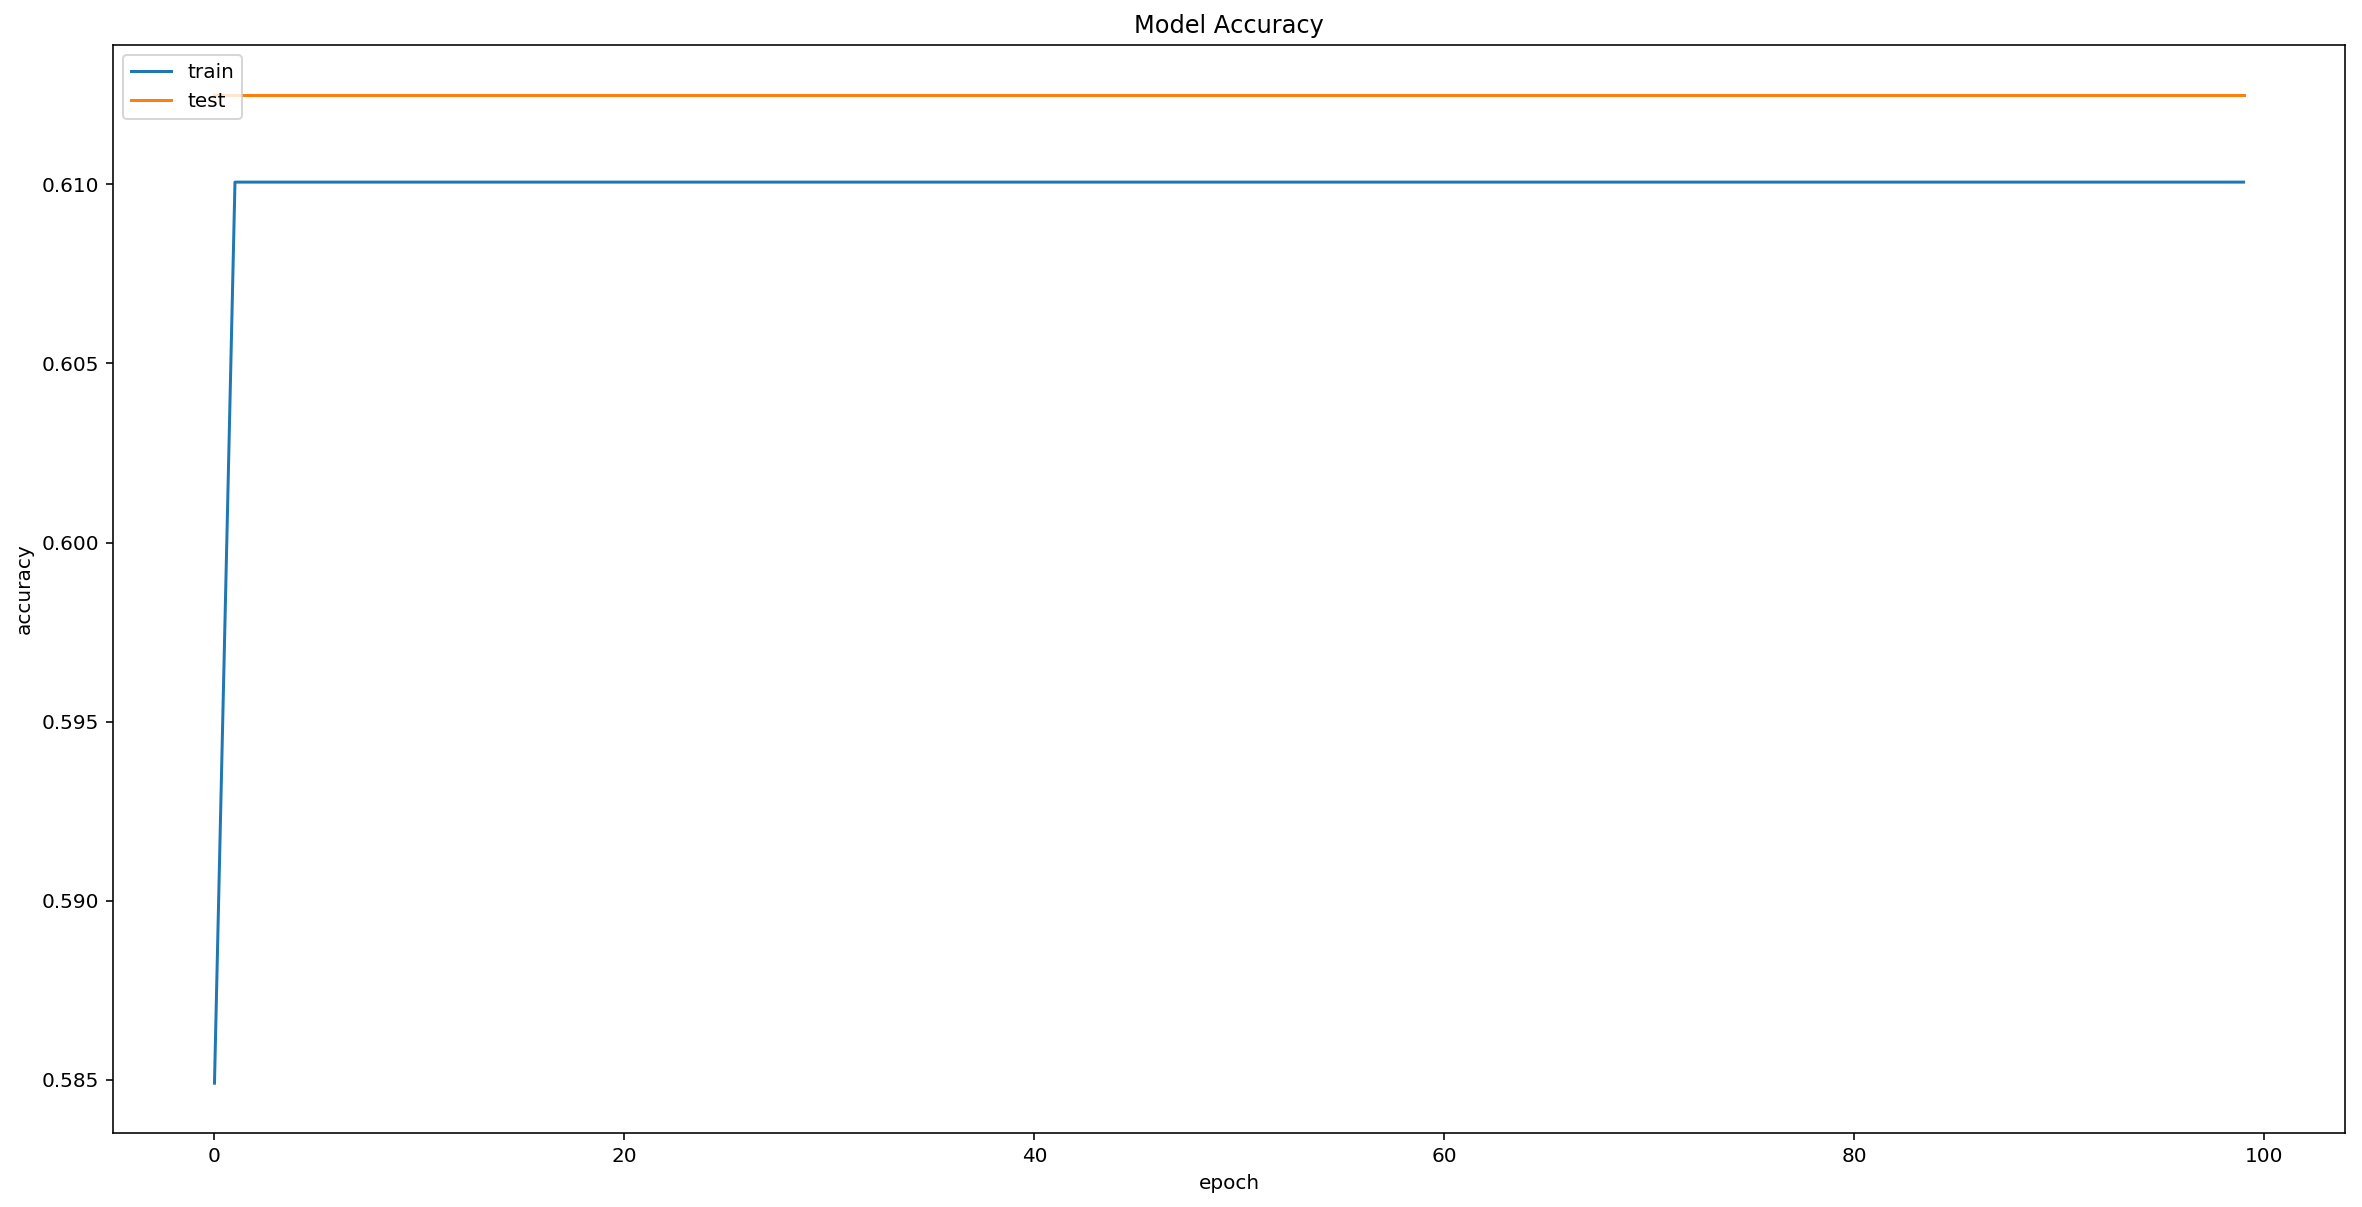

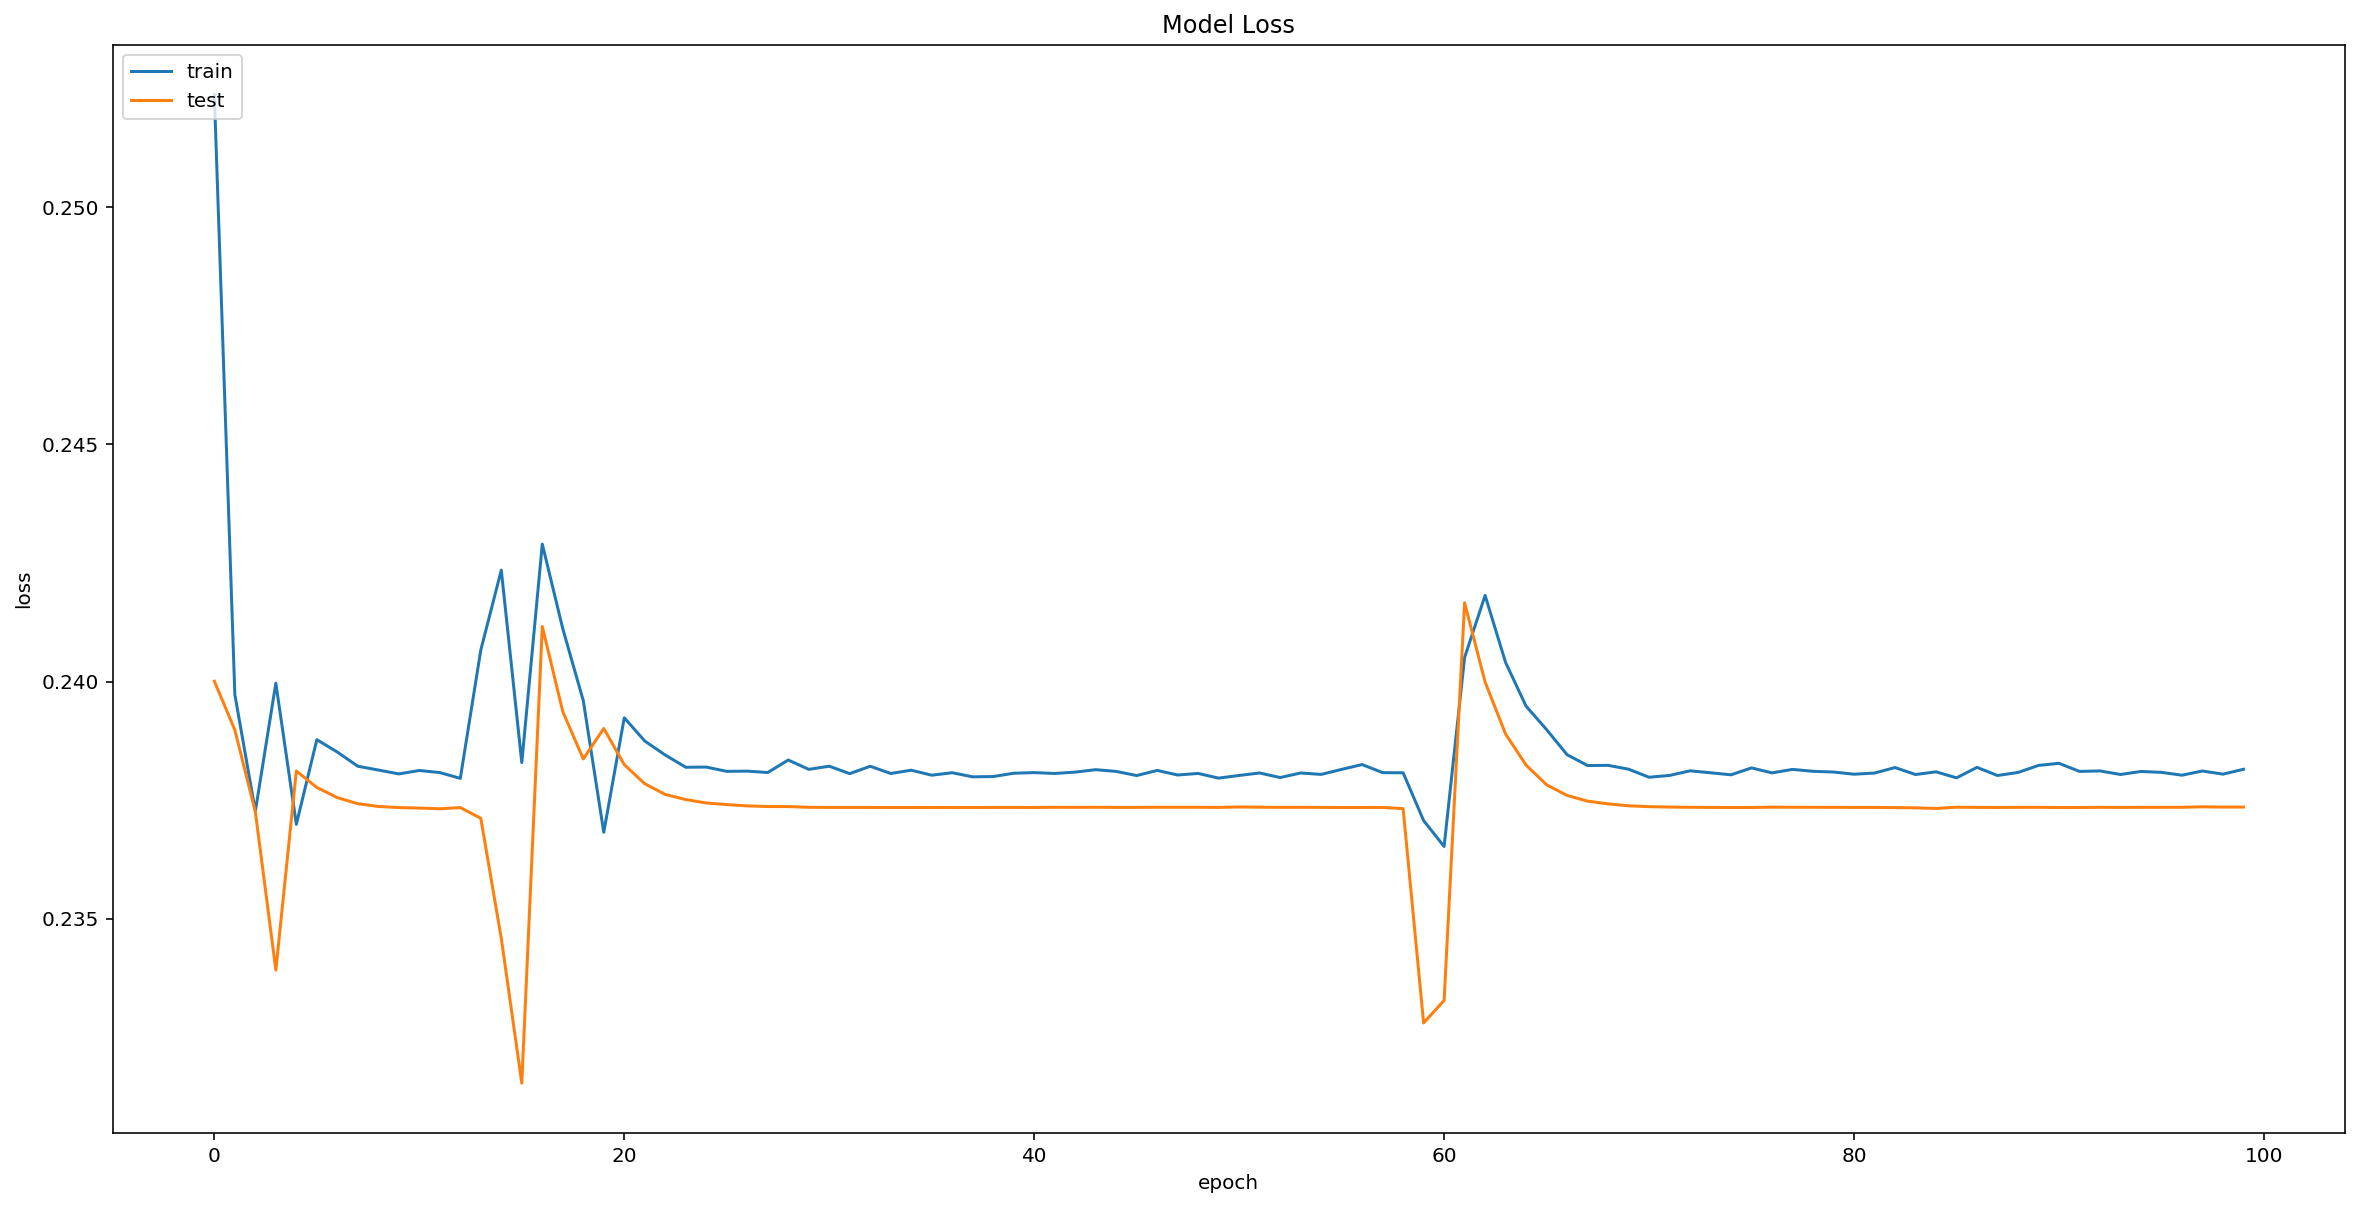

Memory Usage 1.49 MB
Time of Processing 2.84s
Accuracy 66.67%


In [10]:
show_info(model1, X_test, y_test, keras_history1)

In [11]:
# Building the model 2
model2 = Sequential()
model2.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model2.add(Dense(32, activation='sigmoid'))
model2.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model2.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Training the model 2
keras_history2 = KerasHistory()
memory_usage = monitor(target=train(model2, X_train, y_train, keras_history2))
keras_history2.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.3072 - acc: 0.3899 - val_loss: 0.2512 - val_acc: 0.3625
Epoch 2/100
 - 0s - loss: 0.2318 - acc: 0.6006 - val_loss: 0.2172 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2166 - acc: 0.6101 - val_loss: 0.2084 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2093 - acc: 0.6101 - val_loss: 0.2053 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.0600 - acc: 0.9245 - val_loss: 0.0542 - val_acc: 0.9125
Epoch 90/100
 - 0s - loss: 0.0547 - acc: 0.9308 - val_loss: 0.0599 - val_acc: 0.9250
Epoch 91/100
 - 0s - loss: 0.0572 - acc: 0.9245 - val_loss: 0.0501 - val_acc: 0.9375
Epoch 92/100
 - 0s - loss: 0.0647 - acc: 0.9119 - val_loss: 0.0575 - val_acc: 0.9250
Epoch 93/100
 - 0s - loss: 0.0699 - acc: 0.8962 - val_loss: 0.0820 - val_acc: 0.8875
Epoch 94/100
 - 0s - loss: 0.0709 - acc: 0.9025 - val_loss: 0.0523 - val_acc: 0.9250
Epoch 95/100
 - 0s - loss: 0.0591 - acc: 0.9245 - val_loss: 0.0556 - val_acc: 0.9250
Epoch 96/100
 - 0s - loss: 0.0627 - acc: 0.9088 - val_loss: 0.0575 - val_acc: 0.9250
Epoch 97/100
 - 0s - loss: 0.0618 - acc: 0.9214 - val_loss: 0.0528 - val_acc: 0.9250
Epoch 98/100
 - 0s - loss: 0.0536 - acc: 0.9245 - val_loss: 0.0549 - val_acc: 0.9250
Epoch 99/100
 - 0s - loss: 0.0566 - acc: 0.9182 - val_loss: 0.0606 - val_acc: 0.9125
Epoch 100/100
 - 0s - loss: 0.0703 - acc: 0.8836 - val_loss: 0.05

## Treinamento 2
Para o treinamento 2 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a sigmóide como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

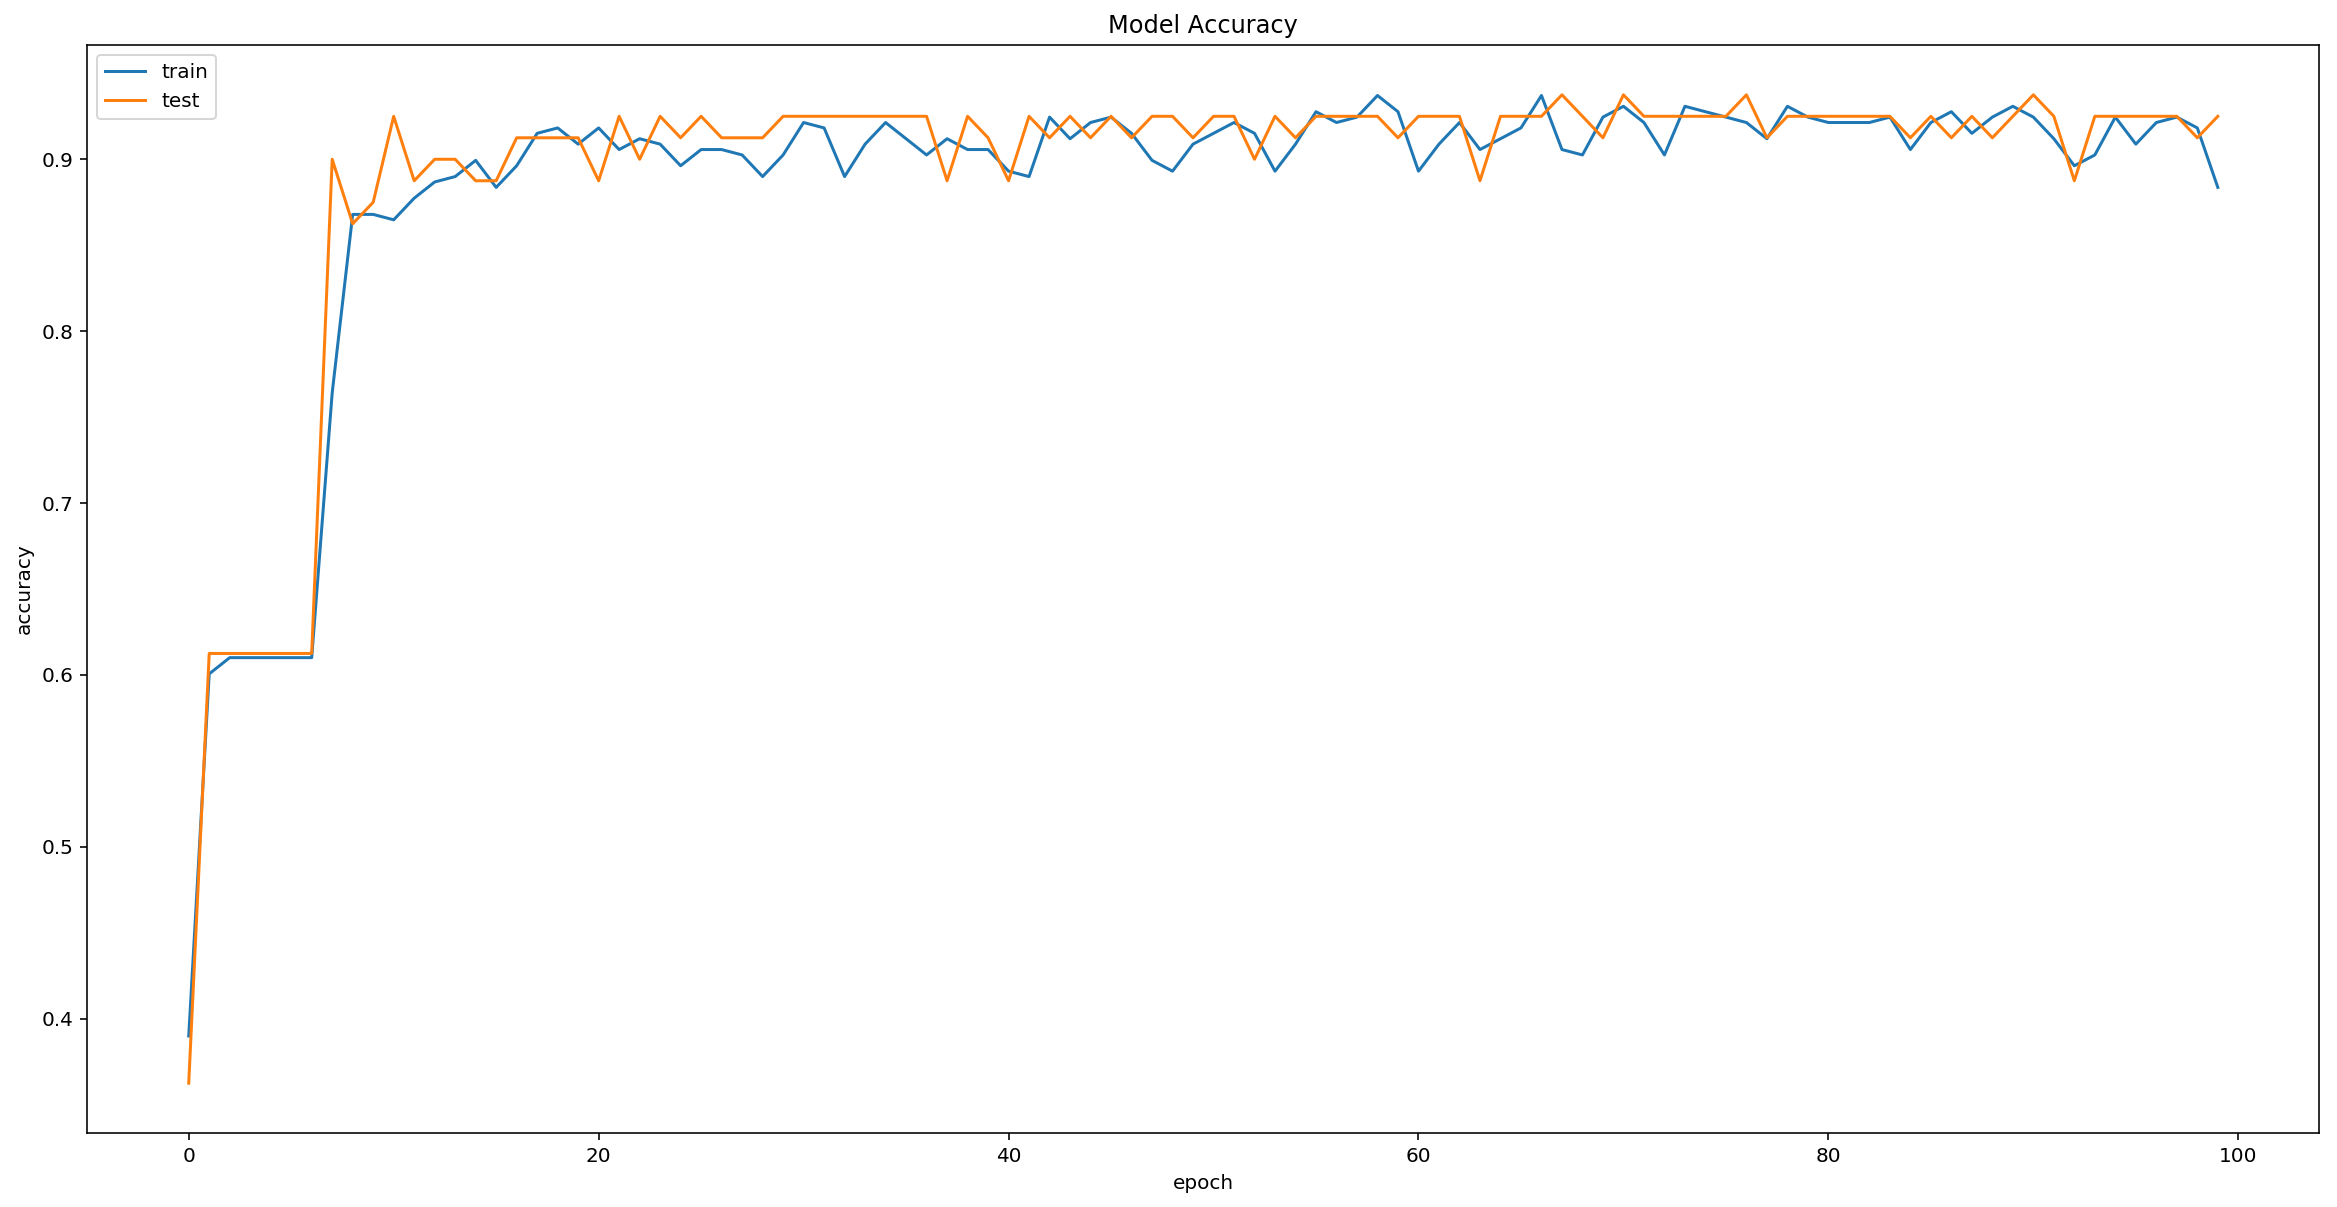

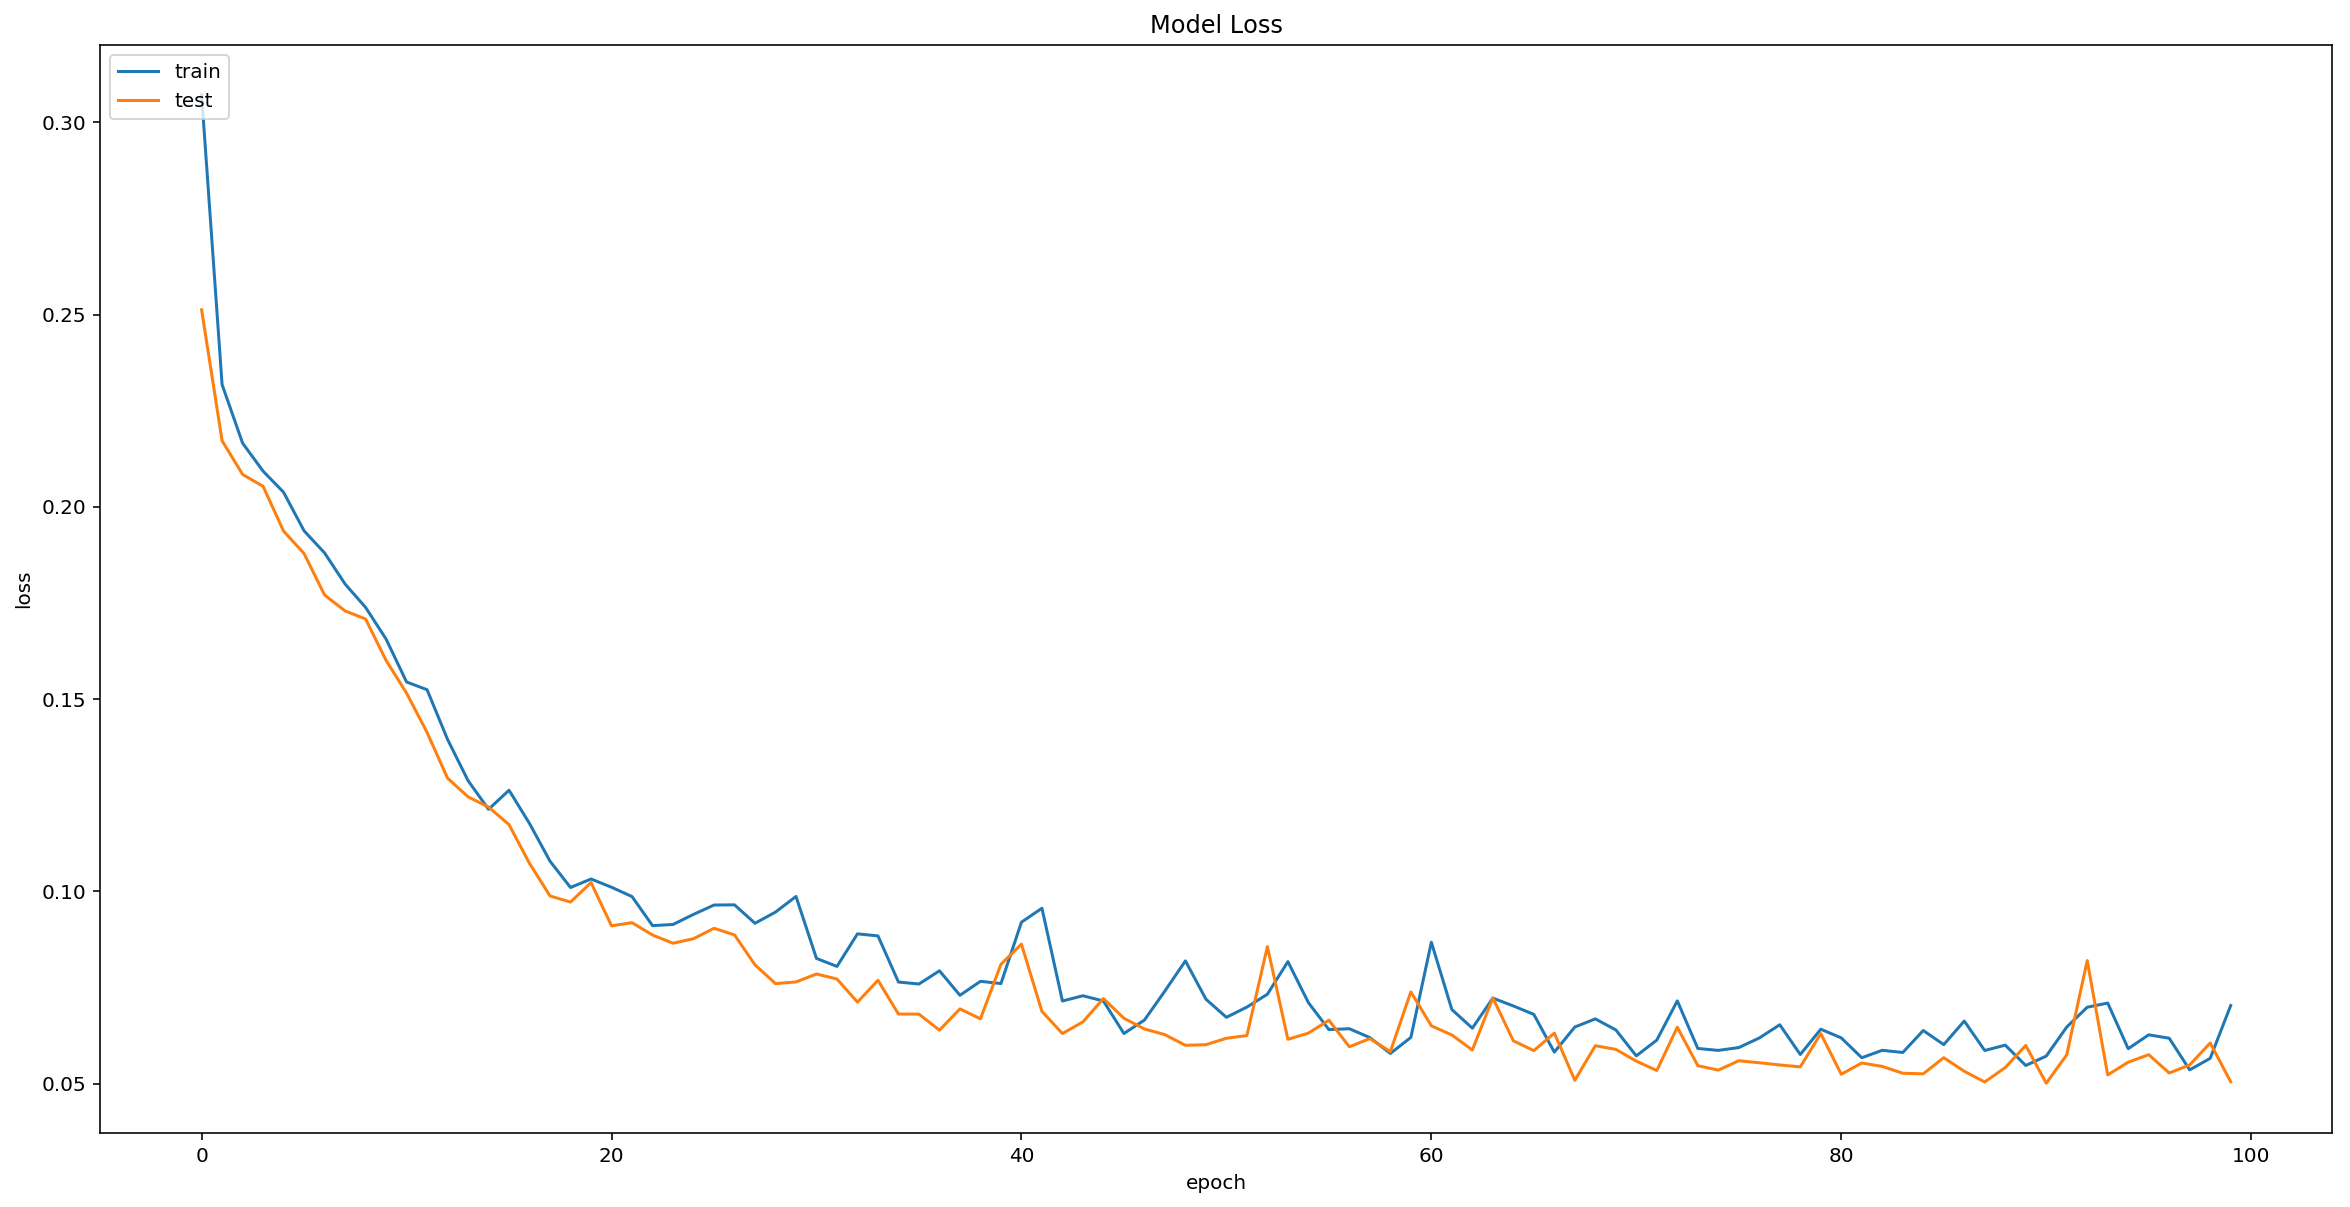

Memory Usage 1.64 MB
Time of Processing 3.77s
Accuracy 92.40%


In [12]:
show_info(model2, X_test, y_test, keras_history2)

In [13]:
# Building the model 3
model3 = Sequential()
model3.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model3.add(Dense(32, activation='tanh'))
model3.add(Dense(2, activation='tanh'))

# Compile model with loss function, optmizer and metrics
model3.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model3.summary()

# Training the model 3
keras_history3 = KerasHistory()
memory_usage = monitor(target=train(model3, X_train, y_train, keras_history3))
keras_history3.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.3113 - acc: 0.5346 - val_loss: 0.2626 - val_acc: 0.6125
Epoch 2/100
 - 0s - loss: 0.2515 - acc: 0.6101 - val_loss: 0.2315 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2316 - acc: 0.6101 - val_loss: 0.2248 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2183 - acc: 0.6101 - val_loss: 0.2072 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2386 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 90/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 91/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 92/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 93/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 94/100
 - 0s - loss: 0.2402 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 95/100
 - 0s - loss: 0.2384 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 96/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2376 - val_acc: 0.6125
Epoch 97/100
 - 0s - loss: 0.2393 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 98/100
 - 0s - loss: 0.2391 - acc: 0.6101 - val_loss: 0.2378 - val_acc: 0.6125
Epoch 99/100
 - 0s - loss: 0.2425 - acc: 0.6101 - val_loss: 0.2377 - val_acc: 0.6125
Epoch 100/100
 - 0s - loss: 0.2387 - acc: 0.6101 - val_loss: 0.23

## Treinamento 3
Para o treinamento 3 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a tangente hiperbólica como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

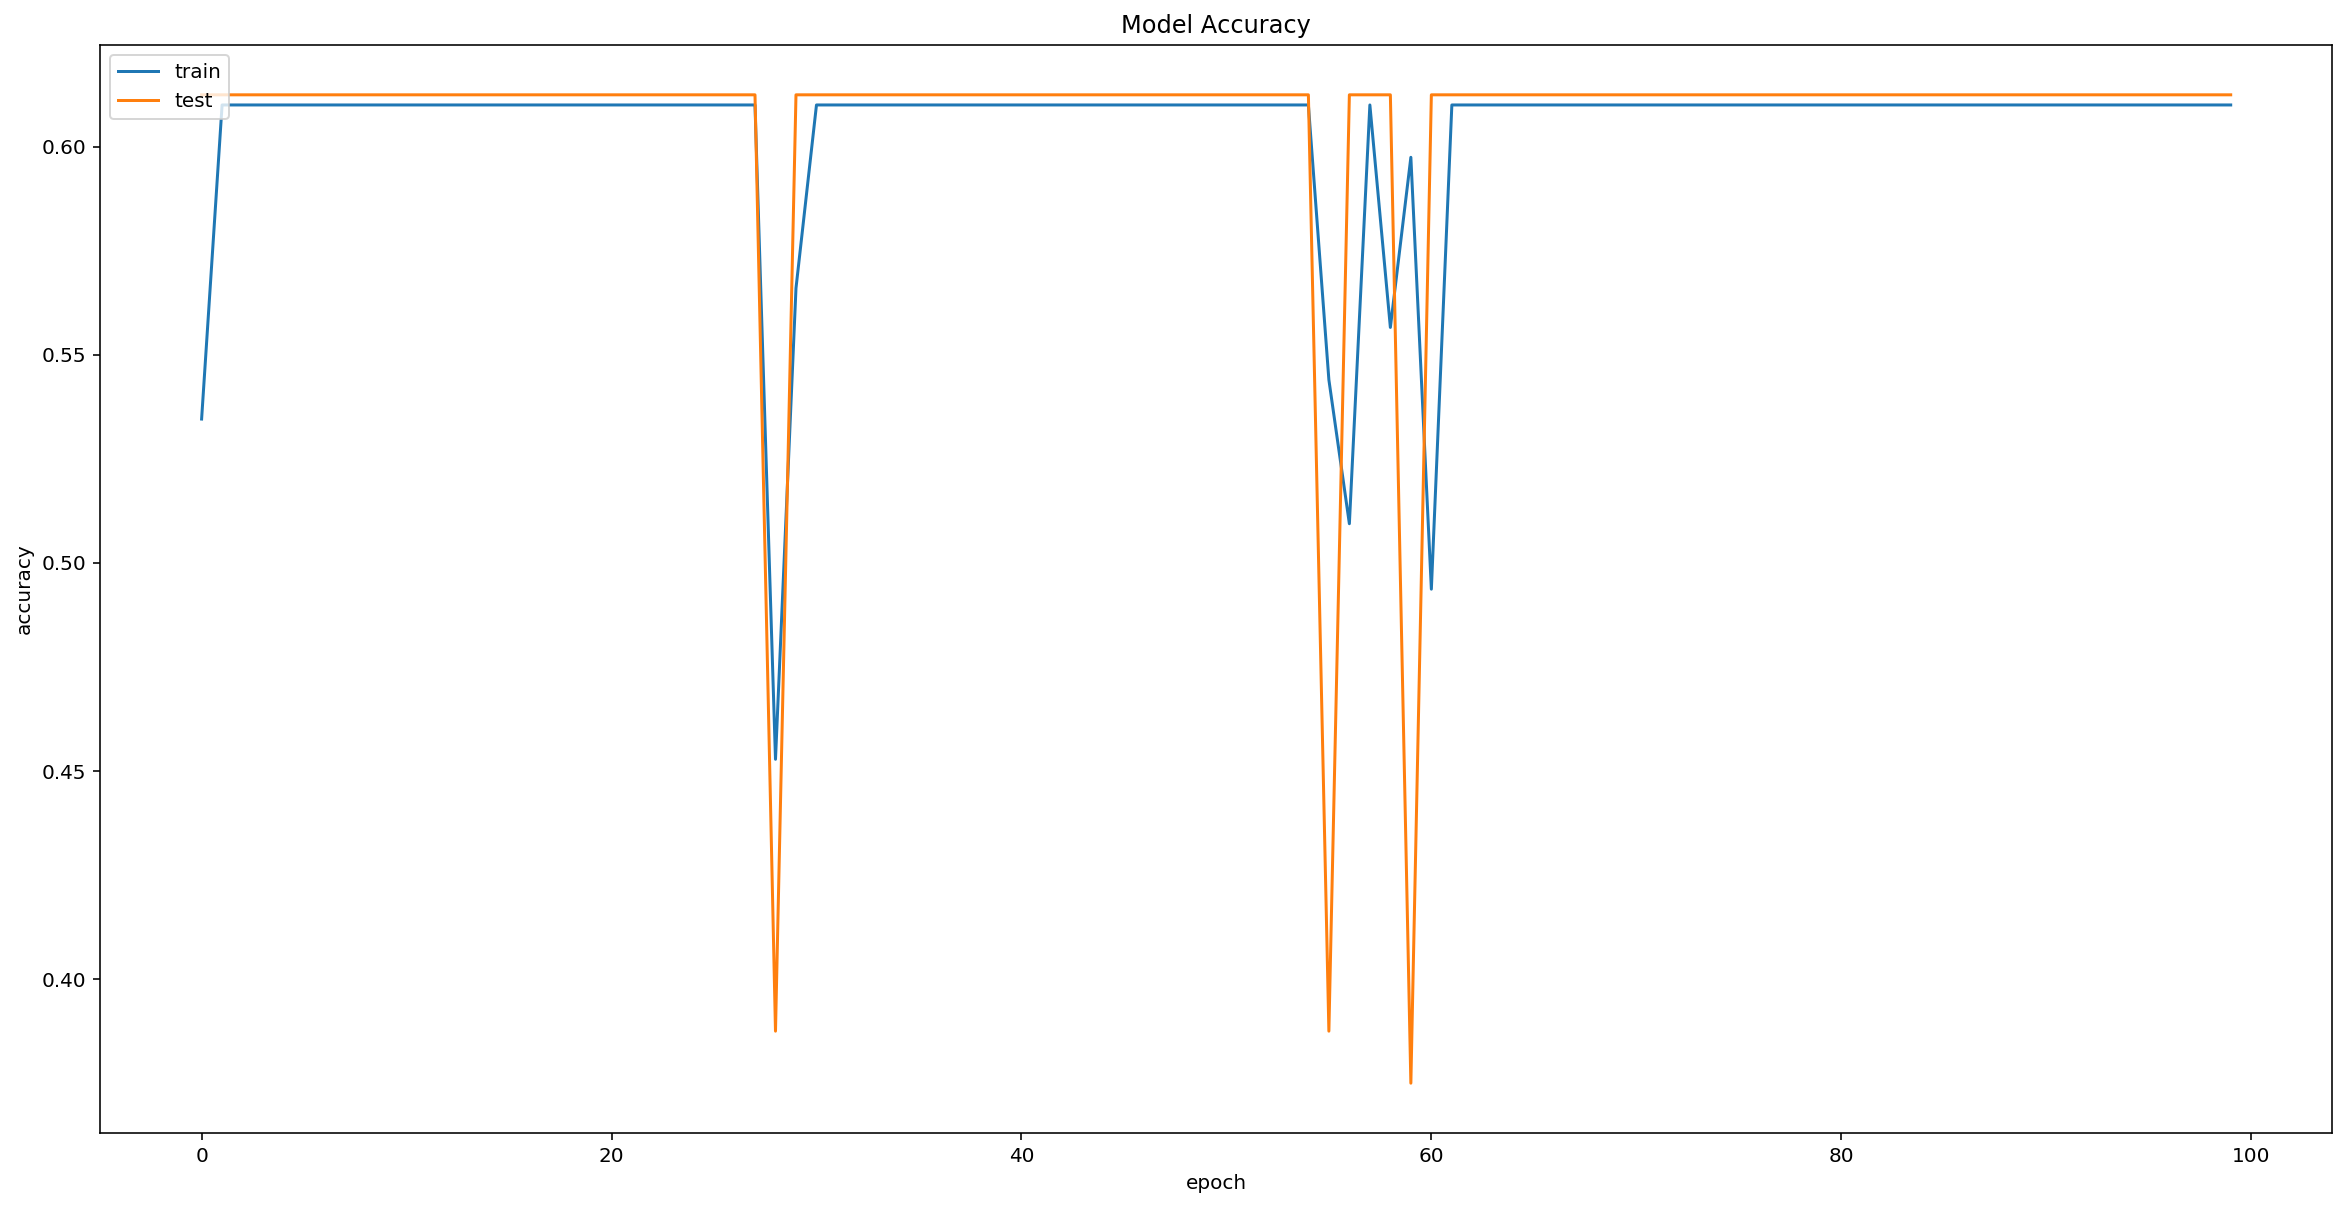

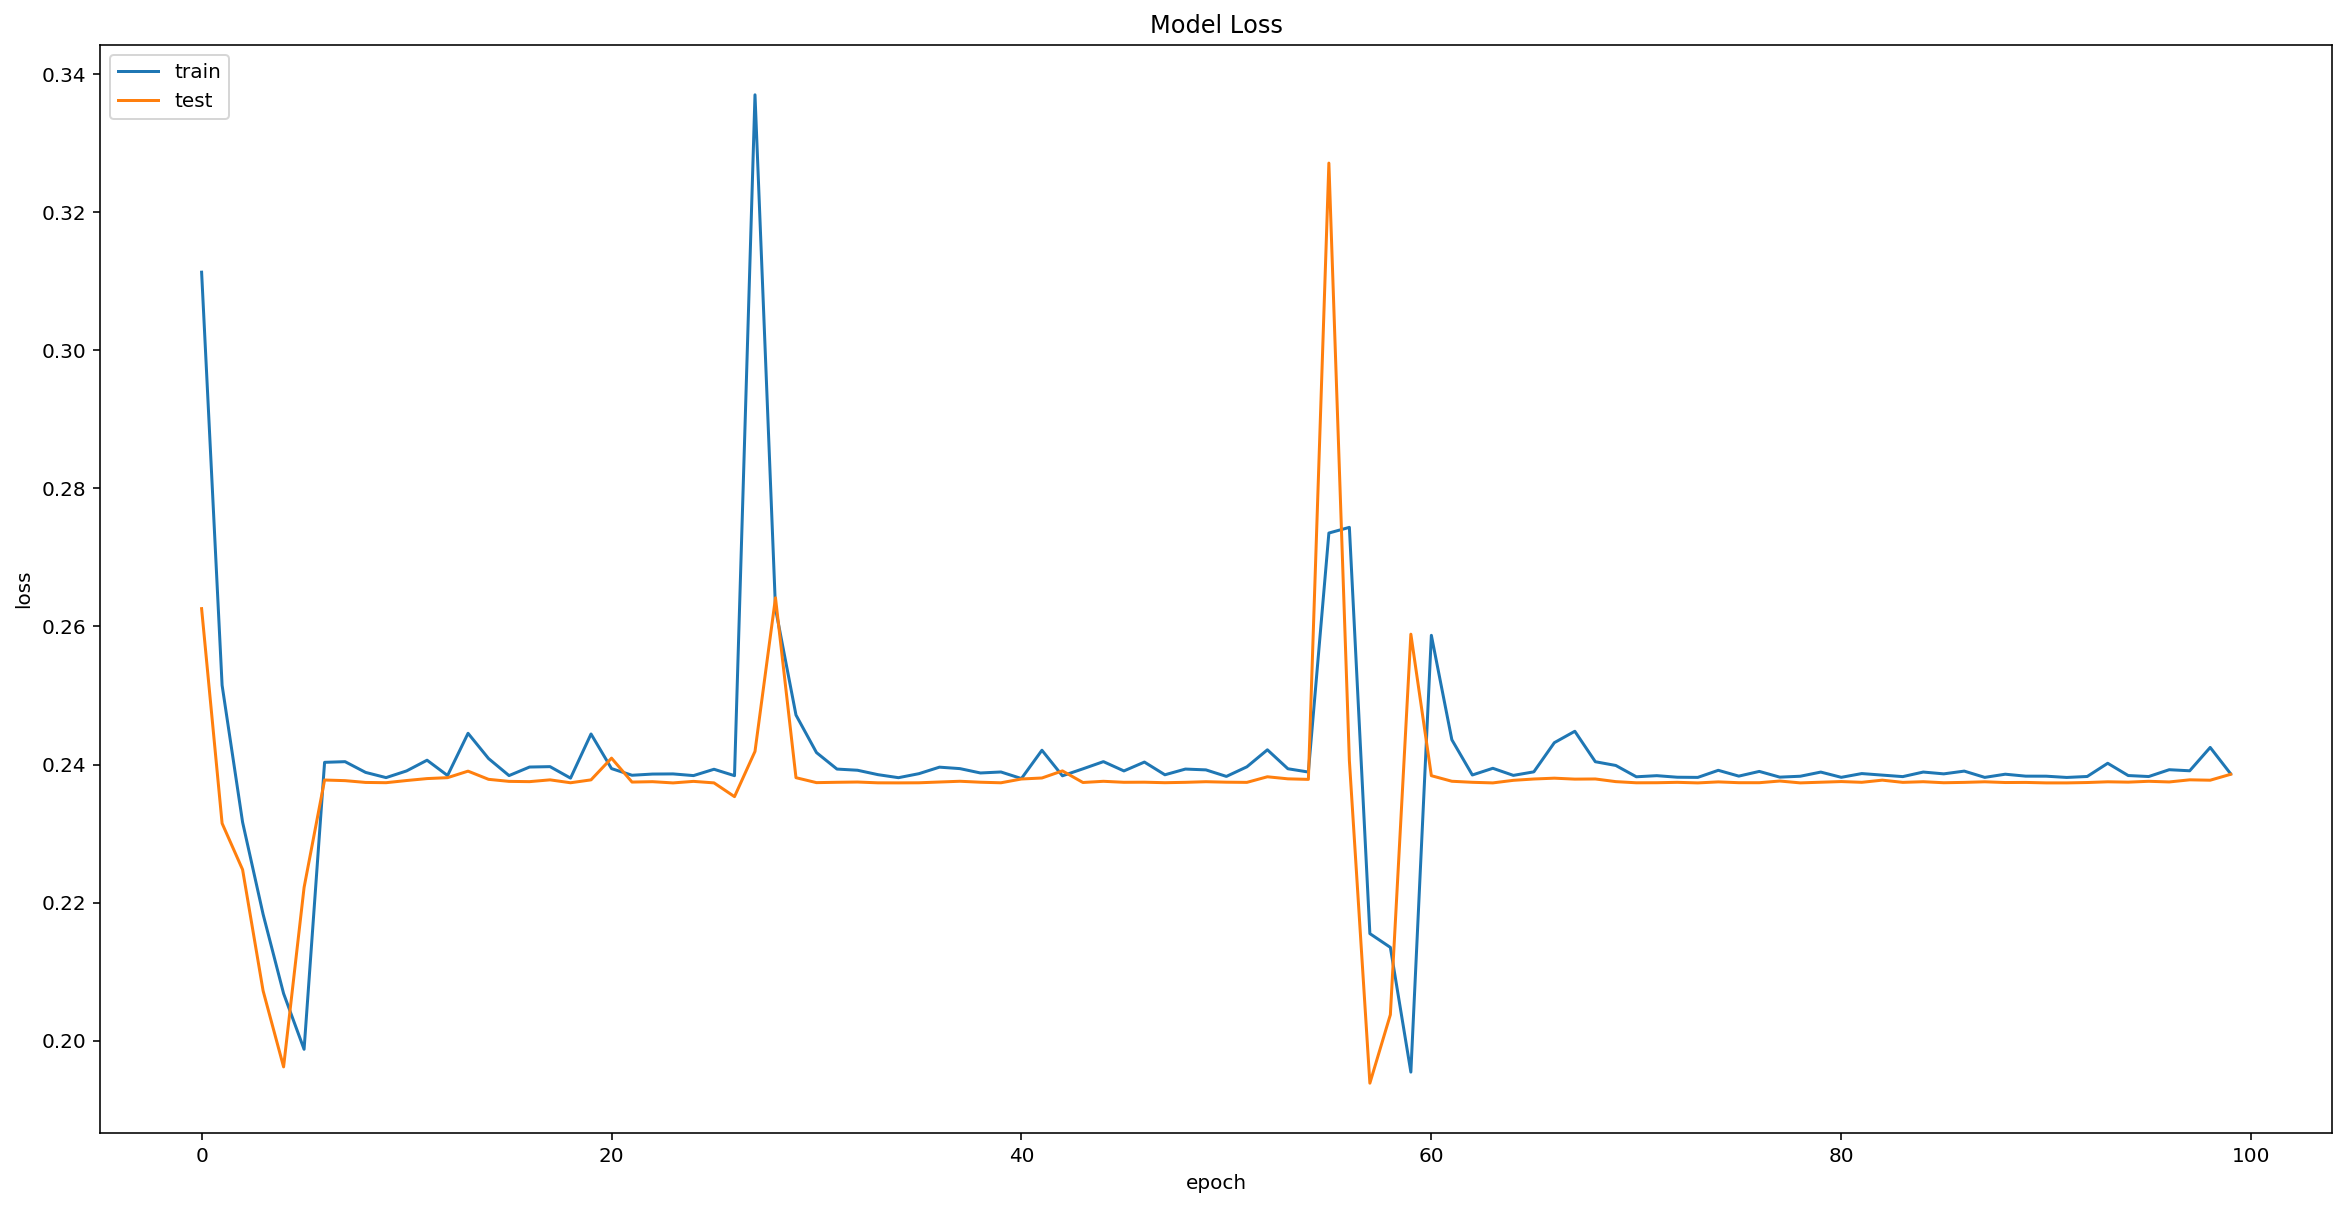

Memory Usage 1.21 MB
Time of Processing 3.81s
Accuracy 66.67%


In [14]:
show_info(model3, X_test, y_test, keras_history3)

In [15]:
# Normalization of data
X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.mean()) / (X_test.max() - X_test.min())

In [16]:
# Building the model 4
model4 = Sequential()
model4.add(Dense(32, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model4.add(Dense(16, activation='tanh'))
model4.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model4.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model4.summary()

# Training the model 4
keras_history4 = KerasHistory()
memory_usage = monitor(target=train(model4, X_train_norm, y_train, keras_history4, epochs=50))
keras_history4.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/50
 - 0s - loss: 0.2452 - acc: 0.8994 - val_loss: 0.2441 - val_acc: 0.8875
Epoch 2/50
 - 0s - loss: 0.2435 - acc: 0.8616 - val_loss: 0.2425 - val_acc: 0.8250
Epoch 3/50
 - 0s - loss: 0.2419 - acc: 0.8050 - val_loss: 0.2409 - val_acc: 0.8125
Epoch 4/50
 - 0s - loss: 0.2404 - acc: 0.7767 - val_loss: 0.2393 - val_acc: 0.7625
Epoch 5/50
 - 0s - loss: 0.

## Treinamento 4
Para o treinamento 4 foram utilizados os seguintes hiperparametros:

Épocas = 50

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 32 e a segunda com 16 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Uma técnica utilizada nesse caso foi normalizar os dados, com isso foi possível diminuir o número de neurônios nas camadas ocultas, o número de épocas foi a metade e a precisão do modelo melhorou.

Nesse ciclo podemos observar os resultados abaixo:

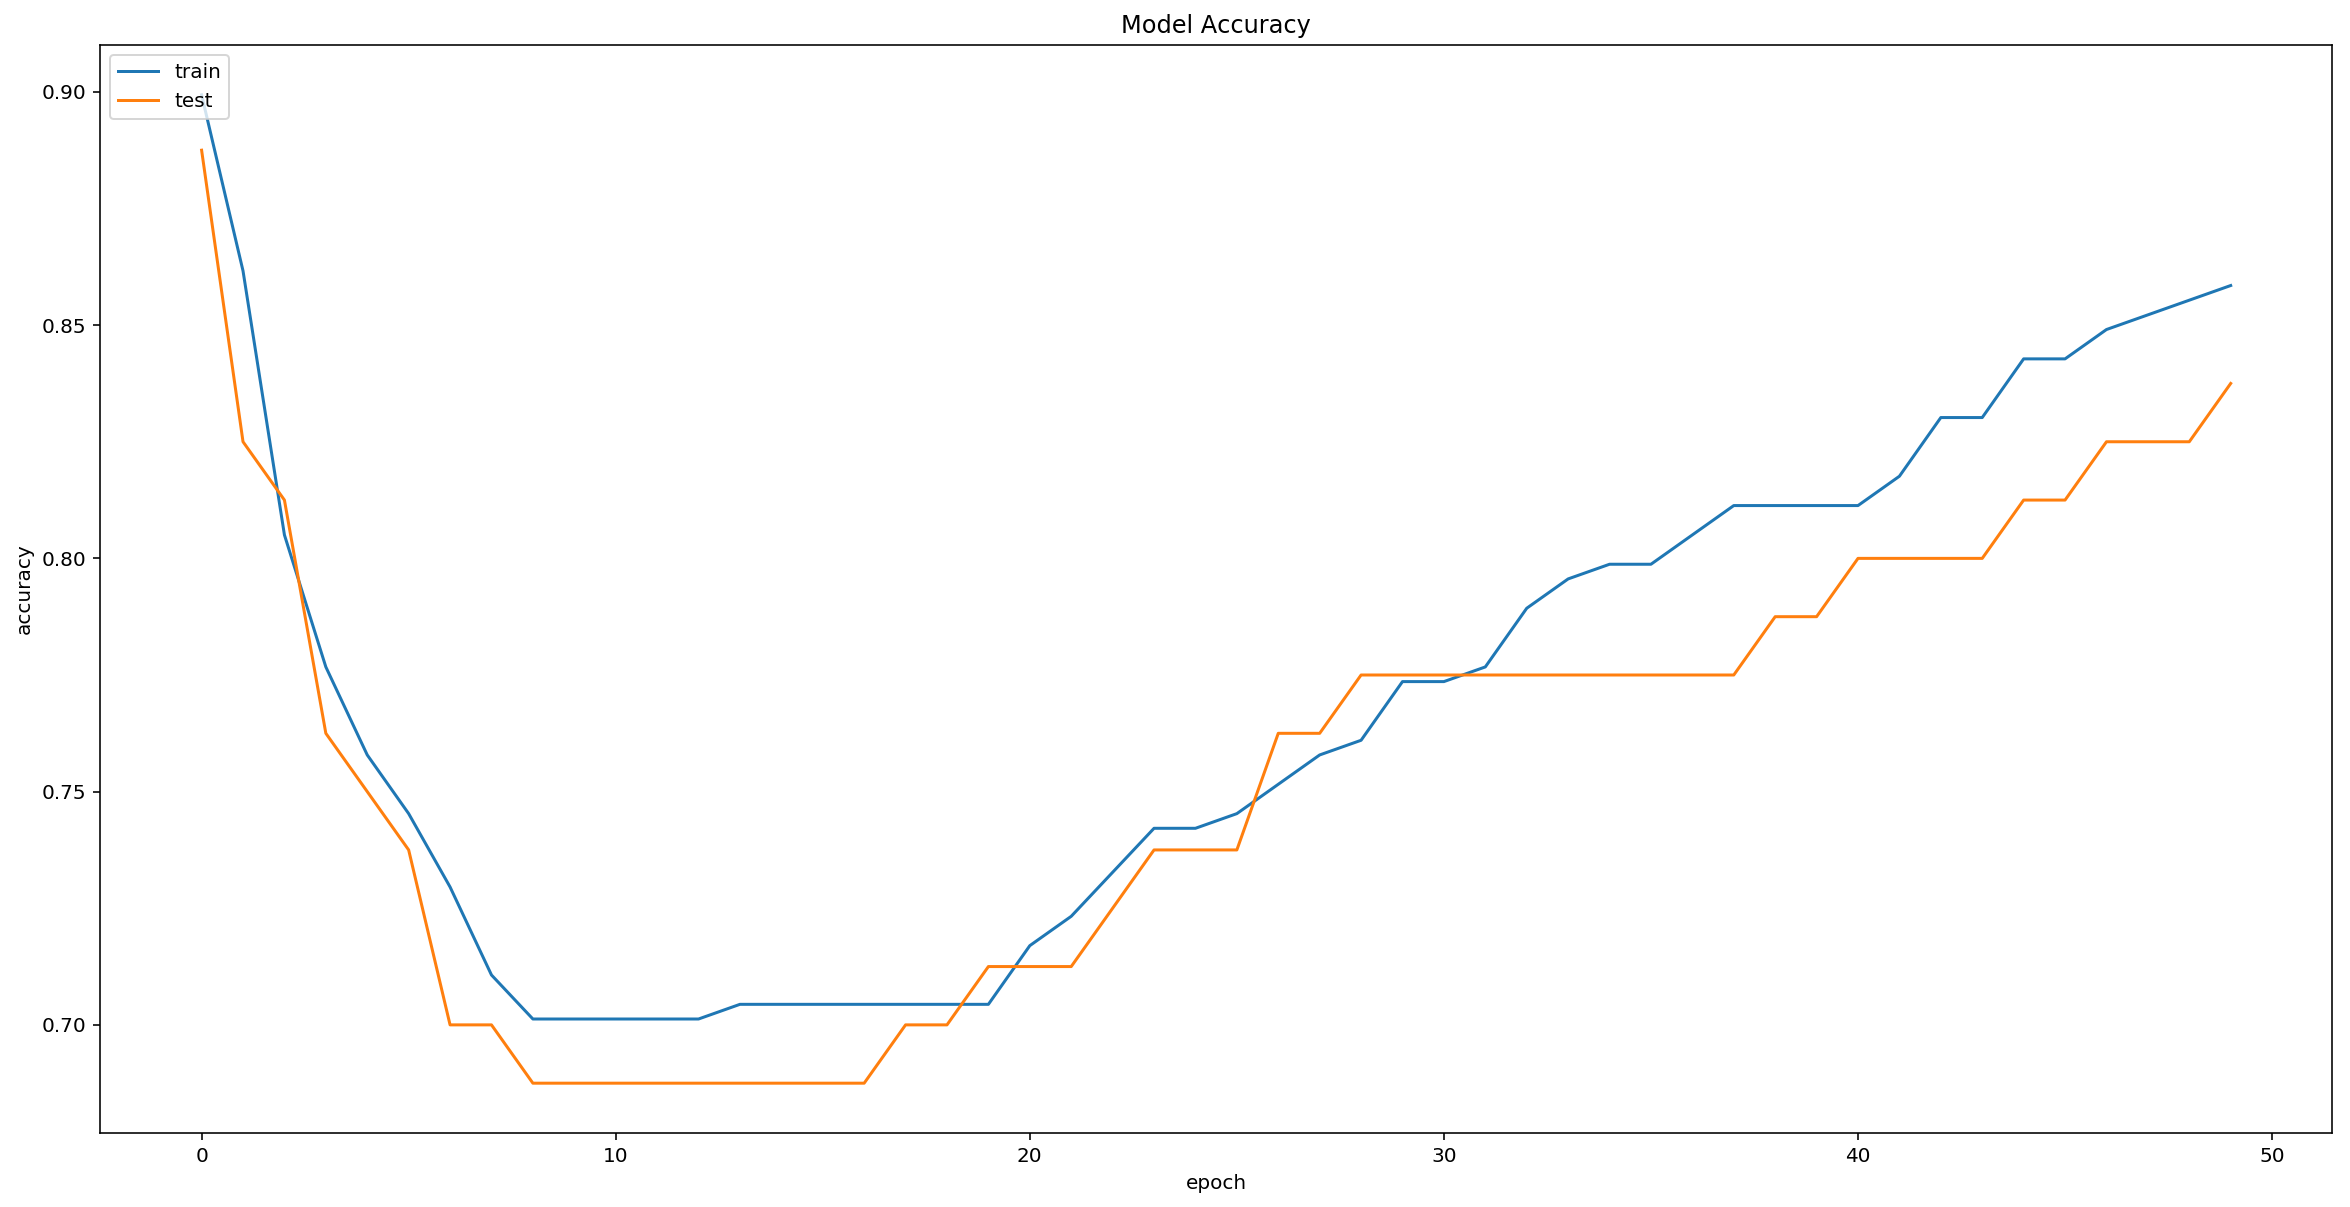

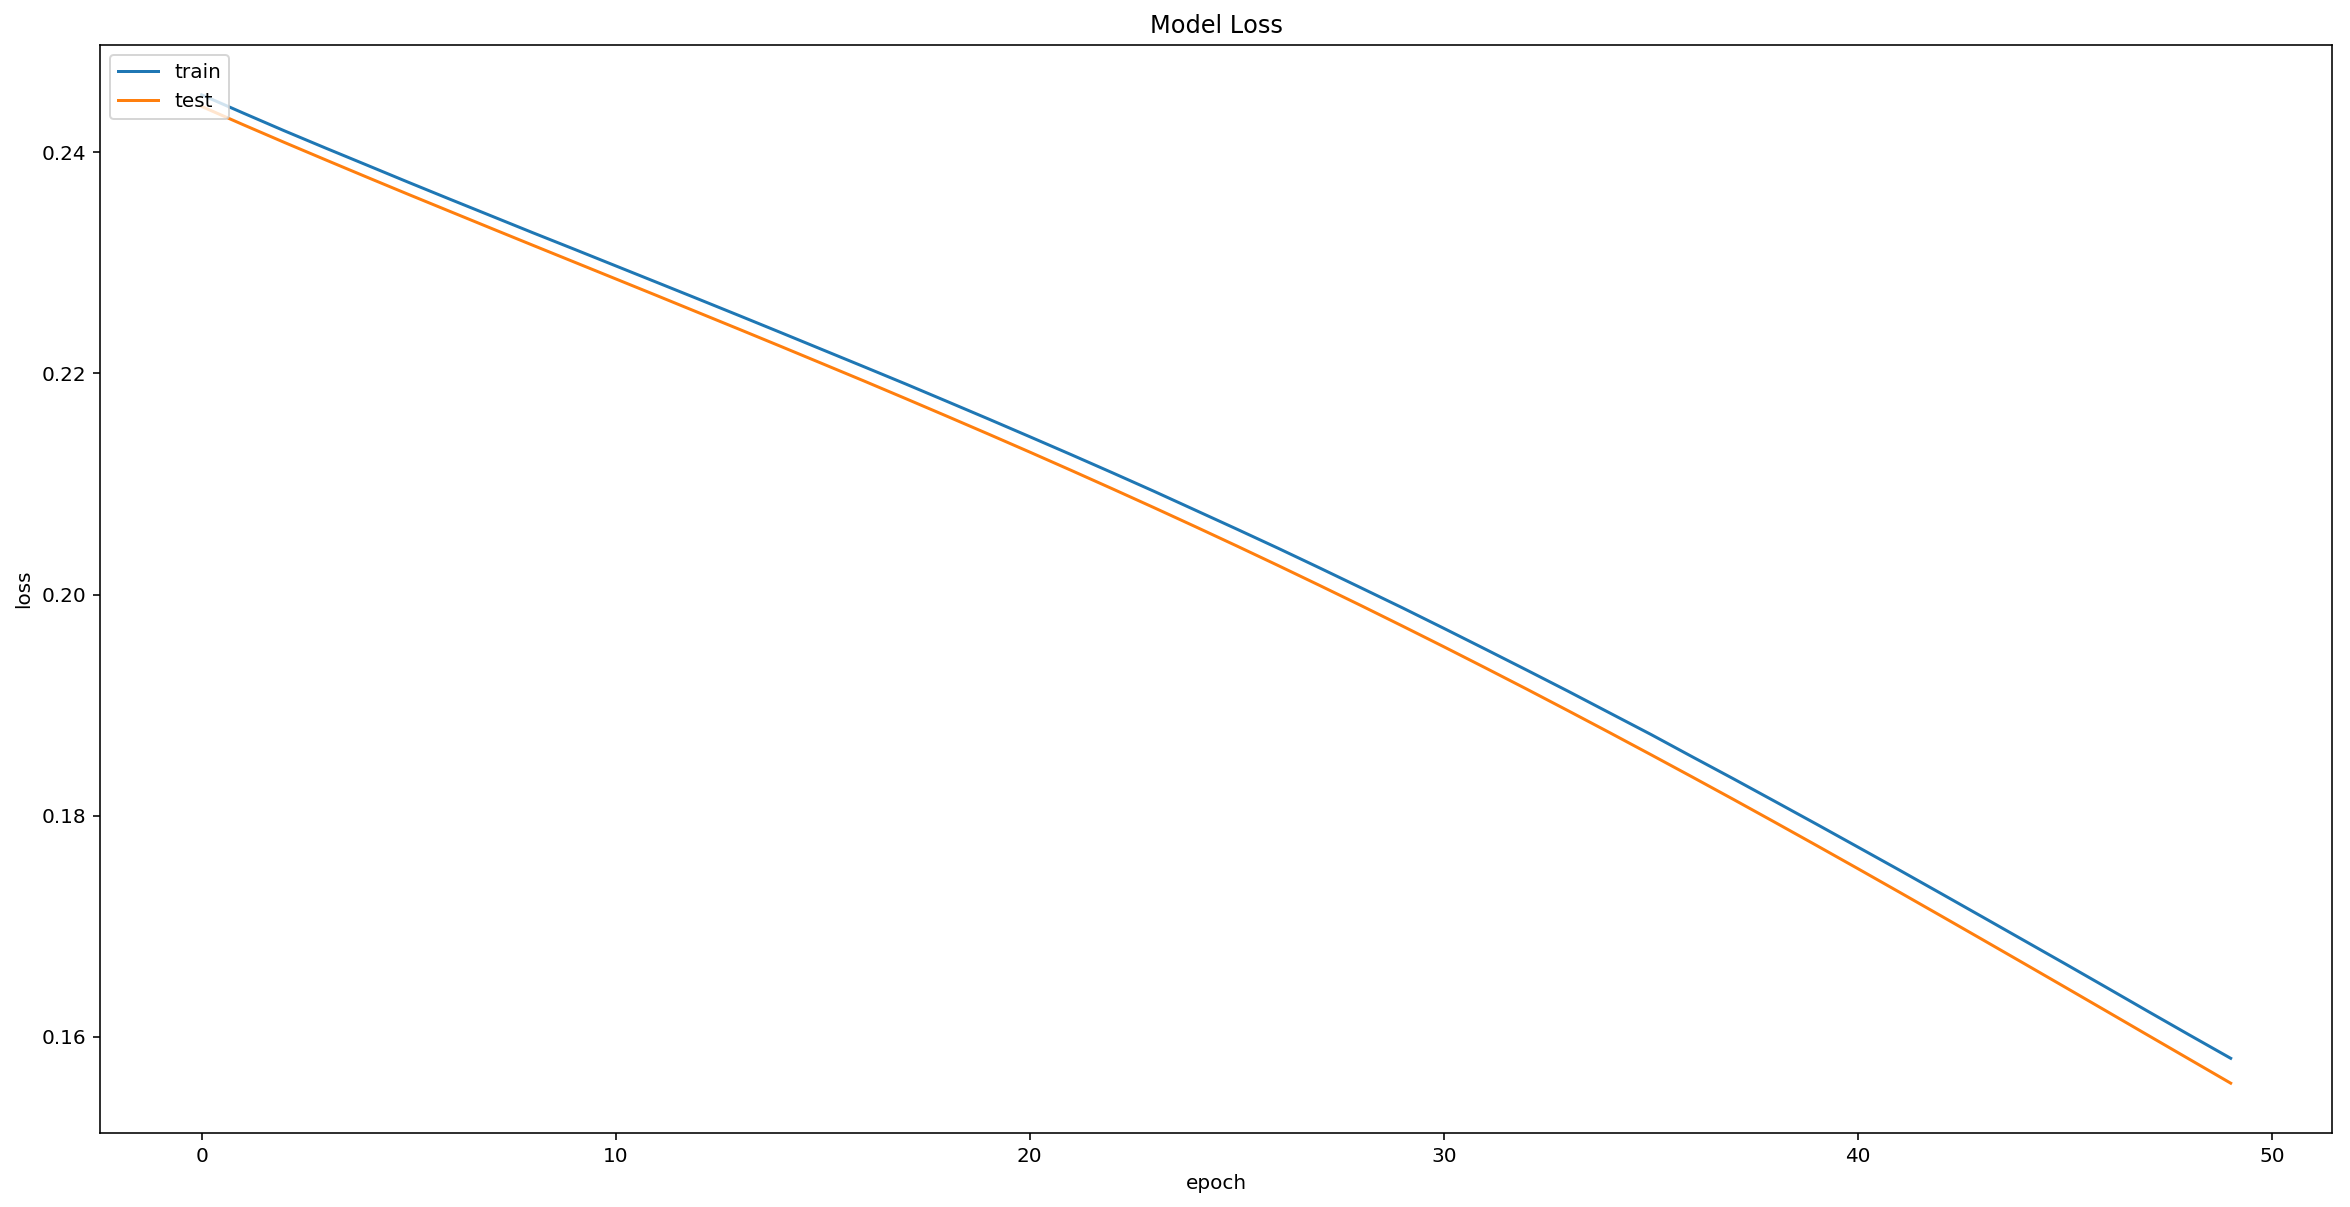

Memory Usage 1.24 MB
Time of Processing 1.50s
Accuracy 91.23%


In [17]:
show_info(model4, X_test_norm, y_test, keras_history4)

In [26]:
# Building the model 5
model5 = Sequential()
model5.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model5.add(Dense(64, activation='tanh'))
model5.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model5.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model5.summary()

# Training the model 5
keras_history5 = KerasHistory()
memory_usage = monitor(target=train(model5, X_train_norm, y_train, keras_history5, epochs=1000, batch_size=10))
keras_history5.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/1000
 - 0s - loss: 0.2421 - acc: 0.7987 - val_loss: 0.2372 - val_acc: 0.9500
Epoch 2/1000
 - 0s - loss: 0.2337 - acc: 0.8868 - val_loss: 0.2290 - val_acc: 0.8750
Epoch 3/1000
 - 0s - loss: 0.2260 - acc: 0.8459 - val_loss: 0.2214 - val_acc: 0.8000
Epoch 4/1000
 - 0s - loss: 0.2188 - acc: 0.8019 - val_loss: 0.2144 - val_acc: 0.7750
Epoch 5/1000
 - 0

Epoch 88/1000
 - 0s - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0392 - val_acc: 0.9500
Epoch 89/1000
 - 0s - loss: 0.0443 - acc: 0.9528 - val_loss: 0.0389 - val_acc: 0.9500
Epoch 90/1000
 - 0s - loss: 0.0440 - acc: 0.9528 - val_loss: 0.0387 - val_acc: 0.9500
Epoch 91/1000
 - 0s - loss: 0.0437 - acc: 0.9528 - val_loss: 0.0384 - val_acc: 0.9500
Epoch 92/1000
 - 0s - loss: 0.0434 - acc: 0.9528 - val_loss: 0.0381 - val_acc: 0.9500
Epoch 93/1000
 - 0s - loss: 0.0431 - acc: 0.9528 - val_loss: 0.0379 - val_acc: 0.9500
Epoch 94/1000
 - 0s - loss: 0.0428 - acc: 0.9528 - val_loss: 0.0376 - val_acc: 0.9500
Epoch 95/1000
 - 0s - loss: 0.0425 - acc: 0.9528 - val_loss: 0.0373 - val_acc: 0.9500
Epoch 96/1000
 - 0s - loss: 0.0423 - acc: 0.9560 - val_loss: 0.0371 - val_acc: 0.9500
Epoch 97/1000
 - 0s - loss: 0.0420 - acc: 0.9560 - val_loss: 0.0369 - val_acc: 0.9500
Epoch 98/1000
 - 0s - loss: 0.0417 - acc: 0.9560 - val_loss: 0.0366 - val_acc: 0.9500
Epoch 99/1000
 - 0s - loss: 0.0415 - acc: 0.9560 - val

Epoch 183/1000
 - 0s - loss: 0.0297 - acc: 0.9748 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 184/1000
 - 0s - loss: 0.0296 - acc: 0.9748 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 185/1000
 - 0s - loss: 0.0295 - acc: 0.9748 - val_loss: 0.0250 - val_acc: 0.9750
Epoch 186/1000
 - 0s - loss: 0.0295 - acc: 0.9748 - val_loss: 0.0249 - val_acc: 0.9875
Epoch 187/1000
 - 0s - loss: 0.0294 - acc: 0.9748 - val_loss: 0.0248 - val_acc: 0.9875
Epoch 188/1000
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0248 - val_acc: 0.9875
Epoch 189/1000
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0247 - val_acc: 0.9875
Epoch 190/1000
 - 0s - loss: 0.0292 - acc: 0.9748 - val_loss: 0.0246 - val_acc: 0.9875
Epoch 191/1000
 - 0s - loss: 0.0291 - acc: 0.9748 - val_loss: 0.0245 - val_acc: 0.9875
Epoch 192/1000
 - 0s - loss: 0.0291 - acc: 0.9748 - val_loss: 0.0245 - val_acc: 0.9875
Epoch 193/1000
 - 0s - loss: 0.0290 - acc: 0.9748 - val_loss: 0.0244 - val_acc: 0.9875
Epoch 194/1000
 - 0s - loss: 0.0289 - acc: 

 - 0s - loss: 0.0251 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 278/1000
 - 0s - loss: 0.0251 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 279/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 280/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 281/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 282/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 283/1000
 - 0s - loss: 0.0249 - acc: 0.9748 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 284/1000
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 285/1000
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 286/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 287/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 288/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_lo

Epoch 372/1000
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 373/1000
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 374/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 375/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 376/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 377/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 378/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 379/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 380/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 381/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 382/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0175 - val_acc: 0.9750
Epoch 383/1000
 - 0s - loss: 0.0227 - acc: 

 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0165 - val_acc: 0.9750
Epoch 467/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0165 - val_acc: 0.9750
Epoch 468/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 469/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 470/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 471/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 472/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 473/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 474/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 475/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 476/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 477/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_lo

Epoch 561/1000
 - 0s - loss: 0.0206 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 562/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 563/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 564/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 565/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 566/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 567/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 568/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 569/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 570/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 571/1000
 - 0s - loss: 0.0204 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 572/1000
 - 0s - loss: 0.0204 - acc: 

 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 656/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 657/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 658/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 659/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 660/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 661/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 662/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 663/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 664/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 665/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 666/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_lo

Epoch 750/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 751/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 752/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 753/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 754/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 755/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 756/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 757/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 758/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 759/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 760/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 761/1000
 - 0s - loss: 0.0191 - acc: 

 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 845/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 846/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 847/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 848/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 849/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 850/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 851/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 852/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 853/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 854/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 855/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_lo

Epoch 939/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 940/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 941/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 942/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 943/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 944/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 945/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 946/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 947/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 948/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 949/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 950/1000
 - 0s - loss: 0.0182 - acc: 

## Treinamento 5
Para o treinamento 5 foram utilizados os seguintes hiperparametros:

Épocas = 1000

Batchsize = 10

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

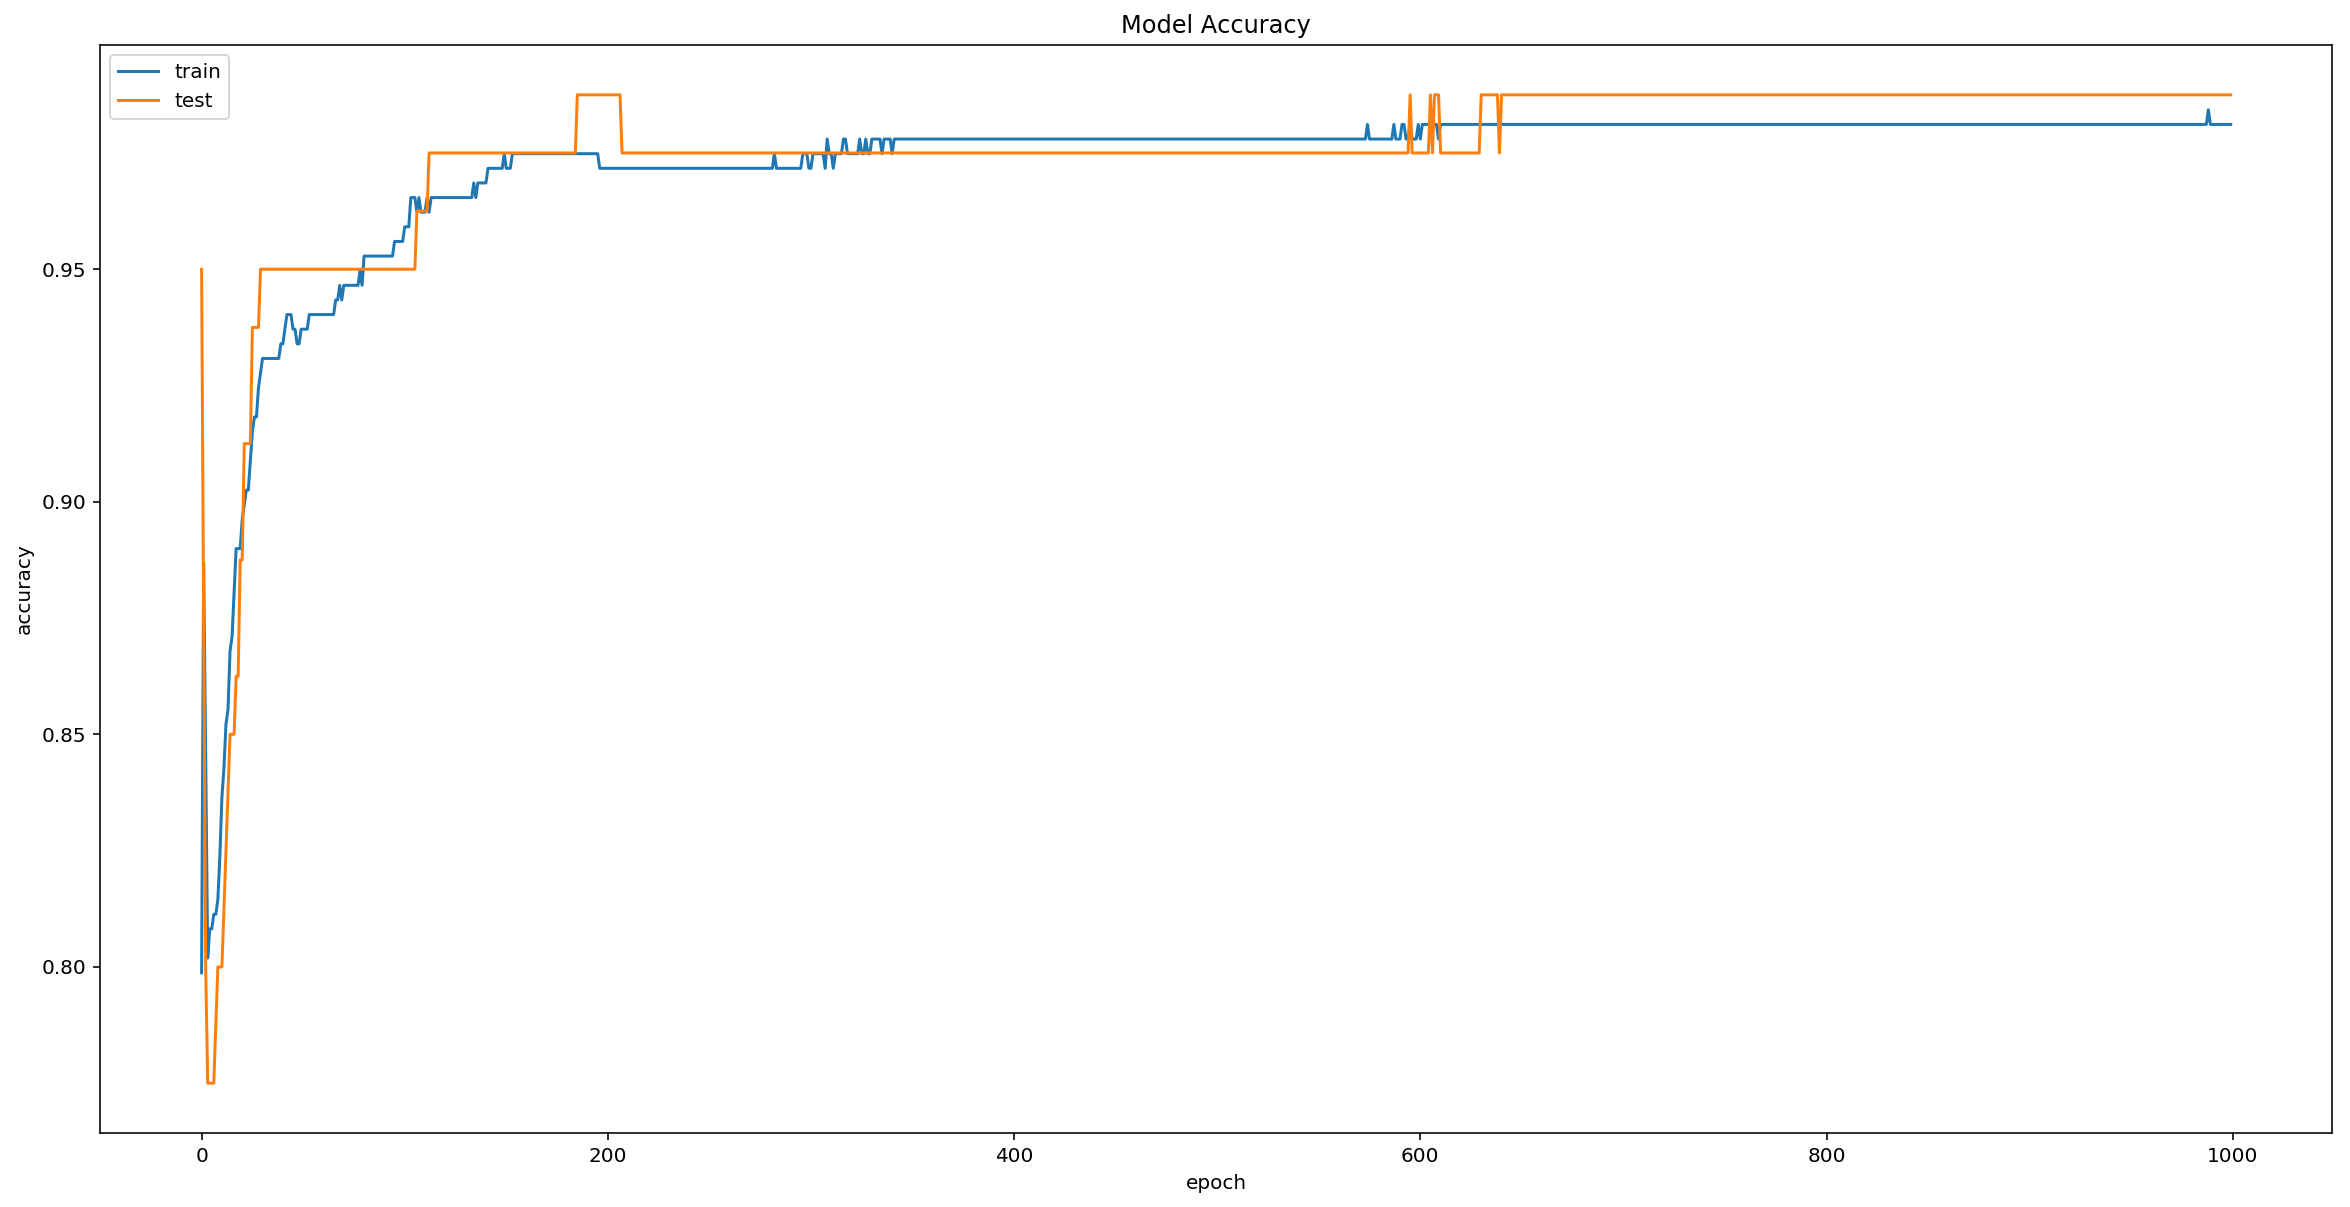

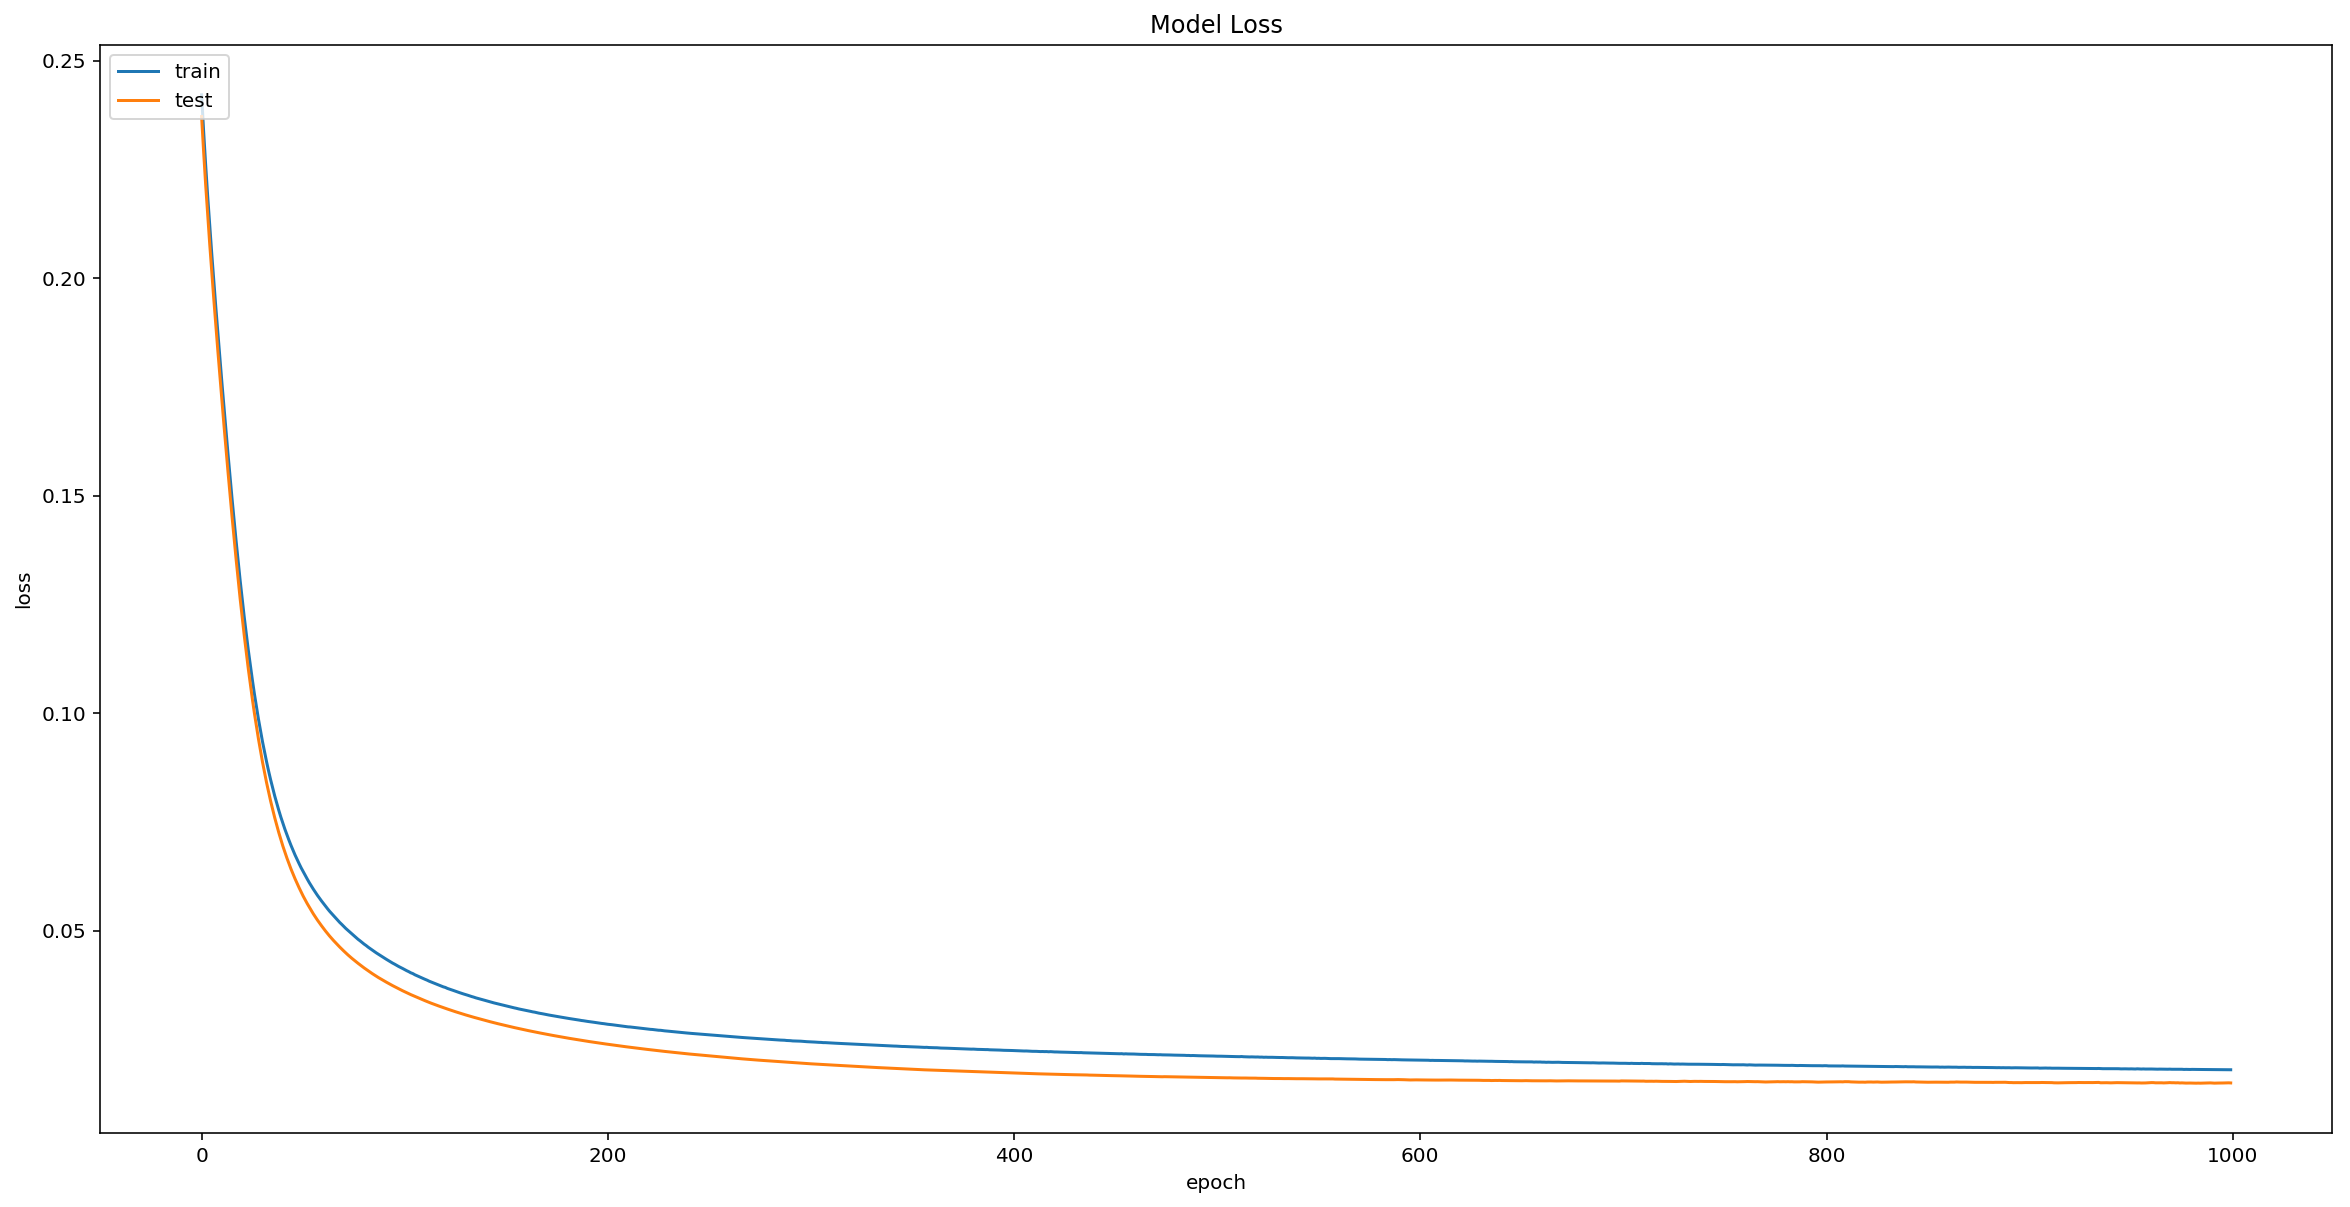

Memory Usage 1.04 MB
Time of Processing 47.33s
Accuracy 97.08%


In [28]:
show_info(model5, X_test_norm, y_test, keras_history5)

## Respostas da questão 2

In [35]:
# Building the model 6
model6 = Sequential()
model6.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model6.add(Dense(64, activation='tanh'))
model6.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model6.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model6.summary()

# Training the model 6
keras_history6 = KerasHistory()
memory_usage = monitor(target=train(model6, X_train_norm, y_train, keras_history6, epochs=200, batch_size=100))
keras_history6.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2498 - acc: 0.6101 - val_loss: 0.2494 - val_acc: 0.6125
Epoch 2/200
 - 0s - loss: 0.2486 - acc: 0.6101 - val_loss: 0.2481 - val_acc: 0.6125
Epoch 3/200
 - 0s - loss: 0.2474 - acc: 0.6101 - val_loss: 0.2469 - val_acc: 0.6125
Epoch 4/200
 - 0s - loss: 0.2462 - acc: 0.6101 - val_loss: 0.2458 - val_acc: 0.6125
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.1710 - acc: 0.8333 - val_loss: 0.1701 - val_acc: 0.8125
Epoch 90/200
 - 0s - loss: 0.1702 - acc: 0.8365 - val_loss: 0.1694 - val_acc: 0.8125
Epoch 91/200
 - 0s - loss: 0.1695 - acc: 0.8428 - val_loss: 0.1686 - val_acc: 0.8125
Epoch 92/200
 - 0s - loss: 0.1687 - acc: 0.8428 - val_loss: 0.1678 - val_acc: 0.8125
Epoch 93/200
 - 0s - loss: 0.1680 - acc: 0.8428 - val_loss: 0.1671 - val_acc: 0.8125
Epoch 94/200
 - 0s - loss: 0.1673 - acc: 0.8428 - val_loss: 0.1664 - val_acc: 0.8125
Epoch 95/200
 - 0s - loss: 0.1666 - acc: 0.8459 - val_loss: 0.1656 - val_acc: 0.8125
Epoch 96/200
 - 0s - loss: 0.1658 - acc: 0.8459 - val_loss: 0.1649 - val_acc: 0.8125
Epoch 97/200
 - 0s - loss: 0.1651 - acc: 0.8491 - val_loss: 0.1641 - val_acc: 0.8125
Epoch 98/200
 - 0s - loss: 0.1643 - acc: 0.8491 - val_loss: 0.1634 - val_acc: 0.8250
Epoch 99/200
 - 0s - loss: 0.1636 - acc: 0.8522 - val_loss: 0.1627 - val_acc: 0.8250
Epoch 100/200
 - 0s - loss: 0.1629 - acc: 0.8522 - val_loss: 0.16

Epoch 185/200
 - 0s - loss: 0.1122 - acc: 0.9182 - val_loss: 0.1102 - val_acc: 0.9125
Epoch 186/200
 - 0s - loss: 0.1118 - acc: 0.9182 - val_loss: 0.1097 - val_acc: 0.9125
Epoch 187/200
 - 0s - loss: 0.1113 - acc: 0.9182 - val_loss: 0.1093 - val_acc: 0.9125
Epoch 188/200
 - 0s - loss: 0.1109 - acc: 0.9182 - val_loss: 0.1088 - val_acc: 0.9125
Epoch 189/200
 - 0s - loss: 0.1104 - acc: 0.9182 - val_loss: 0.1083 - val_acc: 0.9125
Epoch 190/200
 - 0s - loss: 0.1100 - acc: 0.9214 - val_loss: 0.1079 - val_acc: 0.9125
Epoch 191/200
 - 0s - loss: 0.1096 - acc: 0.9214 - val_loss: 0.1075 - val_acc: 0.9125
Epoch 192/200
 - 0s - loss: 0.1092 - acc: 0.9214 - val_loss: 0.1070 - val_acc: 0.9125
Epoch 193/200
 - 0s - loss: 0.1087 - acc: 0.9214 - val_loss: 0.1065 - val_acc: 0.9125
Epoch 194/200
 - 0s - loss: 0.1083 - acc: 0.9214 - val_loss: 0.1061 - val_acc: 0.9125
Epoch 195/200
 - 0s - loss: 0.1079 - acc: 0.9214 - val_loss: 0.1057 - val_acc: 0.9125
Epoch 196/200
 - 0s - loss: 0.1075 - acc: 0.9214 - val

## Treinamento 6
Para o treinamento 6 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 100

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

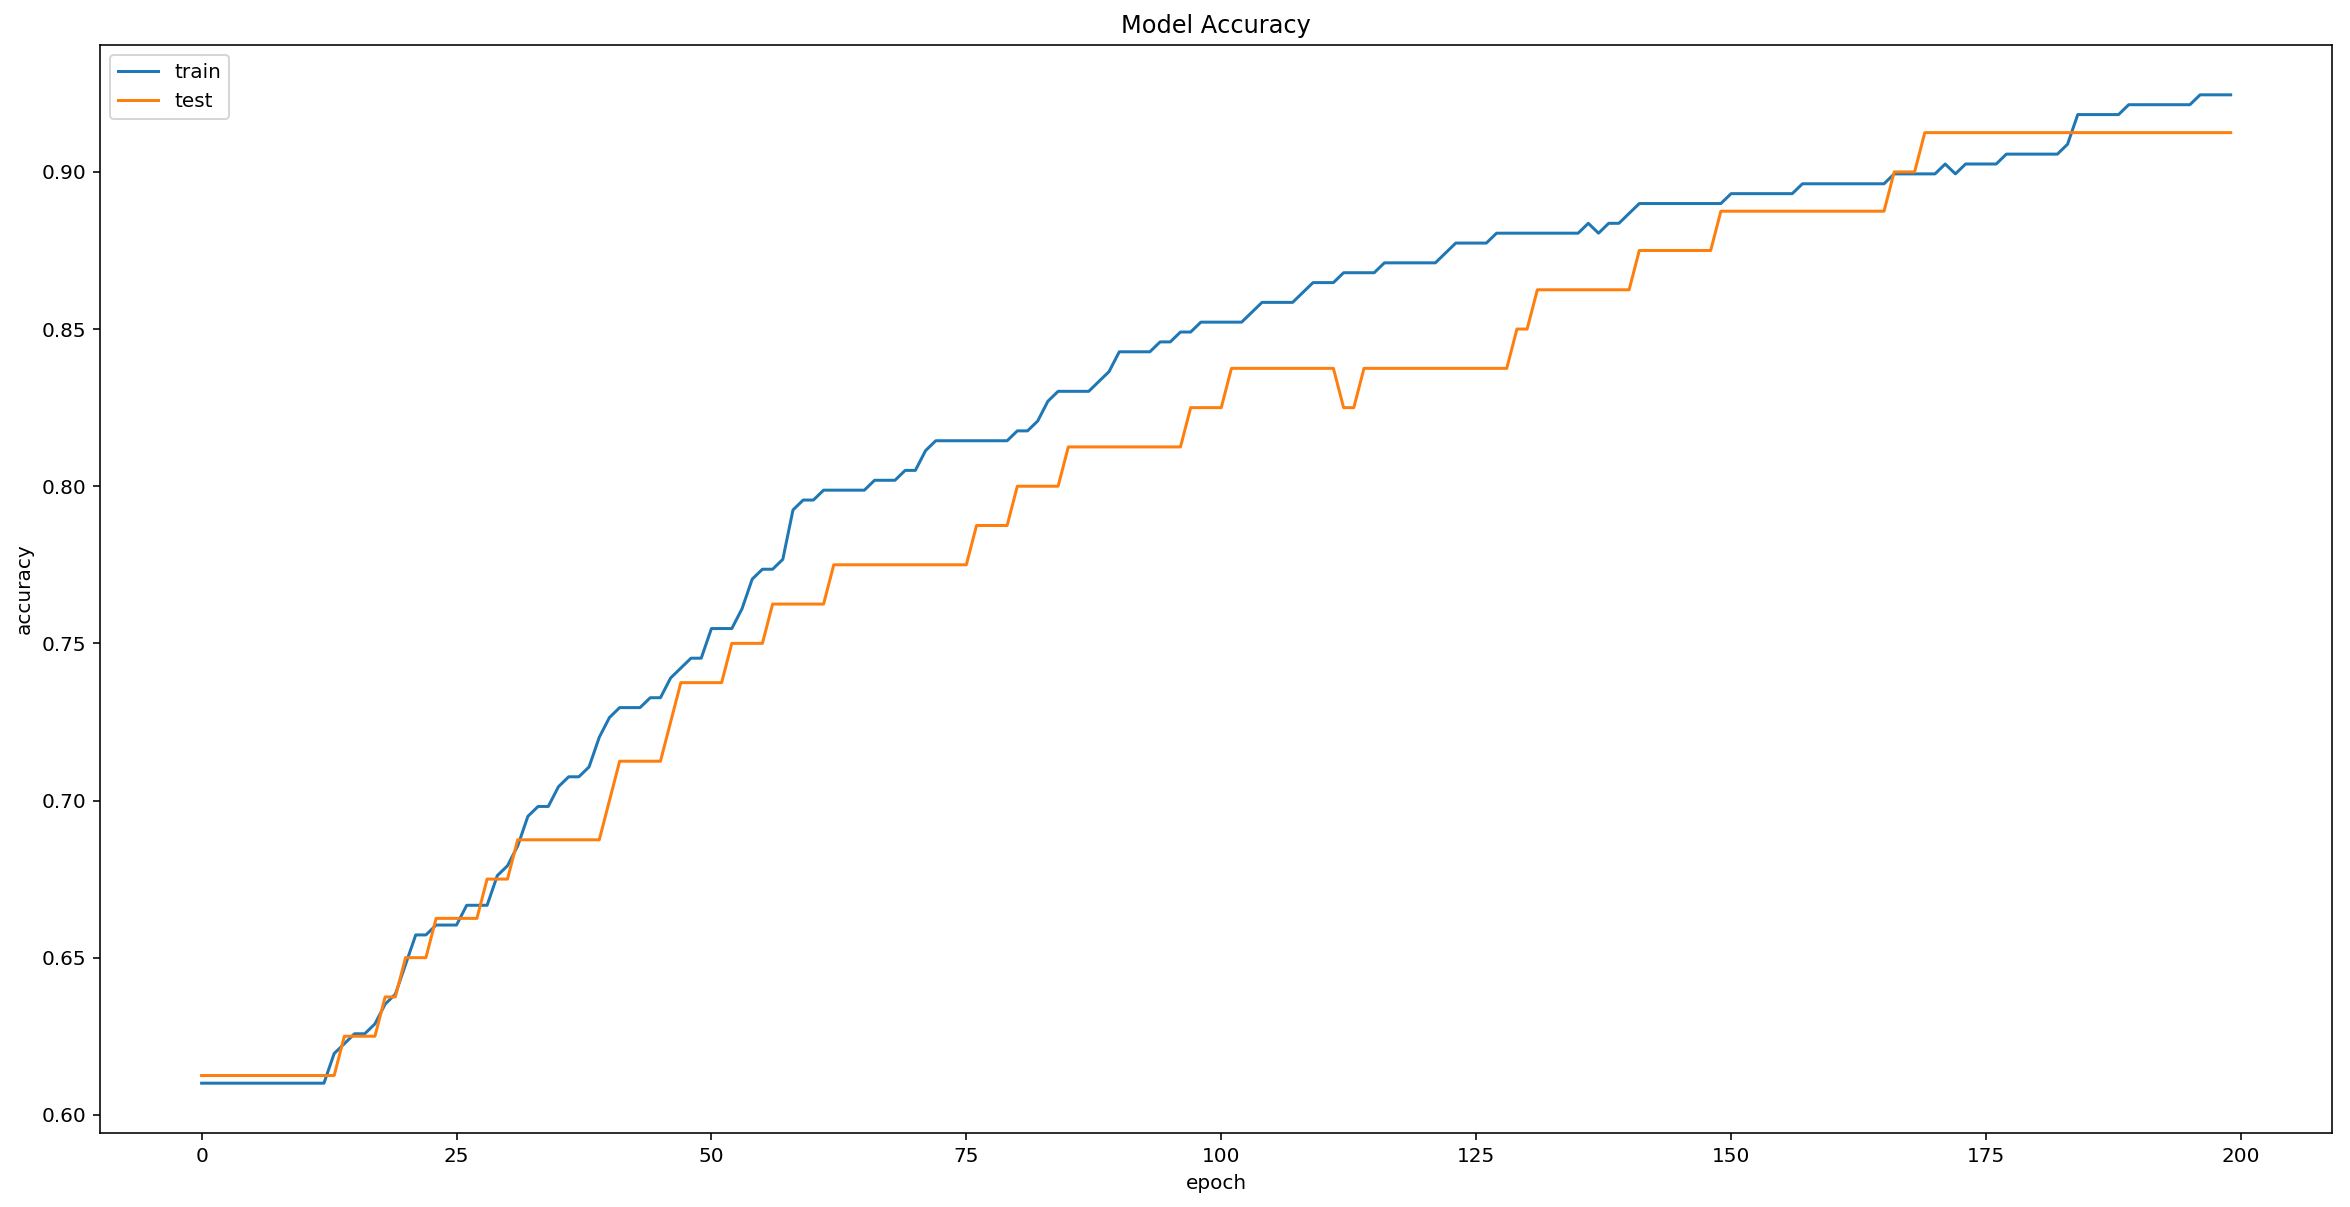

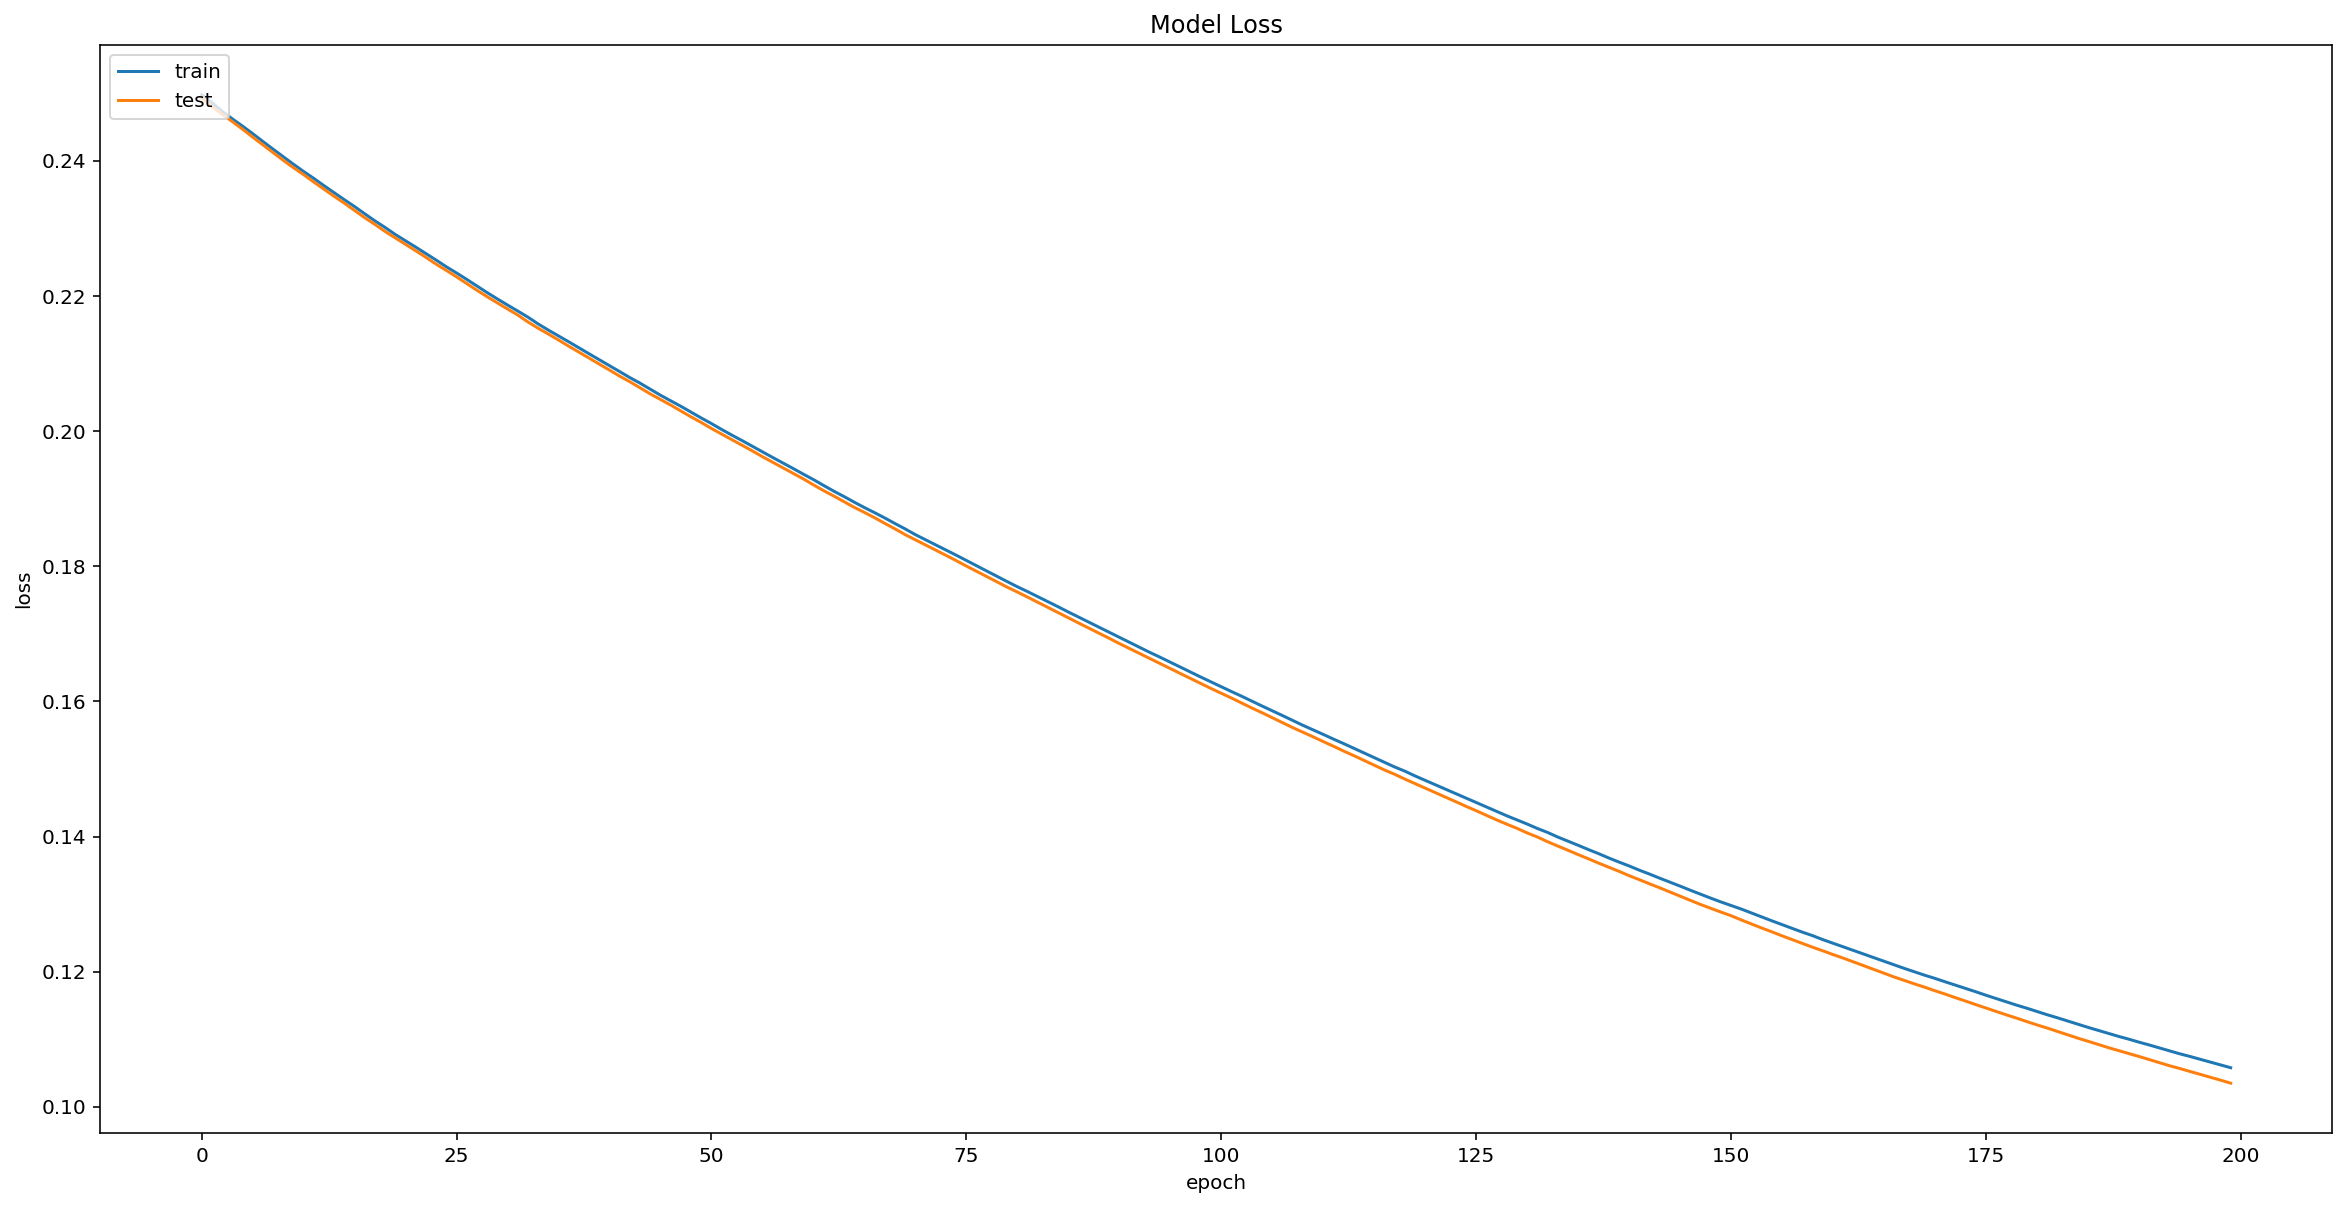

Memory Usage 1.47 MB
Time of Processing 2.36s
Accuracy 94.74%


In [36]:
show_info(model6, X_test_norm, y_test, keras_history6)

In [37]:
# Building the model 7
model7 = Sequential()
model7.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model7.add(Dense(64, activation='tanh'))
model7.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model7.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model7.summary()

# Training the model 7
keras_history7 = KerasHistory()
memory_usage = monitor(target=train(model7, X_train_norm, y_train, keras_history7, epochs=200, batch_size=80))
keras_history7.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2525 - acc: 0.3899 - val_loss: 0.2527 - val_acc: 0.3875
Epoch 2/200
 - 0s - loss: 0.2512 - acc: 0.3899 - val_loss: 0.2514 - val_acc: 0.3875
Epoch 3/200
 - 0s - loss: 0.2499 - acc: 0.3994 - val_loss: 0.2501 - val_acc: 0.4250
Epoch 4/200
 - 0s - loss: 0.2486 - acc: 0.4340 - val_loss: 0.2488 - val_acc: 0.4625
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.1721 - acc: 0.8428 - val_loss: 0.1717 - val_acc: 0.8125
Epoch 90/200
 - 0s - loss: 0.1713 - acc: 0.8491 - val_loss: 0.1709 - val_acc: 0.8250
Epoch 91/200
 - 0s - loss: 0.1706 - acc: 0.8491 - val_loss: 0.1702 - val_acc: 0.8250
Epoch 92/200
 - 0s - loss: 0.1698 - acc: 0.8491 - val_loss: 0.1695 - val_acc: 0.8250
Epoch 93/200
 - 0s - loss: 0.1691 - acc: 0.8491 - val_loss: 0.1687 - val_acc: 0.8250
Epoch 94/200
 - 0s - loss: 0.1684 - acc: 0.8491 - val_loss: 0.1680 - val_acc: 0.8250
Epoch 95/200
 - 0s - loss: 0.1677 - acc: 0.8491 - val_loss: 0.1673 - val_acc: 0.8375
Epoch 96/200
 - 0s - loss: 0.1669 - acc: 0.8491 - val_loss: 0.1665 - val_acc: 0.8375
Epoch 97/200
 - 0s - loss: 0.1662 - acc: 0.8491 - val_loss: 0.1658 - val_acc: 0.8375
Epoch 98/200
 - 0s - loss: 0.1655 - acc: 0.8491 - val_loss: 0.1651 - val_acc: 0.8375
Epoch 99/200
 - 0s - loss: 0.1648 - acc: 0.8491 - val_loss: 0.1643 - val_acc: 0.8375
Epoch 100/200
 - 0s - loss: 0.1641 - acc: 0.8491 - val_loss: 0.16

Epoch 185/200
 - 0s - loss: 0.1138 - acc: 0.9088 - val_loss: 0.1122 - val_acc: 0.9125
Epoch 186/200
 - 0s - loss: 0.1133 - acc: 0.9088 - val_loss: 0.1117 - val_acc: 0.9125
Epoch 187/200
 - 0s - loss: 0.1128 - acc: 0.9119 - val_loss: 0.1112 - val_acc: 0.9125
Epoch 188/200
 - 0s - loss: 0.1124 - acc: 0.9151 - val_loss: 0.1107 - val_acc: 0.9125
Epoch 189/200
 - 0s - loss: 0.1119 - acc: 0.9151 - val_loss: 0.1103 - val_acc: 0.9125
Epoch 190/200
 - 0s - loss: 0.1115 - acc: 0.9151 - val_loss: 0.1098 - val_acc: 0.9125
Epoch 191/200
 - 0s - loss: 0.1111 - acc: 0.9151 - val_loss: 0.1094 - val_acc: 0.9125
Epoch 192/200
 - 0s - loss: 0.1106 - acc: 0.9151 - val_loss: 0.1089 - val_acc: 0.9125
Epoch 193/200
 - 0s - loss: 0.1102 - acc: 0.9151 - val_loss: 0.1084 - val_acc: 0.9125
Epoch 194/200
 - 0s - loss: 0.1097 - acc: 0.9151 - val_loss: 0.1080 - val_acc: 0.9125
Epoch 195/200
 - 0s - loss: 0.1093 - acc: 0.9151 - val_loss: 0.1075 - val_acc: 0.9125
Epoch 196/200
 - 0s - loss: 0.1089 - acc: 0.9151 - val

## Treinamento 7
Para o treinamento 7 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 80

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

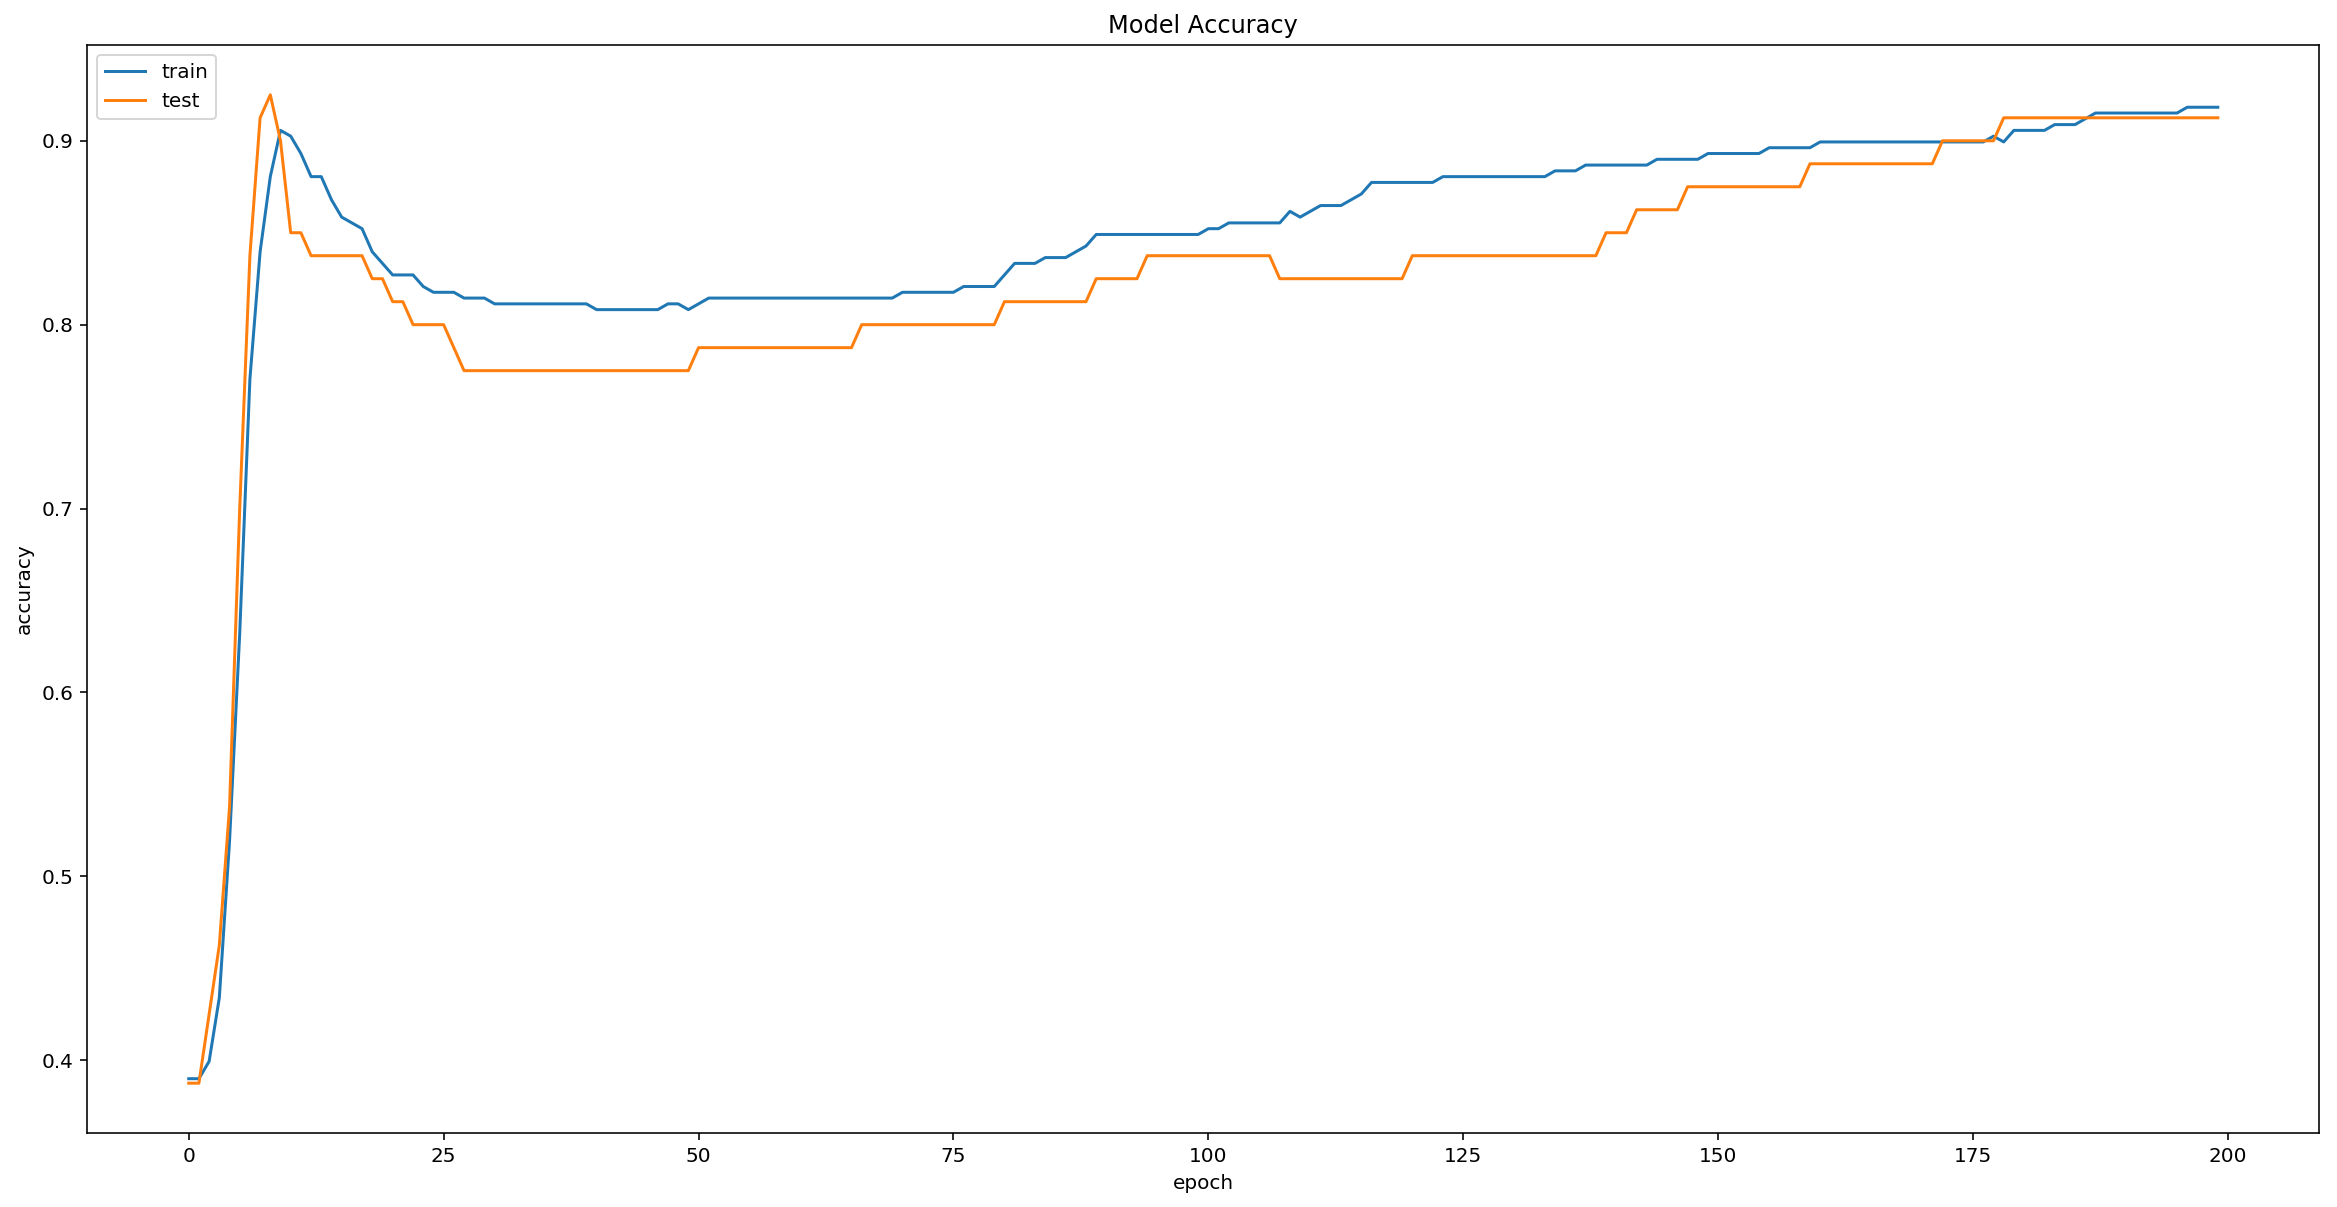

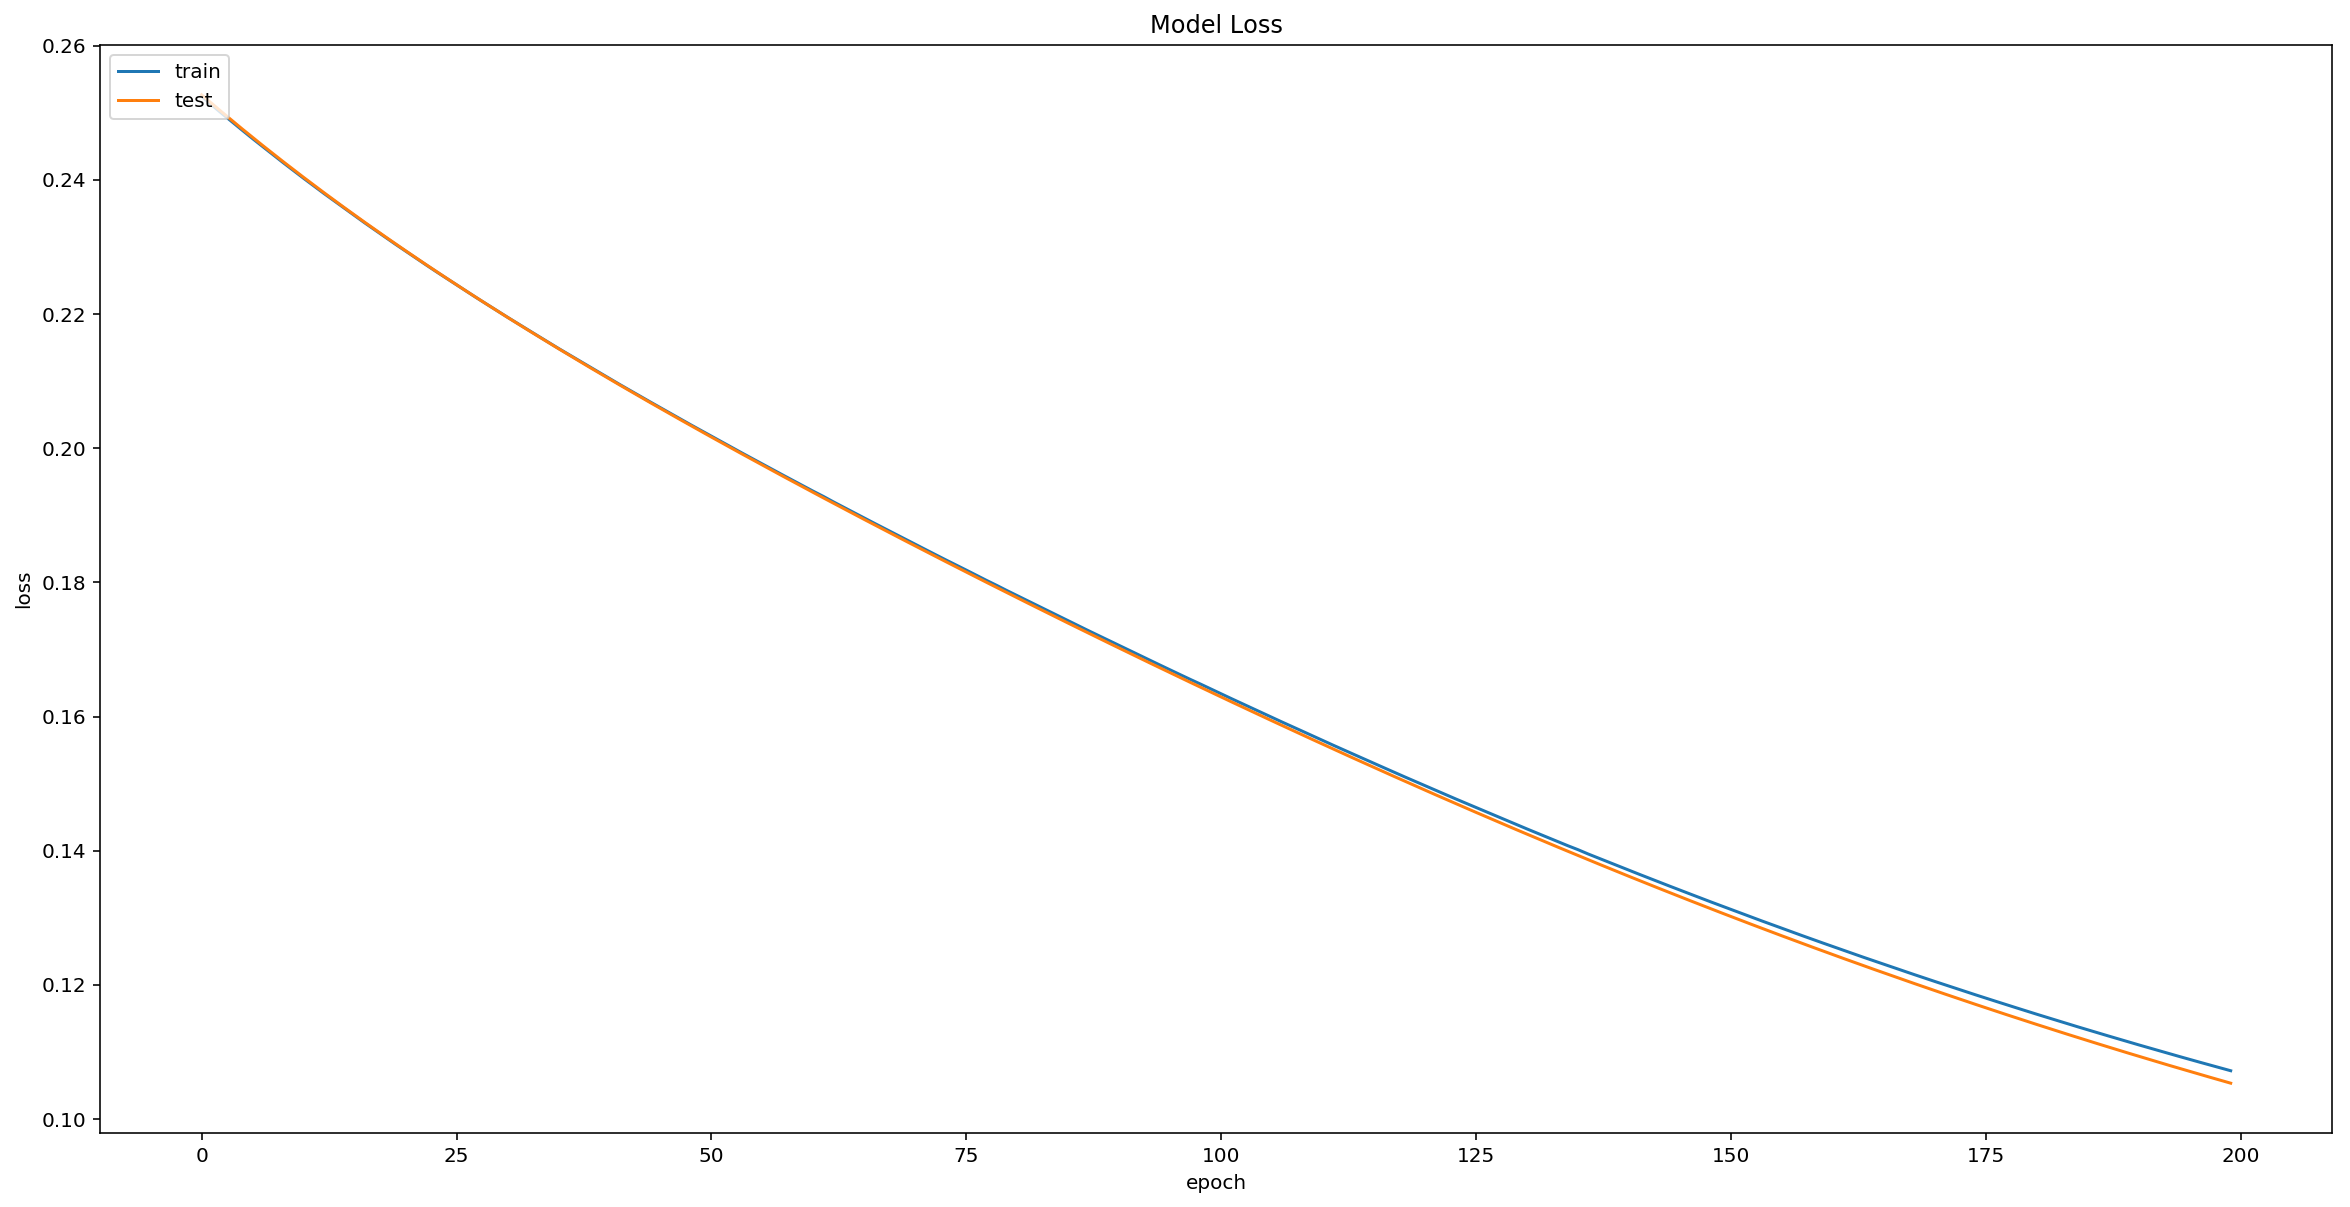

Memory Usage 1.16 MB
Time of Processing 2.20s
Accuracy 94.74%


In [38]:
show_info(model7, X_test_norm, y_test, keras_history7)

In [39]:
# Building the model 8
model8 = Sequential()
model8.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model8.add(Dense(64, activation='tanh'))
model8.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model8.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model8.summary()

# Training the model 8
keras_history8 = KerasHistory()
memory_usage = monitor(target=train(model8, X_train_norm, y_train, keras_history8, epochs=200, batch_size=60))
keras_history8.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2491 - acc: 0.4088 - val_loss: 0.2491 - val_acc: 0.4000
Epoch 2/200
 - 0s - loss: 0.2477 - acc: 0.4623 - val_loss: 0.2477 - val_acc: 0.4375
Epoch 3/200
 - 0s - loss: 0.2464 - acc: 0.5157 - val_loss: 0.2463 - val_acc: 0.5500
Epoch 4/200
 - 0s - loss: 0.2450 - acc: 0.5943 - val_loss: 0.2449 - val_acc: 0.6750
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.1590 - acc: 0.8648 - val_loss: 0.1581 - val_acc: 0.8375
Epoch 90/200
 - 0s - loss: 0.1581 - acc: 0.8648 - val_loss: 0.1572 - val_acc: 0.8375
Epoch 91/200
 - 0s - loss: 0.1572 - acc: 0.8648 - val_loss: 0.1562 - val_acc: 0.8500
Epoch 92/200
 - 0s - loss: 0.1562 - acc: 0.8648 - val_loss: 0.1553 - val_acc: 0.8500
Epoch 93/200
 - 0s - loss: 0.1553 - acc: 0.8648 - val_loss: 0.1544 - val_acc: 0.8500
Epoch 94/200
 - 0s - loss: 0.1544 - acc: 0.8648 - val_loss: 0.1534 - val_acc: 0.8500
Epoch 95/200
 - 0s - loss: 0.1535 - acc: 0.8711 - val_loss: 0.1525 - val_acc: 0.8500
Epoch 96/200
 - 0s - loss: 0.1526 - acc: 0.8711 - val_loss: 0.1516 - val_acc: 0.8500
Epoch 97/200
 - 0s - loss: 0.1517 - acc: 0.8711 - val_loss: 0.1507 - val_acc: 0.8375
Epoch 98/200
 - 0s - loss: 0.1508 - acc: 0.8742 - val_loss: 0.1498 - val_acc: 0.8375
Epoch 99/200
 - 0s - loss: 0.1499 - acc: 0.8774 - val_loss: 0.1489 - val_acc: 0.8375
Epoch 100/200
 - 0s - loss: 0.1490 - acc: 0.8774 - val_loss: 0.14

Epoch 185/200
 - 0s - loss: 0.0921 - acc: 0.9277 - val_loss: 0.0892 - val_acc: 0.9375
Epoch 186/200
 - 0s - loss: 0.0917 - acc: 0.9277 - val_loss: 0.0888 - val_acc: 0.9375
Epoch 187/200
 - 0s - loss: 0.0912 - acc: 0.9277 - val_loss: 0.0883 - val_acc: 0.9375
Epoch 188/200
 - 0s - loss: 0.0908 - acc: 0.9277 - val_loss: 0.0878 - val_acc: 0.9375
Epoch 189/200
 - 0s - loss: 0.0904 - acc: 0.9277 - val_loss: 0.0874 - val_acc: 0.9375
Epoch 190/200
 - 0s - loss: 0.0900 - acc: 0.9277 - val_loss: 0.0870 - val_acc: 0.9375
Epoch 191/200
 - 0s - loss: 0.0896 - acc: 0.9277 - val_loss: 0.0865 - val_acc: 0.9375
Epoch 192/200
 - 0s - loss: 0.0891 - acc: 0.9277 - val_loss: 0.0861 - val_acc: 0.9375
Epoch 193/200
 - 0s - loss: 0.0887 - acc: 0.9308 - val_loss: 0.0857 - val_acc: 0.9375
Epoch 194/200
 - 0s - loss: 0.0883 - acc: 0.9308 - val_loss: 0.0853 - val_acc: 0.9375
Epoch 195/200
 - 0s - loss: 0.0879 - acc: 0.9308 - val_loss: 0.0848 - val_acc: 0.9375
Epoch 196/200
 - 0s - loss: 0.0875 - acc: 0.9308 - val

## Treinamento 8
Para o treinamento 8 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 60

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

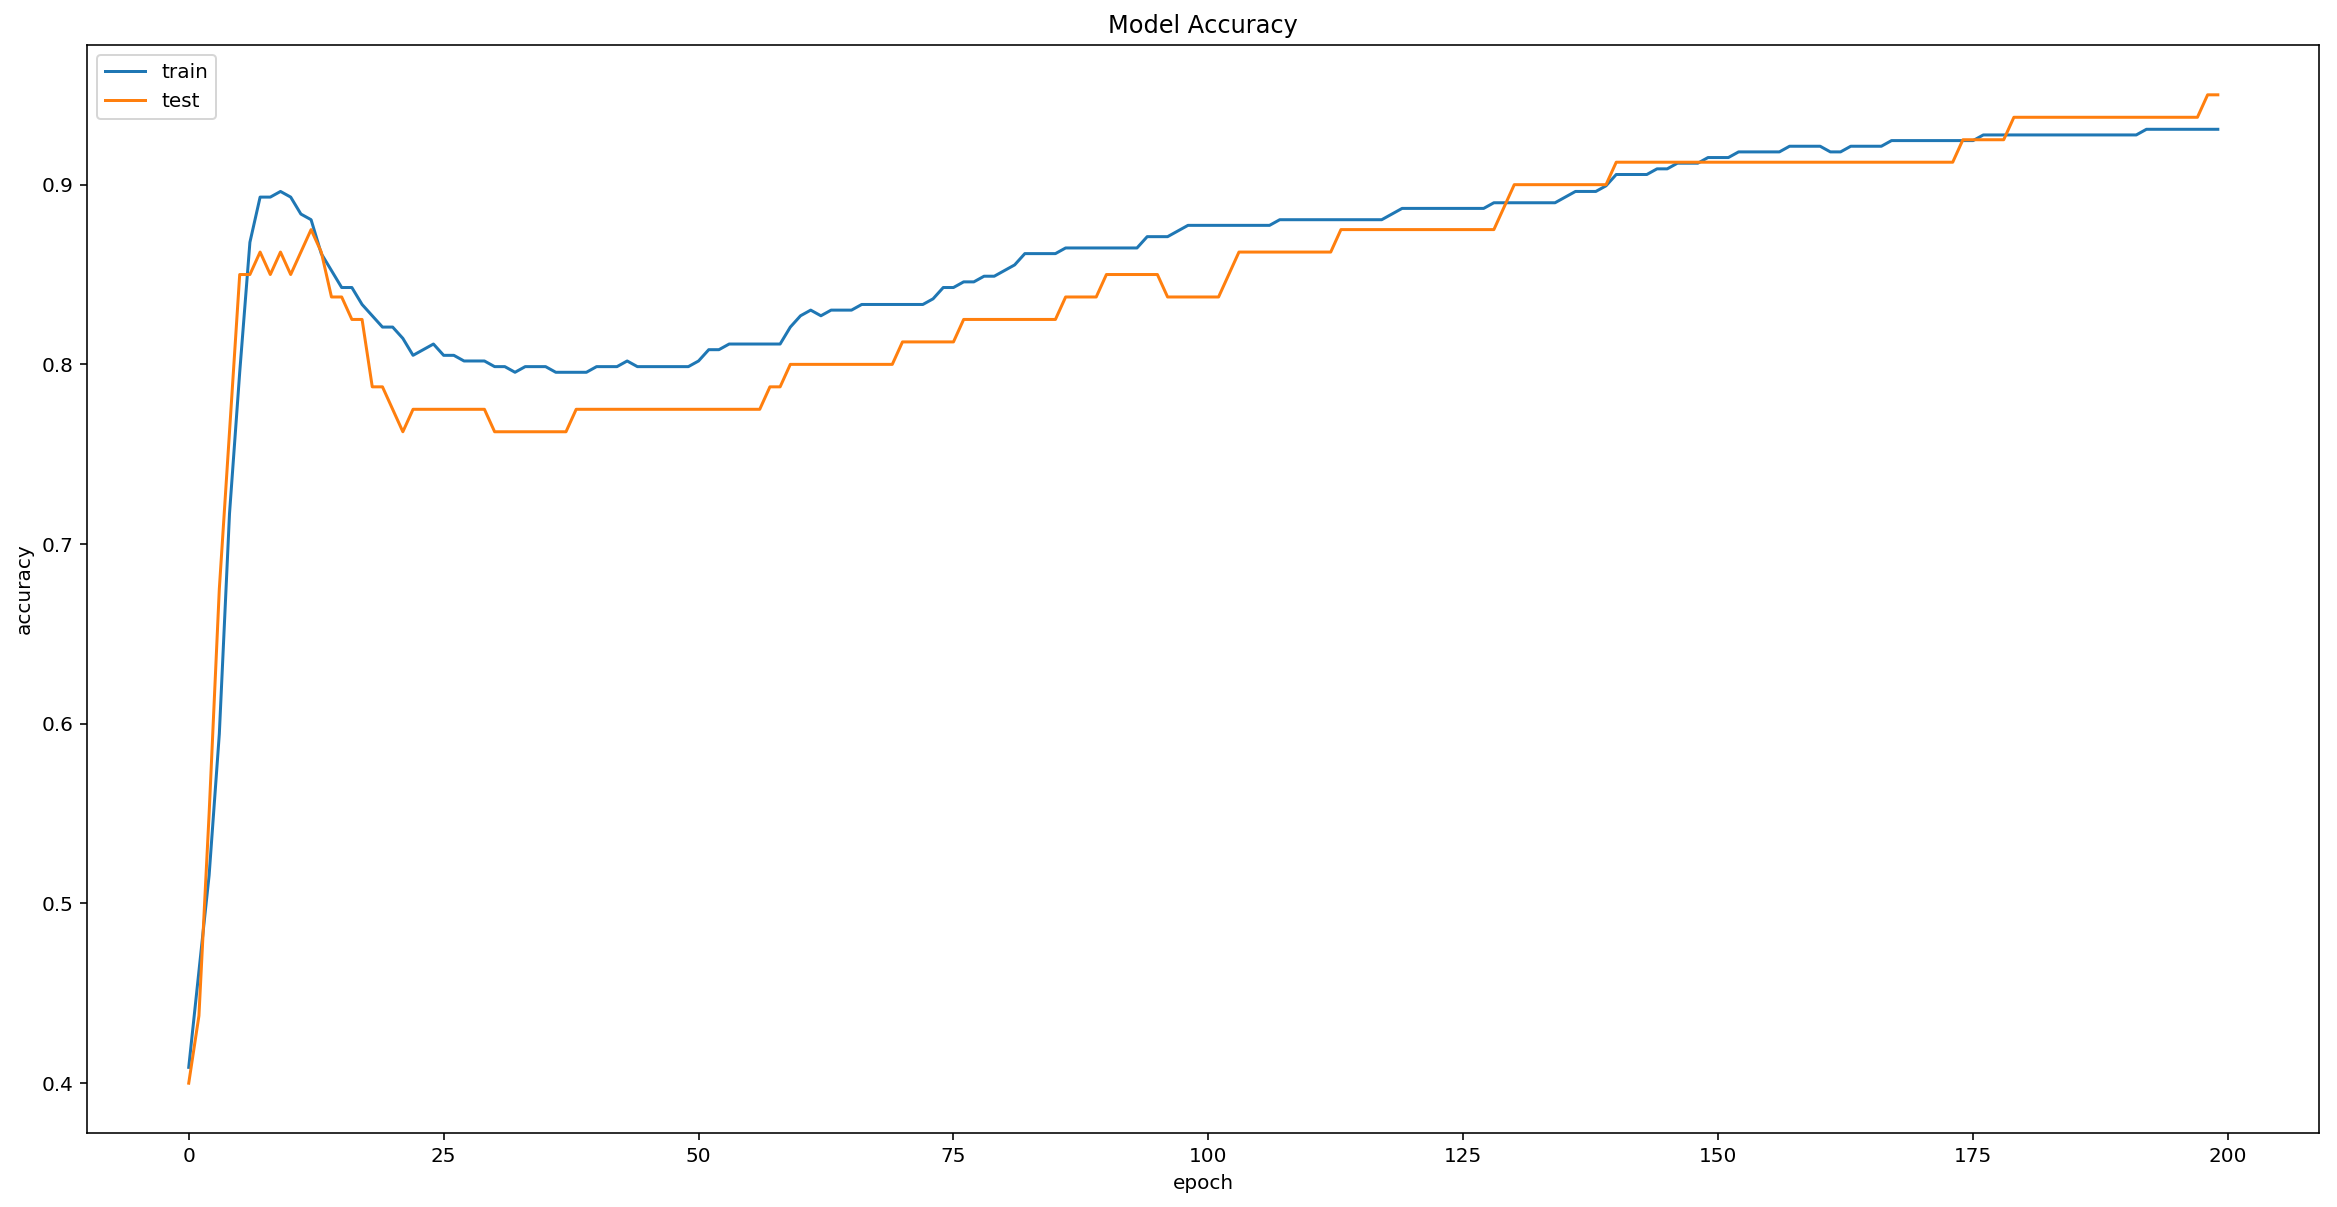

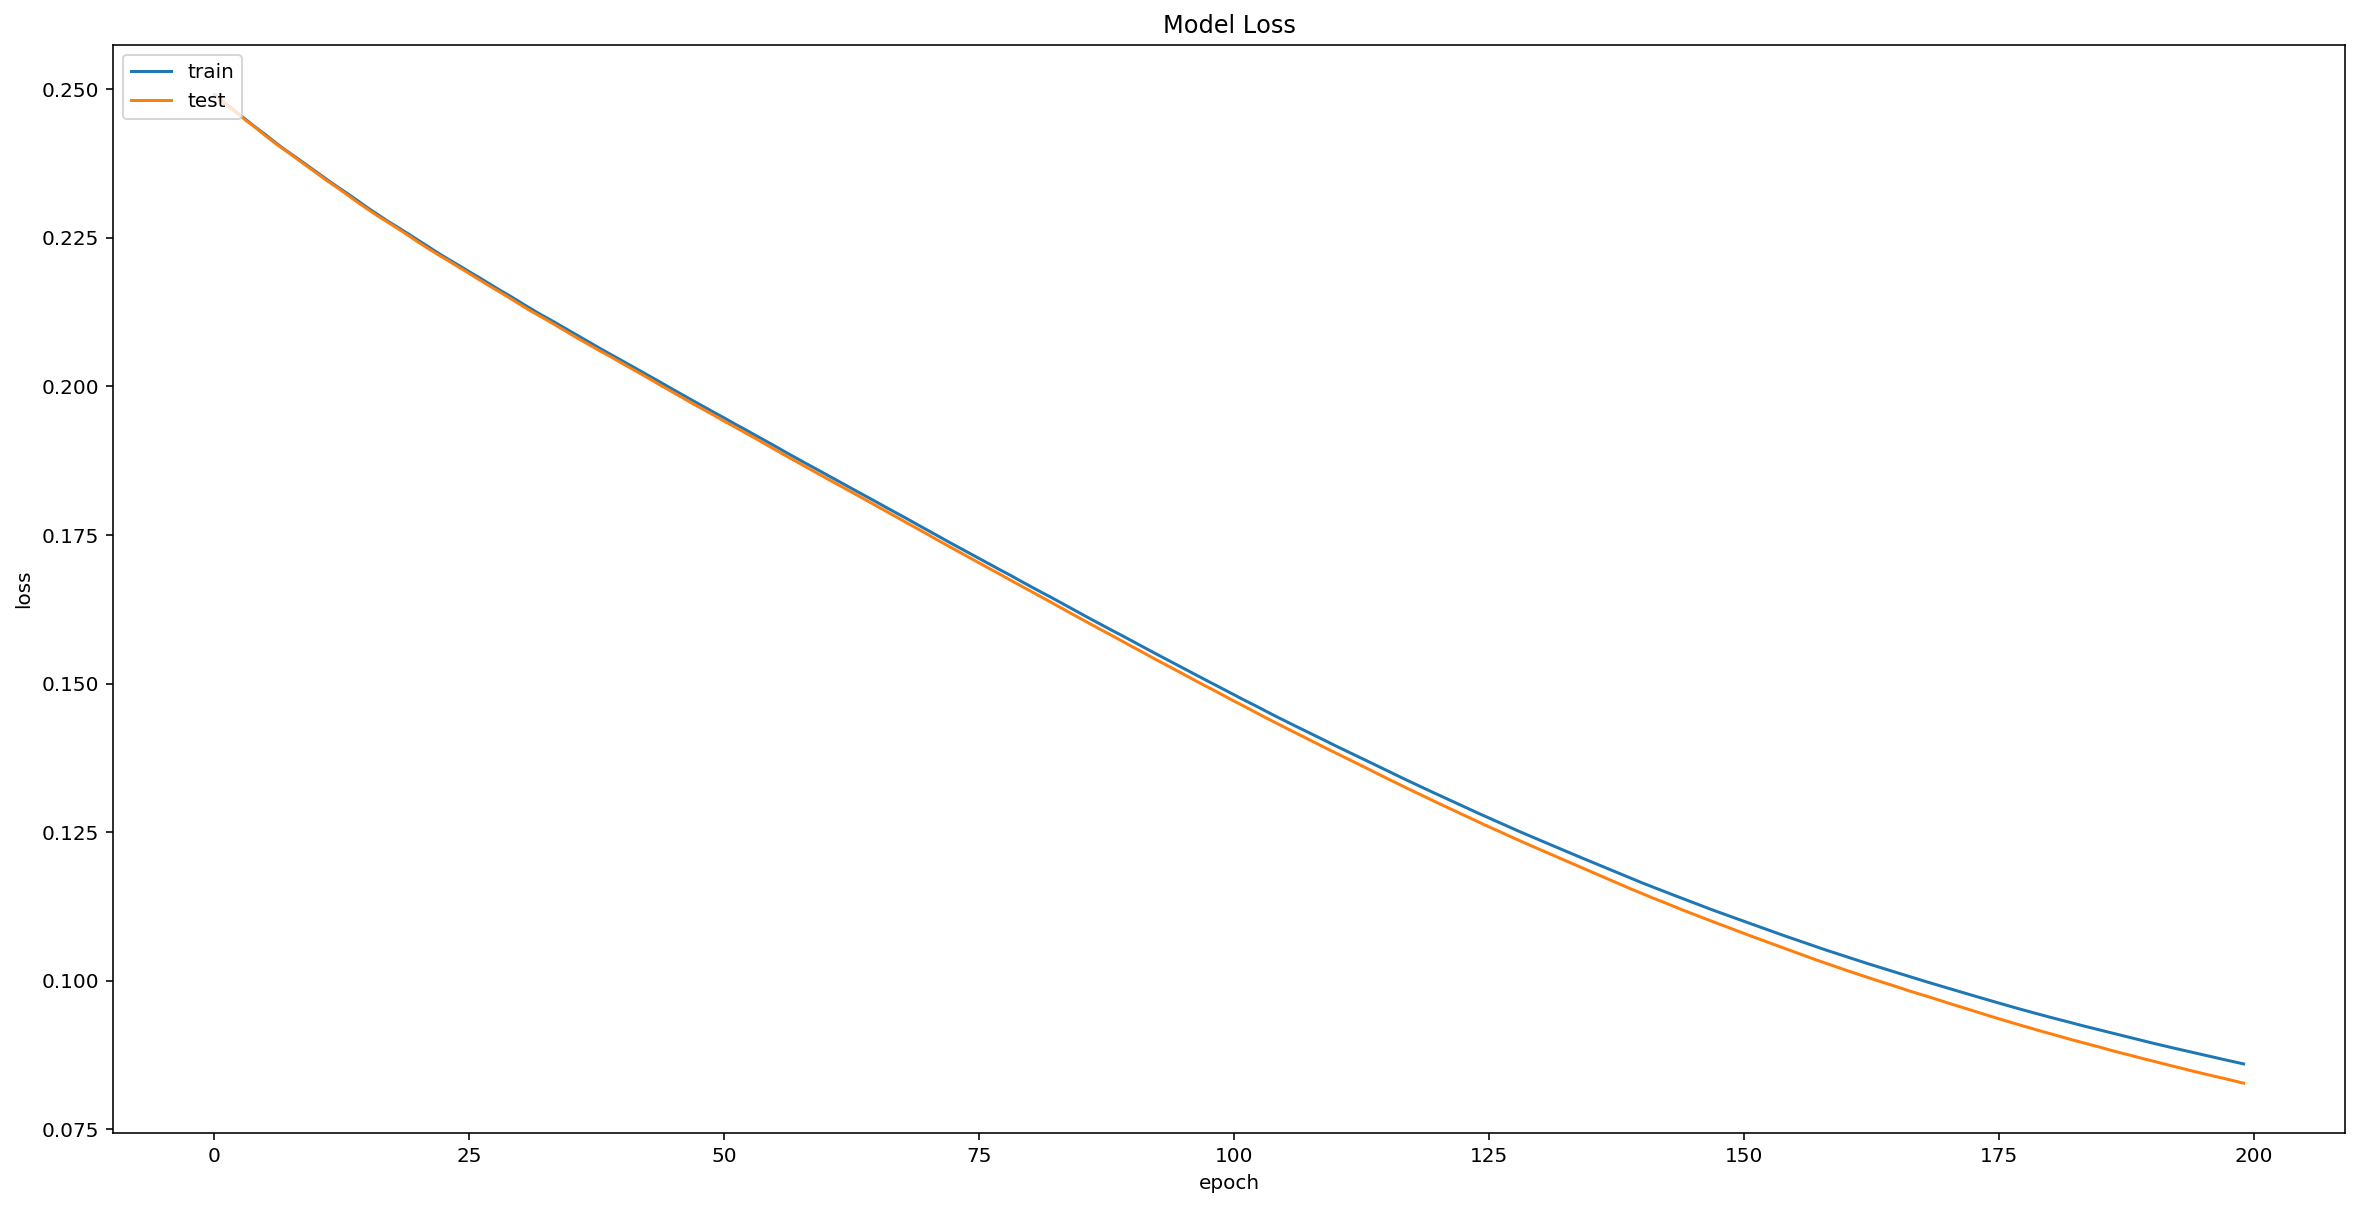

Memory Usage 1.05 MB
Time of Processing 3.13s
Accuracy 94.15%


In [41]:
show_info(model8, X_test_norm, y_test, keras_history8)

In [42]:
# Building the model 9
model9 = Sequential()
model9.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model9.add(Dense(64, activation='tanh'))
model9.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model9.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model9.summary()

# Training the model 9
keras_history9 = KerasHistory()
memory_usage = monitor(target=train(model9, X_train_norm, y_train, keras_history9, epochs=200, batch_size=30))
keras_history9.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2546 - acc: 0.3396 - val_loss: 0.2519 - val_acc: 0.2875
Epoch 2/200
 - 0s - loss: 0.2510 - acc: 0.4245 - val_loss: 0.2484 - val_acc: 0.6125
Epoch 3/200
 - 0s - loss: 0.2476 - acc: 0.6950 - val_loss: 0.2450 - val_acc: 0.7875
Epoch 4/200
 - 0s - loss: 0.2443 - acc: 0.7358 - val_loss: 0.2416 - val_acc: 0.7875
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0922 - acc: 0.9308 - val_loss: 0.0884 - val_acc: 0.9375
Epoch 90/200
 - 0s - loss: 0.0913 - acc: 0.9308 - val_loss: 0.0875 - val_acc: 0.9375
Epoch 91/200
 - 0s - loss: 0.0905 - acc: 0.9308 - val_loss: 0.0867 - val_acc: 0.9375
Epoch 92/200
 - 0s - loss: 0.0897 - acc: 0.9308 - val_loss: 0.0859 - val_acc: 0.9375
Epoch 93/200
 - 0s - loss: 0.0889 - acc: 0.9308 - val_loss: 0.0851 - val_acc: 0.9375
Epoch 94/200
 - 0s - loss: 0.0882 - acc: 0.9308 - val_loss: 0.0843 - val_acc: 0.9375
Epoch 95/200
 - 0s - loss: 0.0874 - acc: 0.9308 - val_loss: 0.0835 - val_acc: 0.9375
Epoch 96/200
 - 0s - loss: 0.0867 - acc: 0.9308 - val_loss: 0.0827 - val_acc: 0.9500
Epoch 97/200
 - 0s - loss: 0.0860 - acc: 0.9308 - val_loss: 0.0820 - val_acc: 0.9500
Epoch 98/200
 - 0s - loss: 0.0853 - acc: 0.9308 - val_loss: 0.0813 - val_acc: 0.9500
Epoch 99/200
 - 0s - loss: 0.0846 - acc: 0.9308 - val_loss: 0.0806 - val_acc: 0.9500
Epoch 100/200
 - 0s - loss: 0.0840 - acc: 0.9308 - val_loss: 0.07

Epoch 185/200
 - 0s - loss: 0.0540 - acc: 0.9403 - val_loss: 0.0488 - val_acc: 0.9500
Epoch 186/200
 - 0s - loss: 0.0538 - acc: 0.9403 - val_loss: 0.0486 - val_acc: 0.9500
Epoch 187/200
 - 0s - loss: 0.0536 - acc: 0.9403 - val_loss: 0.0484 - val_acc: 0.9500
Epoch 188/200
 - 0s - loss: 0.0534 - acc: 0.9403 - val_loss: 0.0482 - val_acc: 0.9500
Epoch 189/200
 - 0s - loss: 0.0533 - acc: 0.9403 - val_loss: 0.0481 - val_acc: 0.9500
Epoch 190/200
 - 0s - loss: 0.0531 - acc: 0.9403 - val_loss: 0.0479 - val_acc: 0.9500
Epoch 191/200
 - 0s - loss: 0.0529 - acc: 0.9403 - val_loss: 0.0477 - val_acc: 0.9500
Epoch 192/200
 - 0s - loss: 0.0527 - acc: 0.9403 - val_loss: 0.0475 - val_acc: 0.9500
Epoch 193/200
 - 0s - loss: 0.0525 - acc: 0.9403 - val_loss: 0.0474 - val_acc: 0.9500
Epoch 194/200
 - 0s - loss: 0.0524 - acc: 0.9434 - val_loss: 0.0472 - val_acc: 0.9500
Epoch 195/200
 - 0s - loss: 0.0522 - acc: 0.9434 - val_loss: 0.0470 - val_acc: 0.9500
Epoch 196/200
 - 0s - loss: 0.0520 - acc: 0.9434 - val

## Treinamento 9
Para o treinamento 9 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 30

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

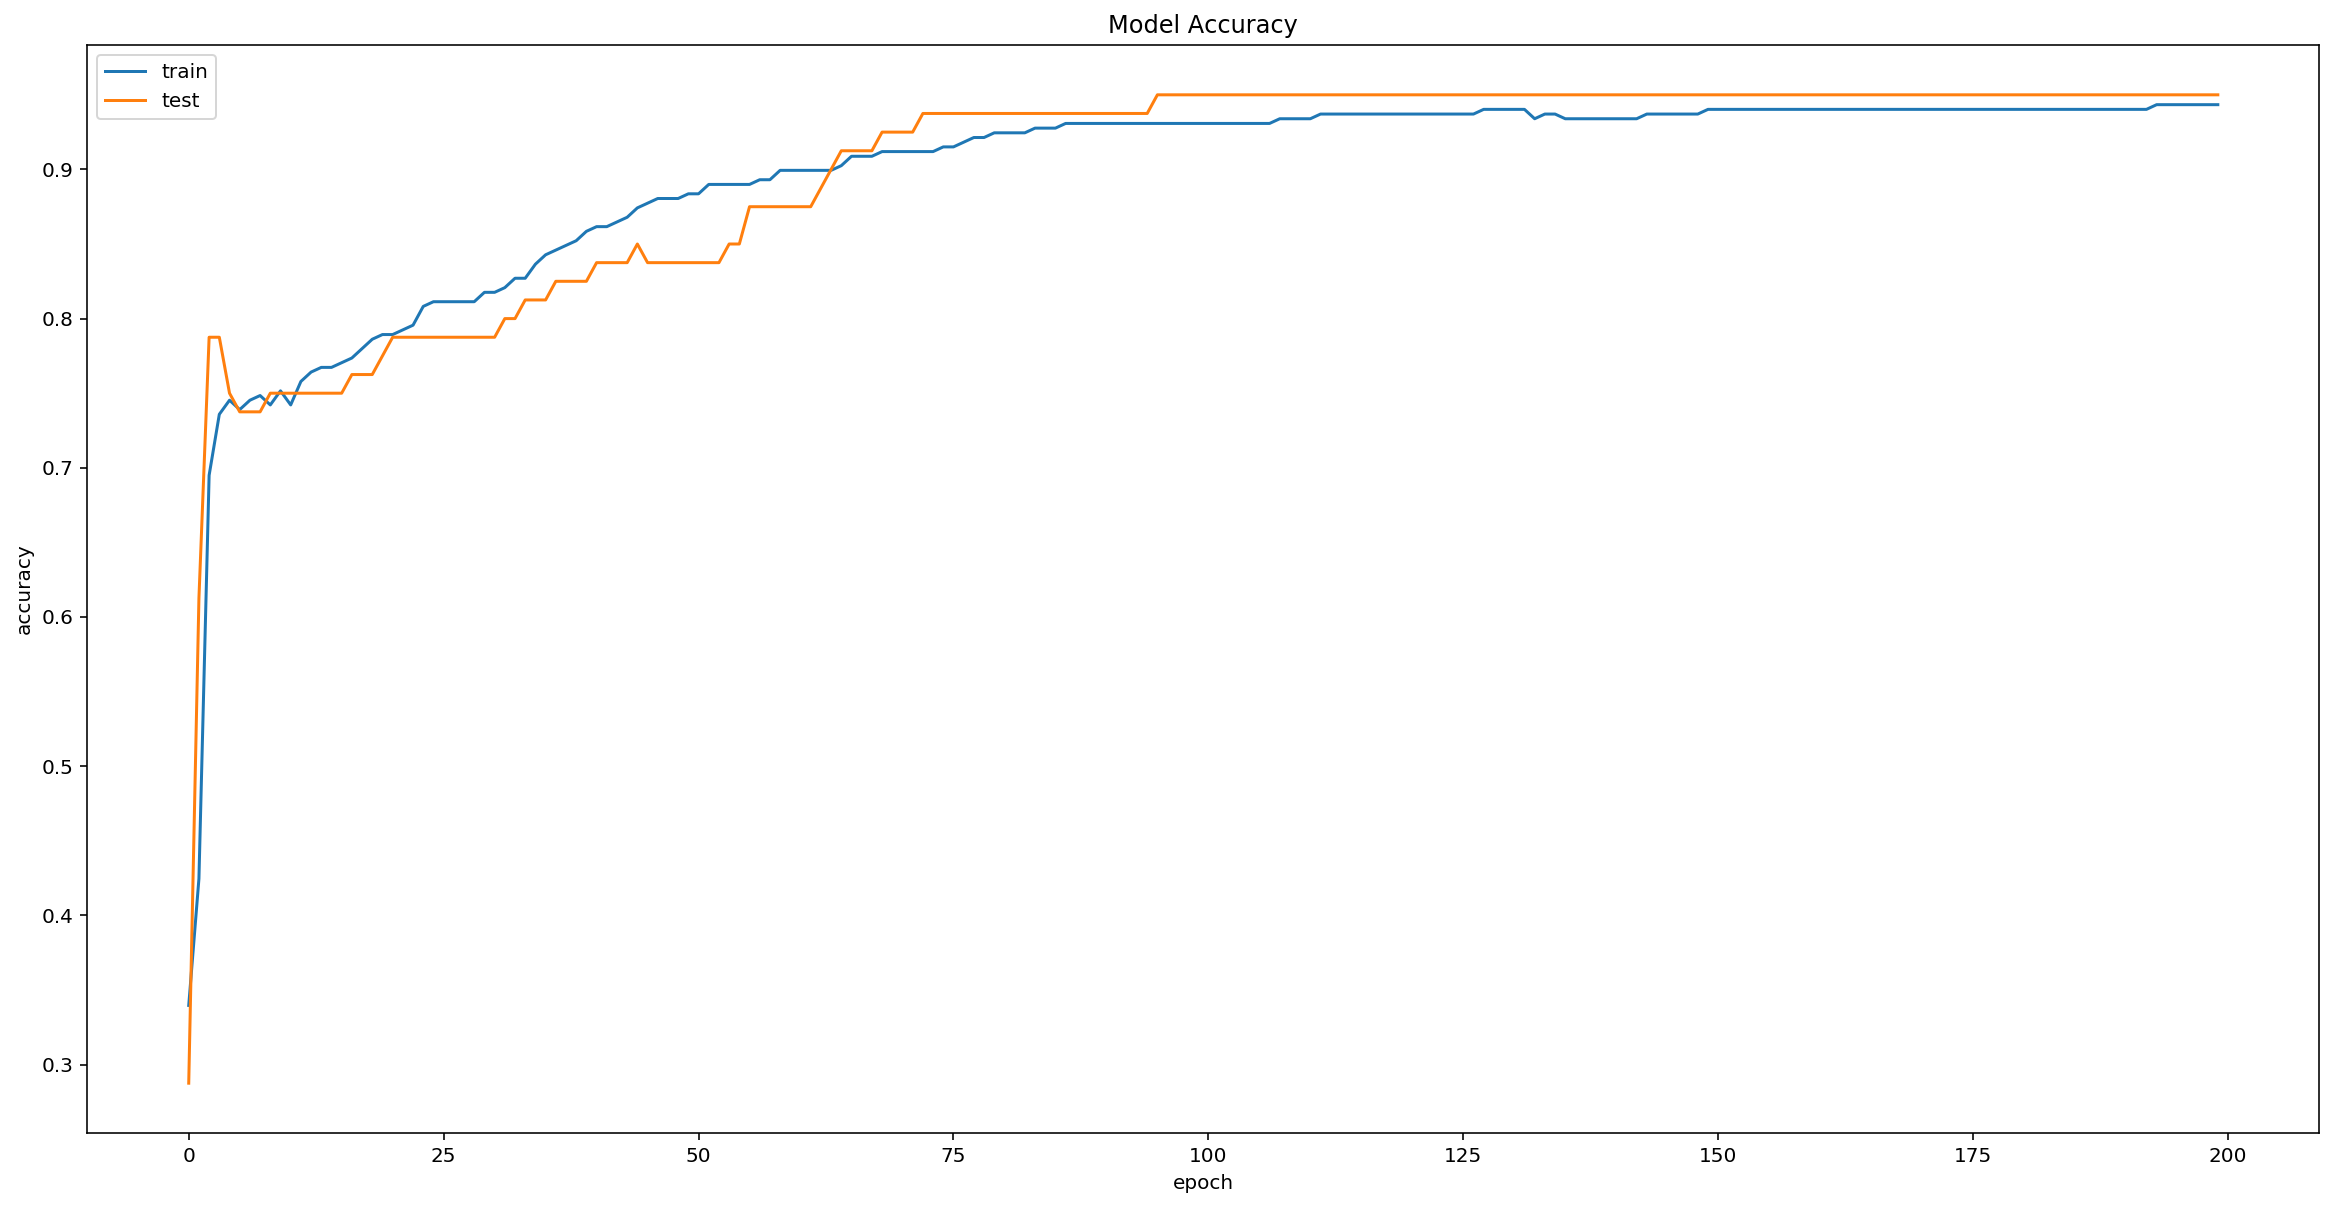

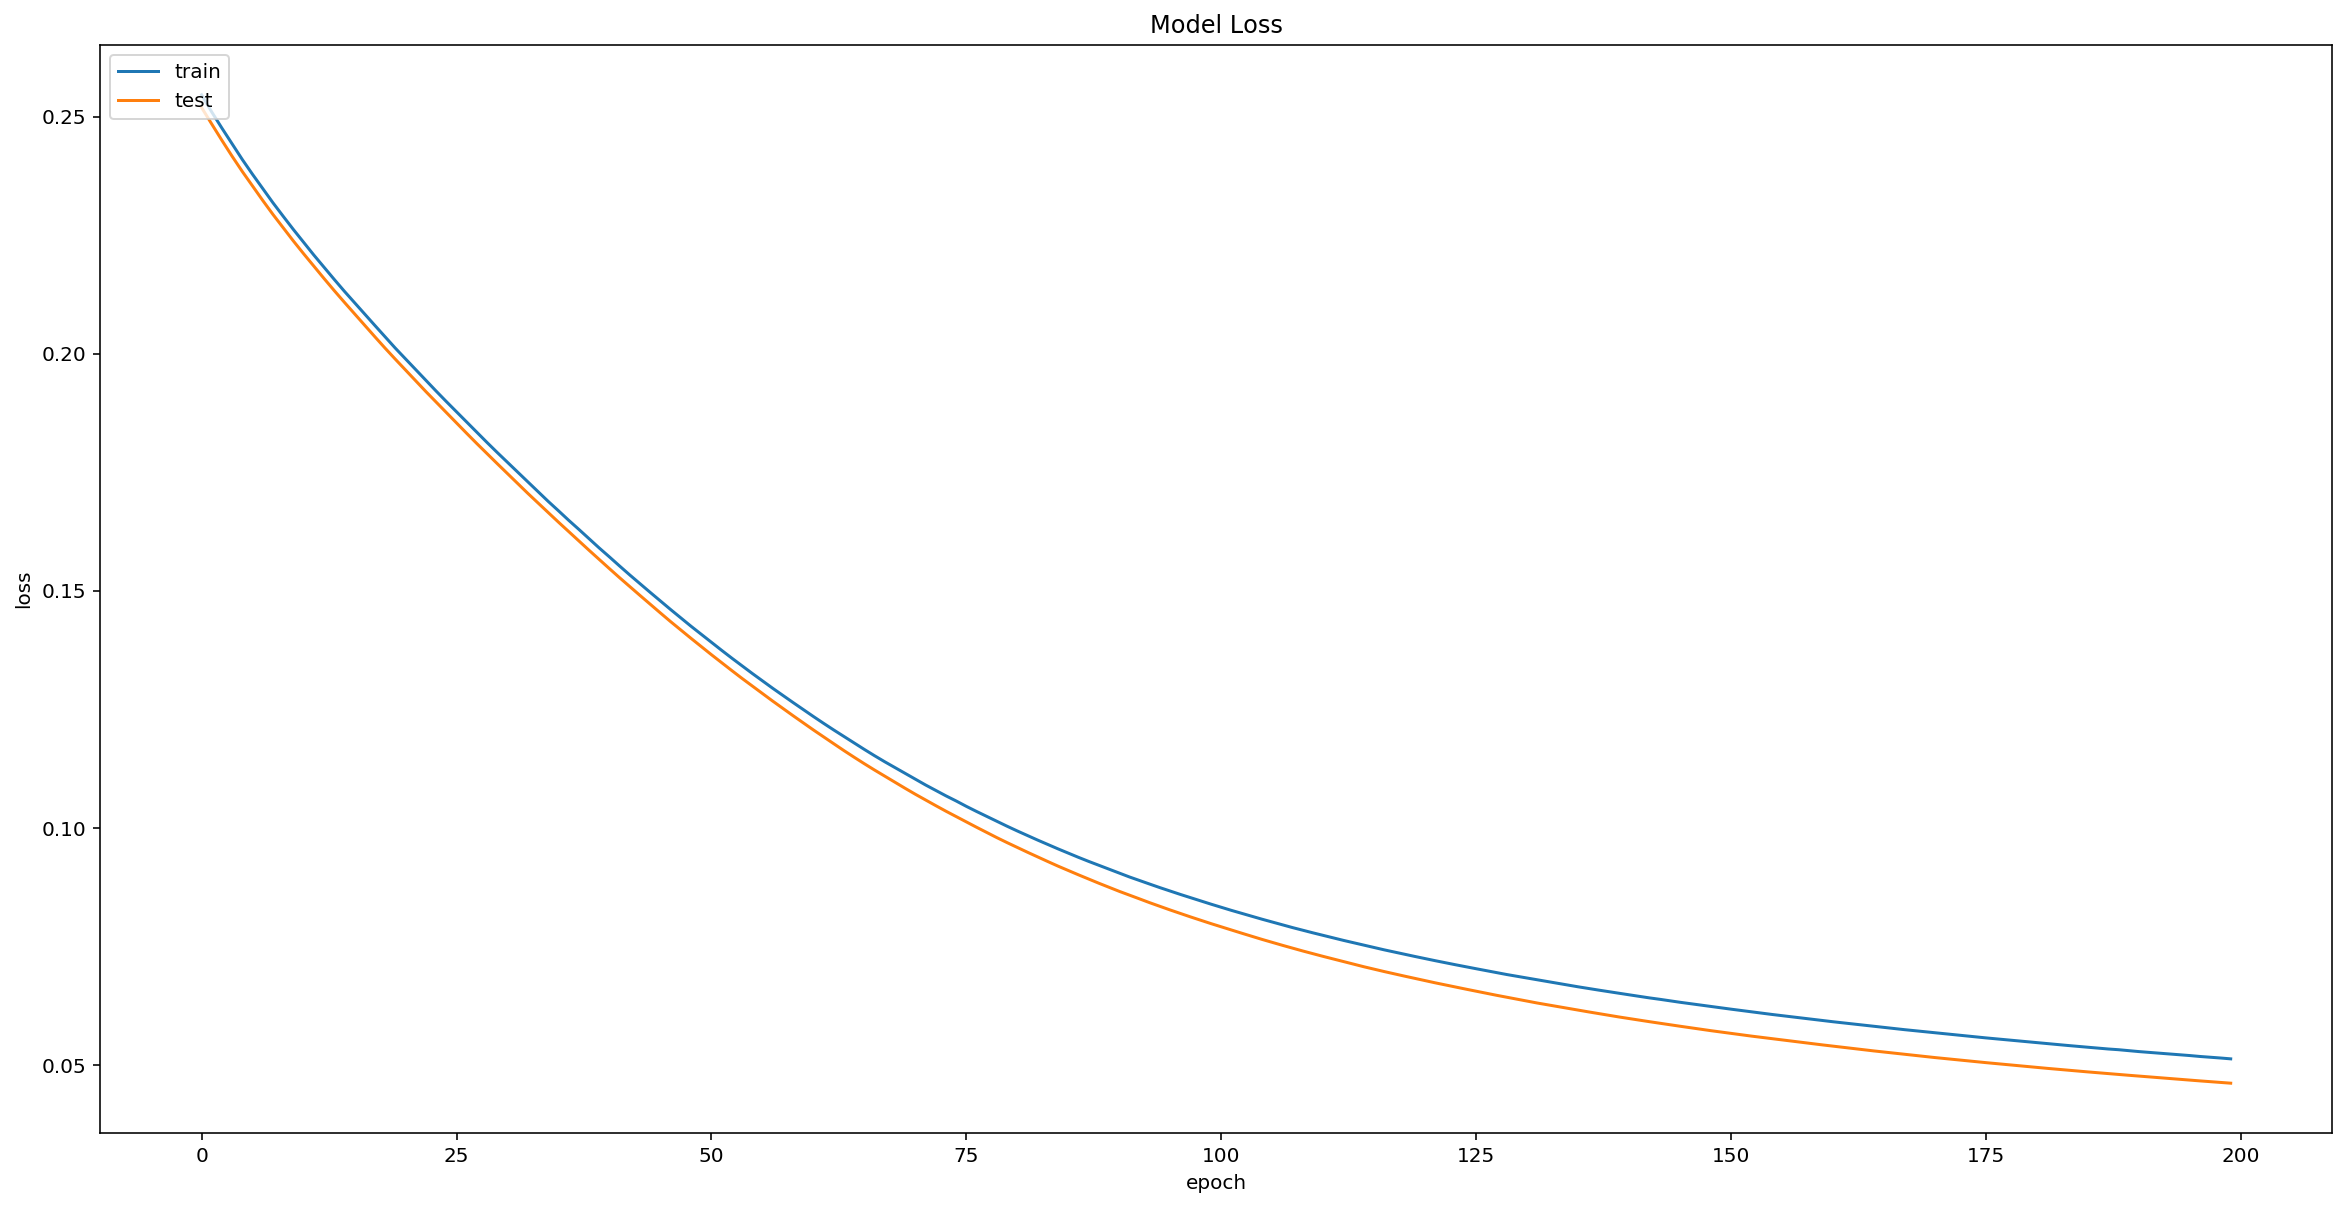

Memory Usage 0.15 MB
Time of Processing 4.50s
Accuracy 94.15%


In [43]:
show_info(model9, X_test_norm, y_test, keras_history9)

In [44]:
# Building the model 10
model10 = Sequential()
model10.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model10.add(Dense(64, activation='tanh'))
model10.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model10.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model10.summary()

# Training the model 10
keras_history10 = KerasHistory()
memory_usage = monitor(target=train(model10, X_train_norm, y_train, keras_history10, epochs=200, batch_size=15))
keras_history10.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2506 - acc: 0.5409 - val_loss: 0.2473 - val_acc: 0.6250
Epoch 2/200
 - 0s - loss: 0.2447 - acc: 0.6164 - val_loss: 0.2411 - val_acc: 0.6125
Epoch 3/200
 - 0s - loss: 0.2388 - acc: 0.6226 - val_loss: 0.2357 - val_acc: 0.6375
Epoch 4/200
 - 0s - loss: 0.2336 - acc: 0.6447 - val_loss: 0.2304 - val_acc: 0.6375
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0555 - acc: 0.9434 - val_loss: 0.0501 - val_acc: 0.9500
Epoch 90/200
 - 0s - loss: 0.0550 - acc: 0.9434 - val_loss: 0.0497 - val_acc: 0.9500
Epoch 91/200
 - 0s - loss: 0.0547 - acc: 0.9434 - val_loss: 0.0493 - val_acc: 0.9500
Epoch 92/200
 - 0s - loss: 0.0543 - acc: 0.9434 - val_loss: 0.0489 - val_acc: 0.9500
Epoch 93/200
 - 0s - loss: 0.0539 - acc: 0.9434 - val_loss: 0.0485 - val_acc: 0.9500
Epoch 94/200
 - 0s - loss: 0.0535 - acc: 0.9434 - val_loss: 0.0481 - val_acc: 0.9500
Epoch 95/200
 - 0s - loss: 0.0531 - acc: 0.9434 - val_loss: 0.0478 - val_acc: 0.9500
Epoch 96/200
 - 0s - loss: 0.0528 - acc: 0.9465 - val_loss: 0.0474 - val_acc: 0.9500
Epoch 97/200
 - 0s - loss: 0.0524 - acc: 0.9465 - val_loss: 0.0471 - val_acc: 0.9500
Epoch 98/200
 - 0s - loss: 0.0520 - acc: 0.9465 - val_loss: 0.0467 - val_acc: 0.9500
Epoch 99/200
 - 0s - loss: 0.0517 - acc: 0.9465 - val_loss: 0.0464 - val_acc: 0.9500
Epoch 100/200
 - 0s - loss: 0.0514 - acc: 0.9465 - val_loss: 0.04

Epoch 185/200
 - 0s - loss: 0.0355 - acc: 0.9654 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 186/200
 - 0s - loss: 0.0354 - acc: 0.9654 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 187/200
 - 0s - loss: 0.0353 - acc: 0.9654 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 188/200
 - 0s - loss: 0.0352 - acc: 0.9654 - val_loss: 0.0308 - val_acc: 0.9750
Epoch 189/200
 - 0s - loss: 0.0351 - acc: 0.9654 - val_loss: 0.0306 - val_acc: 0.9750
Epoch 190/200
 - 0s - loss: 0.0350 - acc: 0.9654 - val_loss: 0.0306 - val_acc: 0.9750
Epoch 191/200
 - 0s - loss: 0.0349 - acc: 0.9654 - val_loss: 0.0305 - val_acc: 0.9750
Epoch 192/200
 - 0s - loss: 0.0348 - acc: 0.9654 - val_loss: 0.0304 - val_acc: 0.9750
Epoch 193/200
 - 0s - loss: 0.0347 - acc: 0.9654 - val_loss: 0.0303 - val_acc: 0.9750
Epoch 194/200
 - 0s - loss: 0.0346 - acc: 0.9654 - val_loss: 0.0302 - val_acc: 0.9750
Epoch 195/200
 - 0s - loss: 0.0345 - acc: 0.9654 - val_loss: 0.0301 - val_acc: 0.9750
Epoch 196/200
 - 0s - loss: 0.0344 - acc: 0.9654 - val

## Treinamento 10
Para o treinamento 10 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 15

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Podemos observar que o melhor resultado do modelo foi com batches menores, nesse último treinamento com batch de 15 obtivemos o melhor resultado.

Nesse ciclo podemos observar os resultados abaixo:

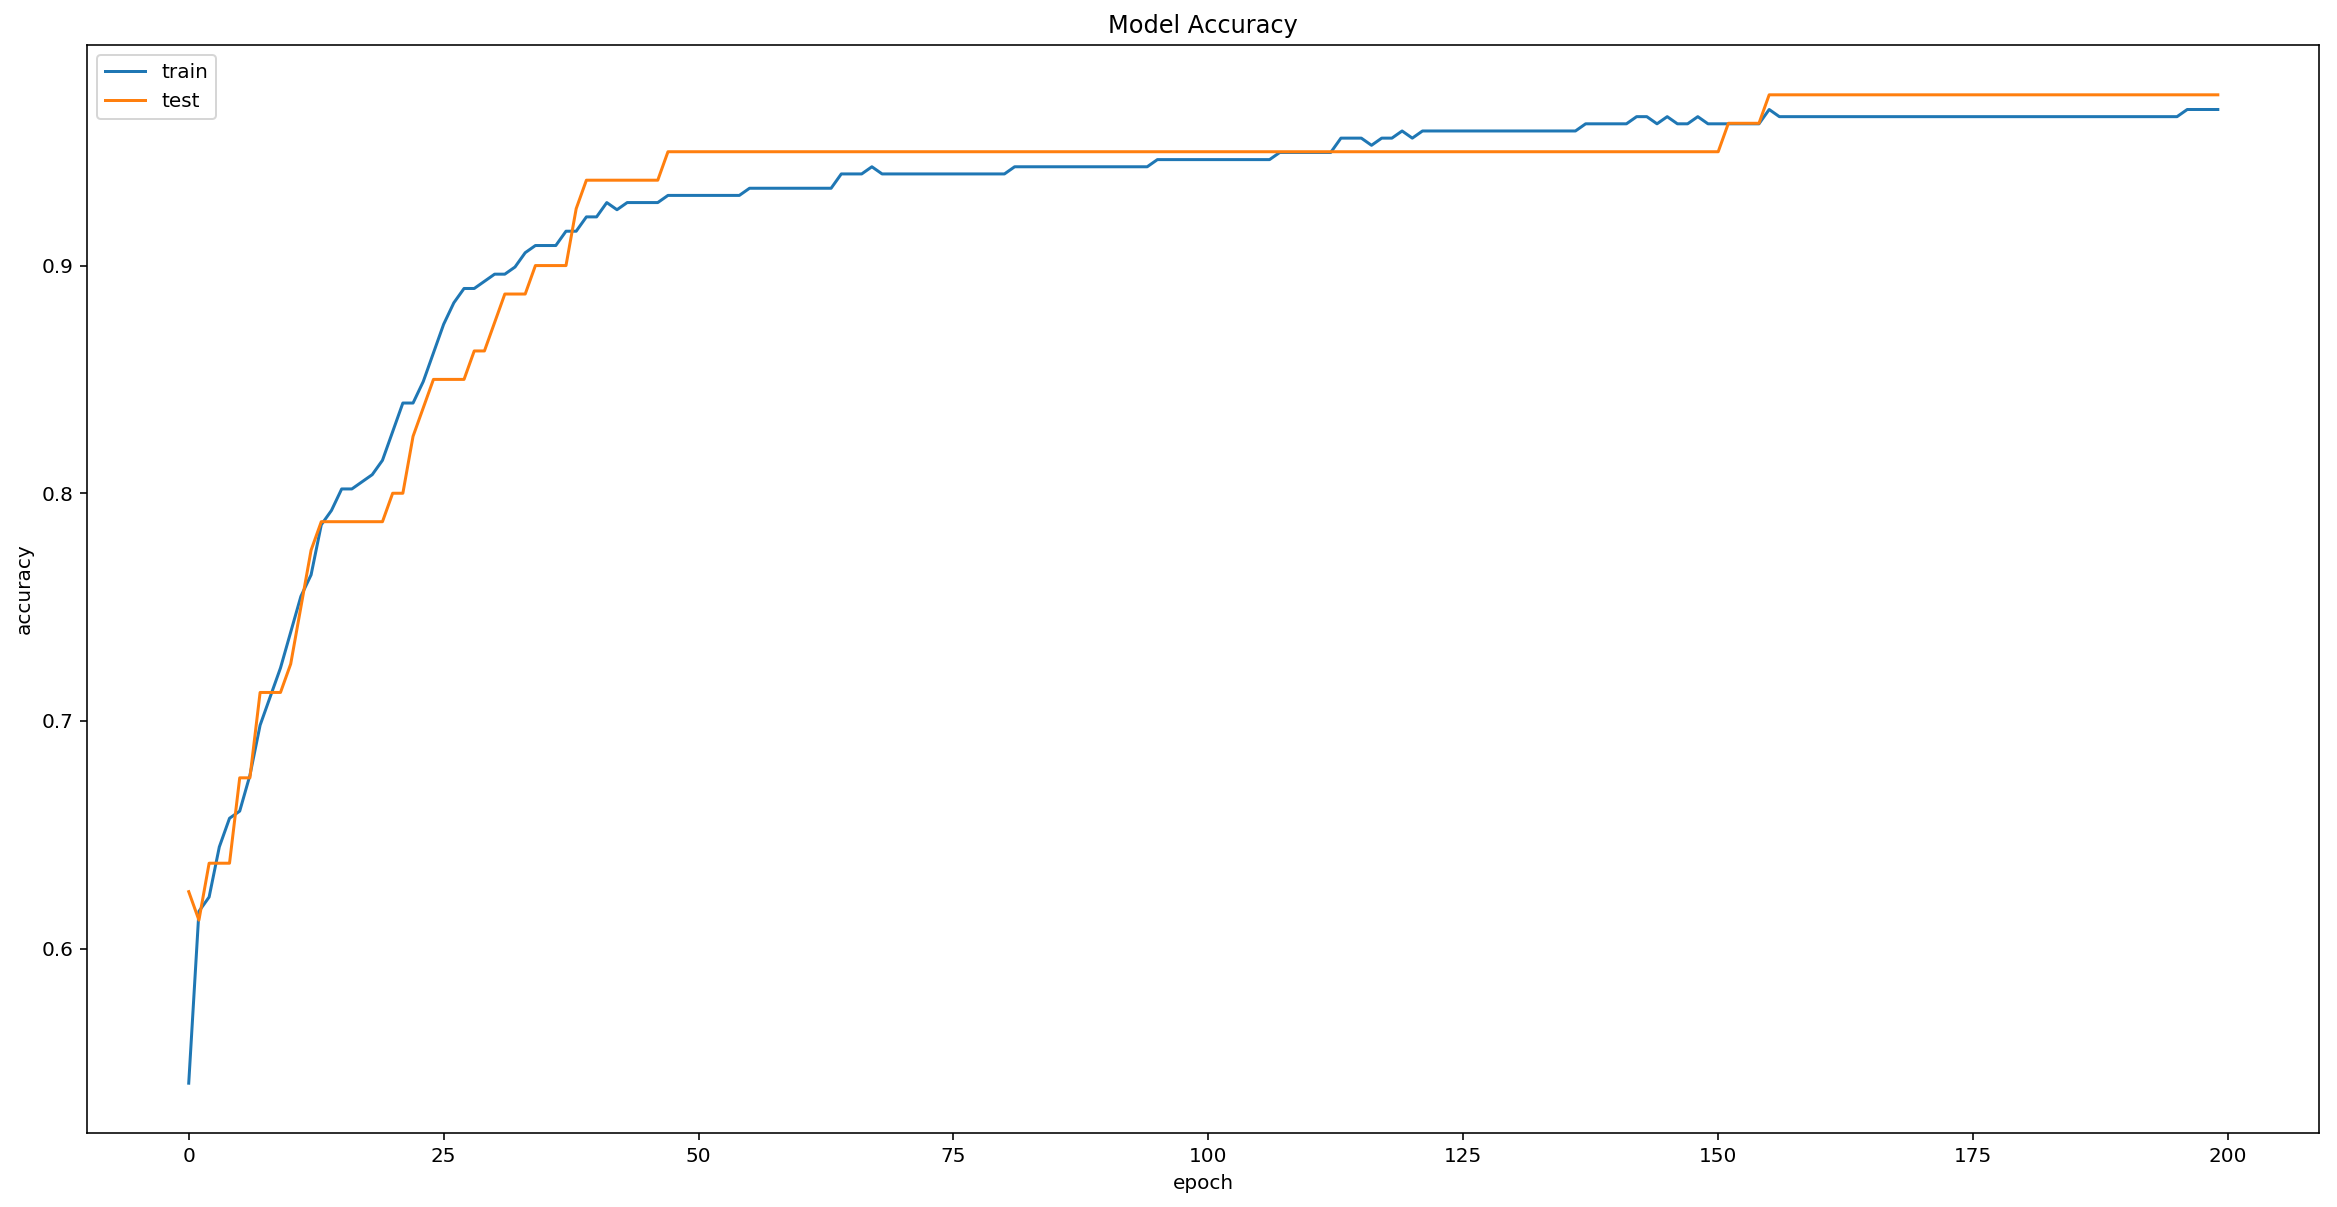

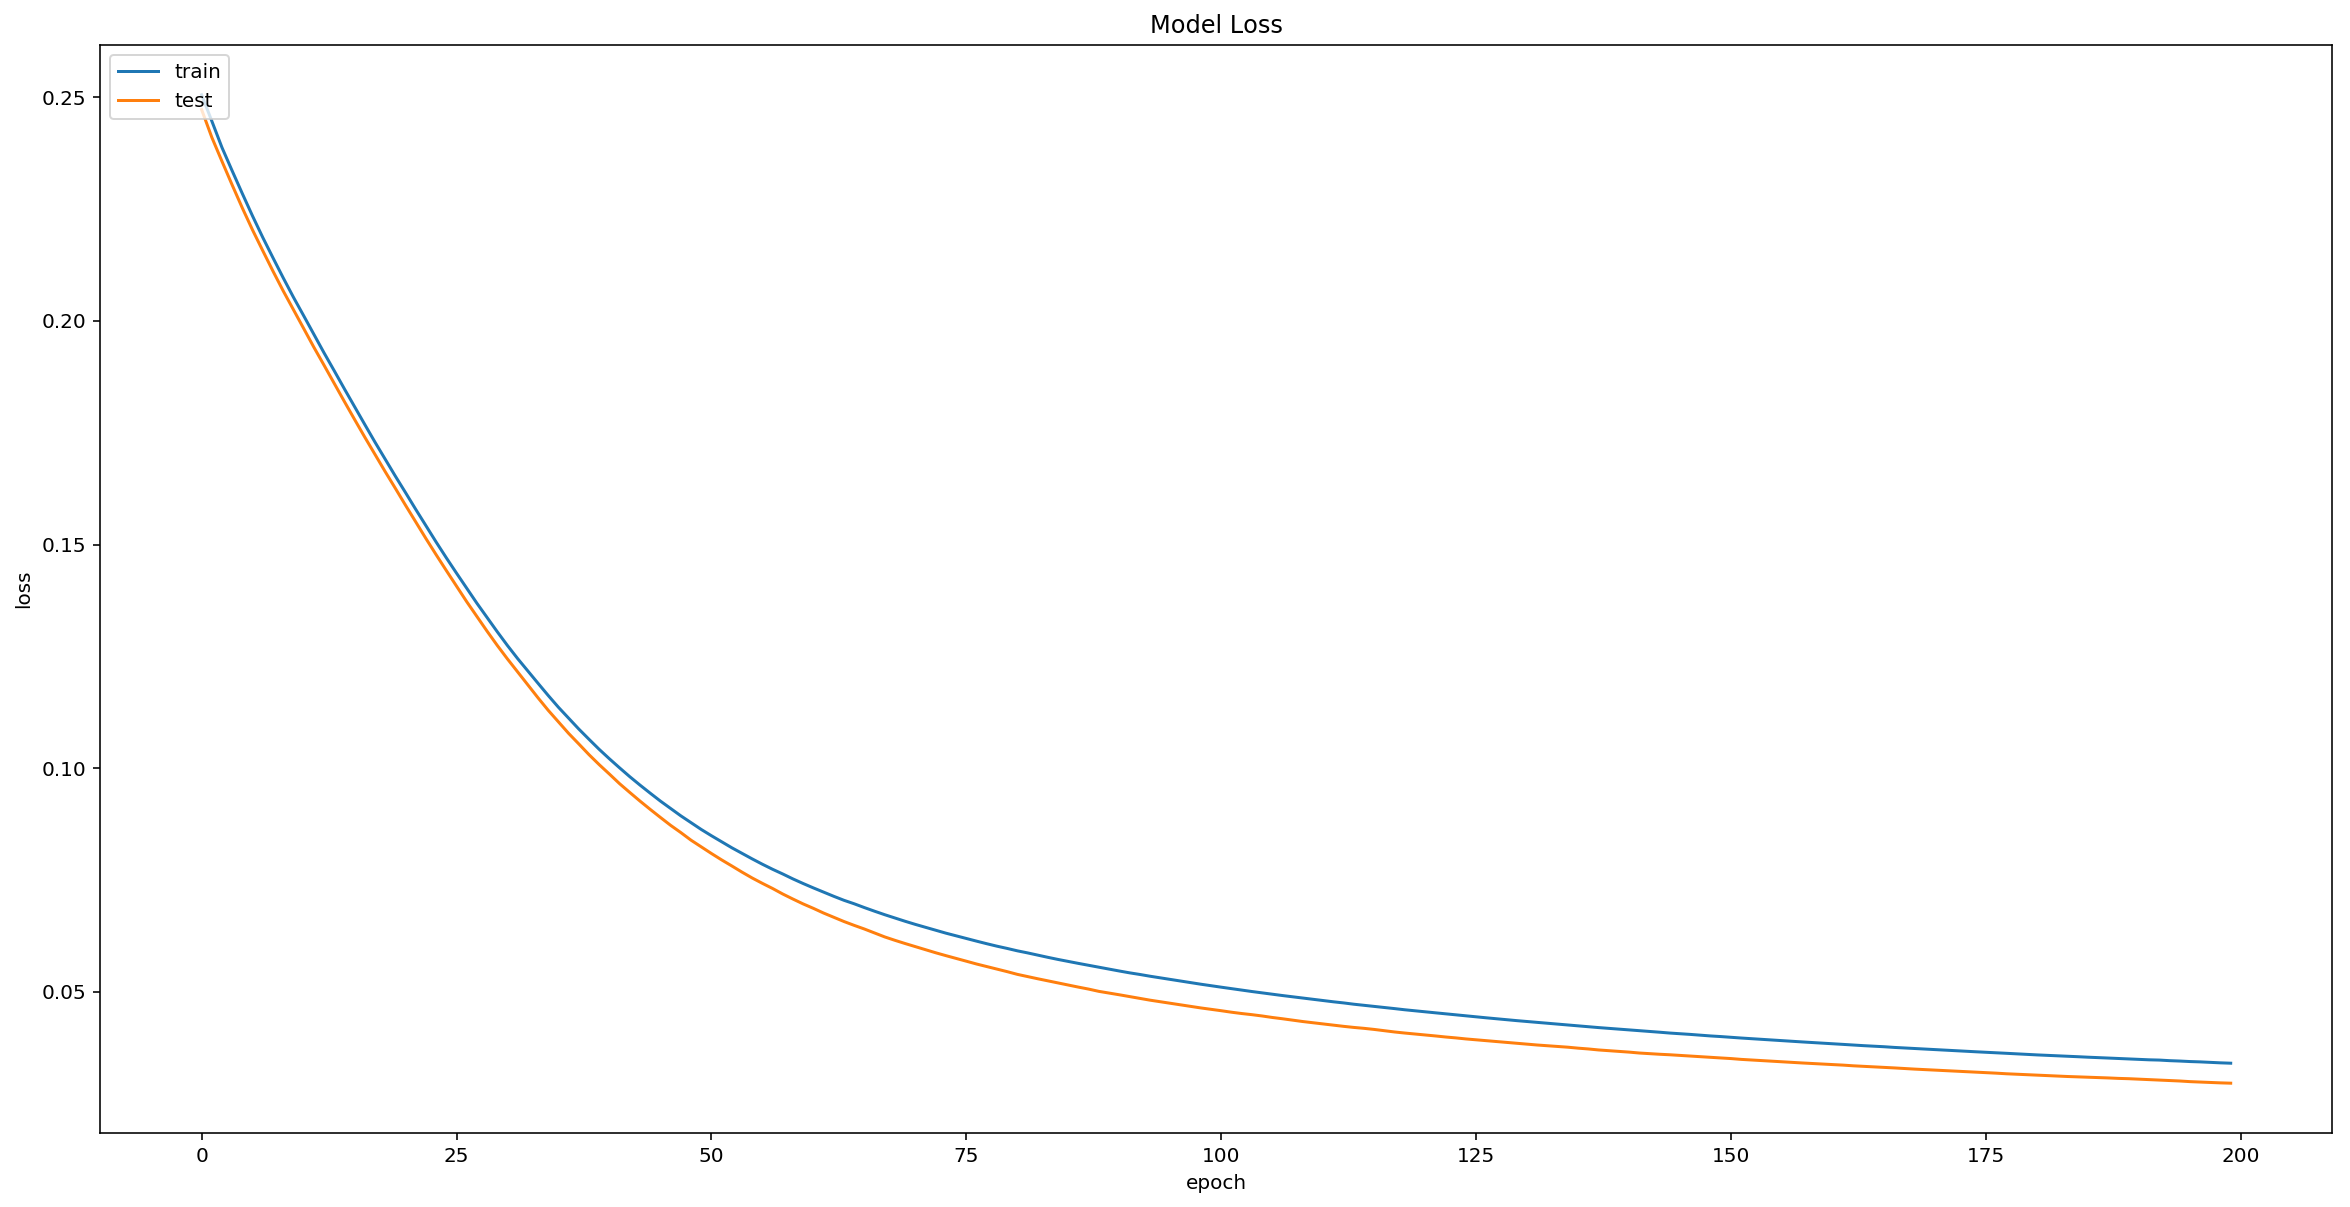

Memory Usage 3.13 MB
Time of Processing 8.14s
Accuracy 97.08%


In [46]:
show_info(model10, X_test_norm, y_test, keras_history10)

## Respostas da questão 3

In [47]:
# Building the model 11
model11 = Sequential()
model11.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model11.add(Dense(64, activation='tanh'))
model11.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd11 = optimizers.SGD(lr=0.001)
model11.compile(loss = 'mean_squared_error', optimizer=sgd11, metrics=['accuracy'])
model11.summary()

# Training the model 11
keras_history11 = KerasHistory()
memory_usage = monitor(target=train(model11, X_train_norm, y_train, keras_history11, epochs=500, batch_size=15))
keras_history11.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.2472 - acc: 0.6226 - val_loss: 0.2469 - val_acc: 0.6250
Epoch 2/500
 - 0s - loss: 0.2465 - acc: 0.6226 - val_loss: 0.2463 - val_acc: 0.6250
Epoch 3/500
 - 0s - loss: 0.2460 - acc: 0.6226 - val_loss: 0.2457 - val_acc: 0.6250
Epoch 4/500
 - 0s - loss: 0.2454 - acc: 0.6226 - val_loss: 0.2451 - val_acc: 0.6250
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.2041 - acc: 0.7453 - val_loss: 0.2036 - val_acc: 0.7250
Epoch 90/500
 - 0s - loss: 0.2037 - acc: 0.7516 - val_loss: 0.2031 - val_acc: 0.7250
Epoch 91/500
 - 0s - loss: 0.2033 - acc: 0.7547 - val_loss: 0.2027 - val_acc: 0.7250
Epoch 92/500
 - 0s - loss: 0.2029 - acc: 0.7579 - val_loss: 0.2023 - val_acc: 0.7250
Epoch 93/500
 - 0s - loss: 0.2025 - acc: 0.7579 - val_loss: 0.2019 - val_acc: 0.7250
Epoch 94/500
 - 0s - loss: 0.2021 - acc: 0.7579 - val_loss: 0.2015 - val_acc: 0.7375
Epoch 95/500
 - 0s - loss: 0.2016 - acc: 0.7610 - val_loss: 0.2011 - val_acc: 0.7375
Epoch 96/500
 - 0s - loss: 0.2012 - acc: 0.7610 - val_loss: 0.2006 - val_acc: 0.7375
Epoch 97/500
 - 0s - loss: 0.2008 - acc: 0.7642 - val_loss: 0.2002 - val_acc: 0.7375
Epoch 98/500
 - 0s - loss: 0.2004 - acc: 0.7642 - val_loss: 0.1998 - val_acc: 0.7375
Epoch 99/500
 - 0s - loss: 0.2000 - acc: 0.7642 - val_loss: 0.1994 - val_acc: 0.7375
Epoch 100/500
 - 0s - loss: 0.1996 - acc: 0.7642 - val_loss: 0.19

Epoch 185/500
 - 0s - loss: 0.1659 - acc: 0.8302 - val_loss: 0.1651 - val_acc: 0.8000
Epoch 186/500
 - 0s - loss: 0.1656 - acc: 0.8365 - val_loss: 0.1647 - val_acc: 0.8000
Epoch 187/500
 - 0s - loss: 0.1652 - acc: 0.8365 - val_loss: 0.1643 - val_acc: 0.8000
Epoch 188/500
 - 0s - loss: 0.1648 - acc: 0.8365 - val_loss: 0.1639 - val_acc: 0.8125
Epoch 189/500
 - 0s - loss: 0.1644 - acc: 0.8365 - val_loss: 0.1635 - val_acc: 0.8125
Epoch 190/500
 - 0s - loss: 0.1641 - acc: 0.8365 - val_loss: 0.1632 - val_acc: 0.8125
Epoch 191/500
 - 0s - loss: 0.1637 - acc: 0.8365 - val_loss: 0.1628 - val_acc: 0.8125
Epoch 192/500
 - 0s - loss: 0.1633 - acc: 0.8365 - val_loss: 0.1624 - val_acc: 0.8125
Epoch 193/500
 - 0s - loss: 0.1629 - acc: 0.8396 - val_loss: 0.1620 - val_acc: 0.8125
Epoch 194/500
 - 0s - loss: 0.1625 - acc: 0.8396 - val_loss: 0.1616 - val_acc: 0.8125
Epoch 195/500
 - 0s - loss: 0.1621 - acc: 0.8396 - val_loss: 0.1612 - val_acc: 0.8125
Epoch 196/500
 - 0s - loss: 0.1618 - acc: 0.8396 - val

Epoch 281/500
 - 0s - loss: 0.1325 - acc: 0.8899 - val_loss: 0.1310 - val_acc: 0.8625
Epoch 282/500
 - 0s - loss: 0.1321 - acc: 0.8931 - val_loss: 0.1307 - val_acc: 0.8625
Epoch 283/500
 - 0s - loss: 0.1318 - acc: 0.8931 - val_loss: 0.1304 - val_acc: 0.8625
Epoch 284/500
 - 0s - loss: 0.1315 - acc: 0.8962 - val_loss: 0.1301 - val_acc: 0.8625
Epoch 285/500
 - 0s - loss: 0.1312 - acc: 0.8962 - val_loss: 0.1298 - val_acc: 0.8625
Epoch 286/500
 - 0s - loss: 0.1309 - acc: 0.8962 - val_loss: 0.1295 - val_acc: 0.8625
Epoch 287/500
 - 0s - loss: 0.1306 - acc: 0.8962 - val_loss: 0.1291 - val_acc: 0.8750
Epoch 288/500
 - 0s - loss: 0.1303 - acc: 0.8931 - val_loss: 0.1288 - val_acc: 0.8750
Epoch 289/500
 - 0s - loss: 0.1300 - acc: 0.8931 - val_loss: 0.1285 - val_acc: 0.8750
Epoch 290/500
 - 0s - loss: 0.1297 - acc: 0.8931 - val_loss: 0.1282 - val_acc: 0.8750
Epoch 291/500
 - 0s - loss: 0.1294 - acc: 0.8931 - val_loss: 0.1279 - val_acc: 0.8750
Epoch 292/500
 - 0s - loss: 0.1291 - acc: 0.8931 - val

Epoch 377/500
 - 0s - loss: 0.1067 - acc: 0.9151 - val_loss: 0.1044 - val_acc: 0.9125
Epoch 378/500
 - 0s - loss: 0.1065 - acc: 0.9151 - val_loss: 0.1042 - val_acc: 0.9125
Epoch 379/500
 - 0s - loss: 0.1062 - acc: 0.9182 - val_loss: 0.1039 - val_acc: 0.9125
Epoch 380/500
 - 0s - loss: 0.1060 - acc: 0.9182 - val_loss: 0.1037 - val_acc: 0.9125
Epoch 381/500
 - 0s - loss: 0.1058 - acc: 0.9182 - val_loss: 0.1035 - val_acc: 0.9125
Epoch 382/500
 - 0s - loss: 0.1056 - acc: 0.9182 - val_loss: 0.1032 - val_acc: 0.9125
Epoch 383/500
 - 0s - loss: 0.1054 - acc: 0.9182 - val_loss: 0.1030 - val_acc: 0.9125
Epoch 384/500
 - 0s - loss: 0.1051 - acc: 0.9182 - val_loss: 0.1028 - val_acc: 0.9125
Epoch 385/500
 - 0s - loss: 0.1049 - acc: 0.9182 - val_loss: 0.1026 - val_acc: 0.9125
Epoch 386/500
 - 0s - loss: 0.1047 - acc: 0.9182 - val_loss: 0.1023 - val_acc: 0.9125
Epoch 387/500
 - 0s - loss: 0.1045 - acc: 0.9182 - val_loss: 0.1021 - val_acc: 0.9125
Epoch 388/500
 - 0s - loss: 0.1043 - acc: 0.9182 - val

Epoch 473/500
 - 0s - loss: 0.0888 - acc: 0.9308 - val_loss: 0.0856 - val_acc: 0.9375
Epoch 474/500
 - 0s - loss: 0.0886 - acc: 0.9308 - val_loss: 0.0854 - val_acc: 0.9375
Epoch 475/500
 - 0s - loss: 0.0885 - acc: 0.9308 - val_loss: 0.0852 - val_acc: 0.9375
Epoch 476/500
 - 0s - loss: 0.0883 - acc: 0.9308 - val_loss: 0.0851 - val_acc: 0.9375
Epoch 477/500
 - 0s - loss: 0.0881 - acc: 0.9308 - val_loss: 0.0849 - val_acc: 0.9375
Epoch 478/500
 - 0s - loss: 0.0880 - acc: 0.9308 - val_loss: 0.0848 - val_acc: 0.9375
Epoch 479/500
 - 0s - loss: 0.0878 - acc: 0.9308 - val_loss: 0.0846 - val_acc: 0.9500
Epoch 480/500
 - 0s - loss: 0.0877 - acc: 0.9308 - val_loss: 0.0844 - val_acc: 0.9500
Epoch 481/500
 - 0s - loss: 0.0876 - acc: 0.9308 - val_loss: 0.0843 - val_acc: 0.9500
Epoch 482/500
 - 0s - loss: 0.0874 - acc: 0.9308 - val_loss: 0.0841 - val_acc: 0.9500
Epoch 483/500
 - 0s - loss: 0.0873 - acc: 0.9308 - val_loss: 0.0840 - val_acc: 0.9500
Epoch 484/500
 - 0s - loss: 0.0871 - acc: 0.9308 - val

## Treinamento 11
Para o treinamento 11 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.001

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

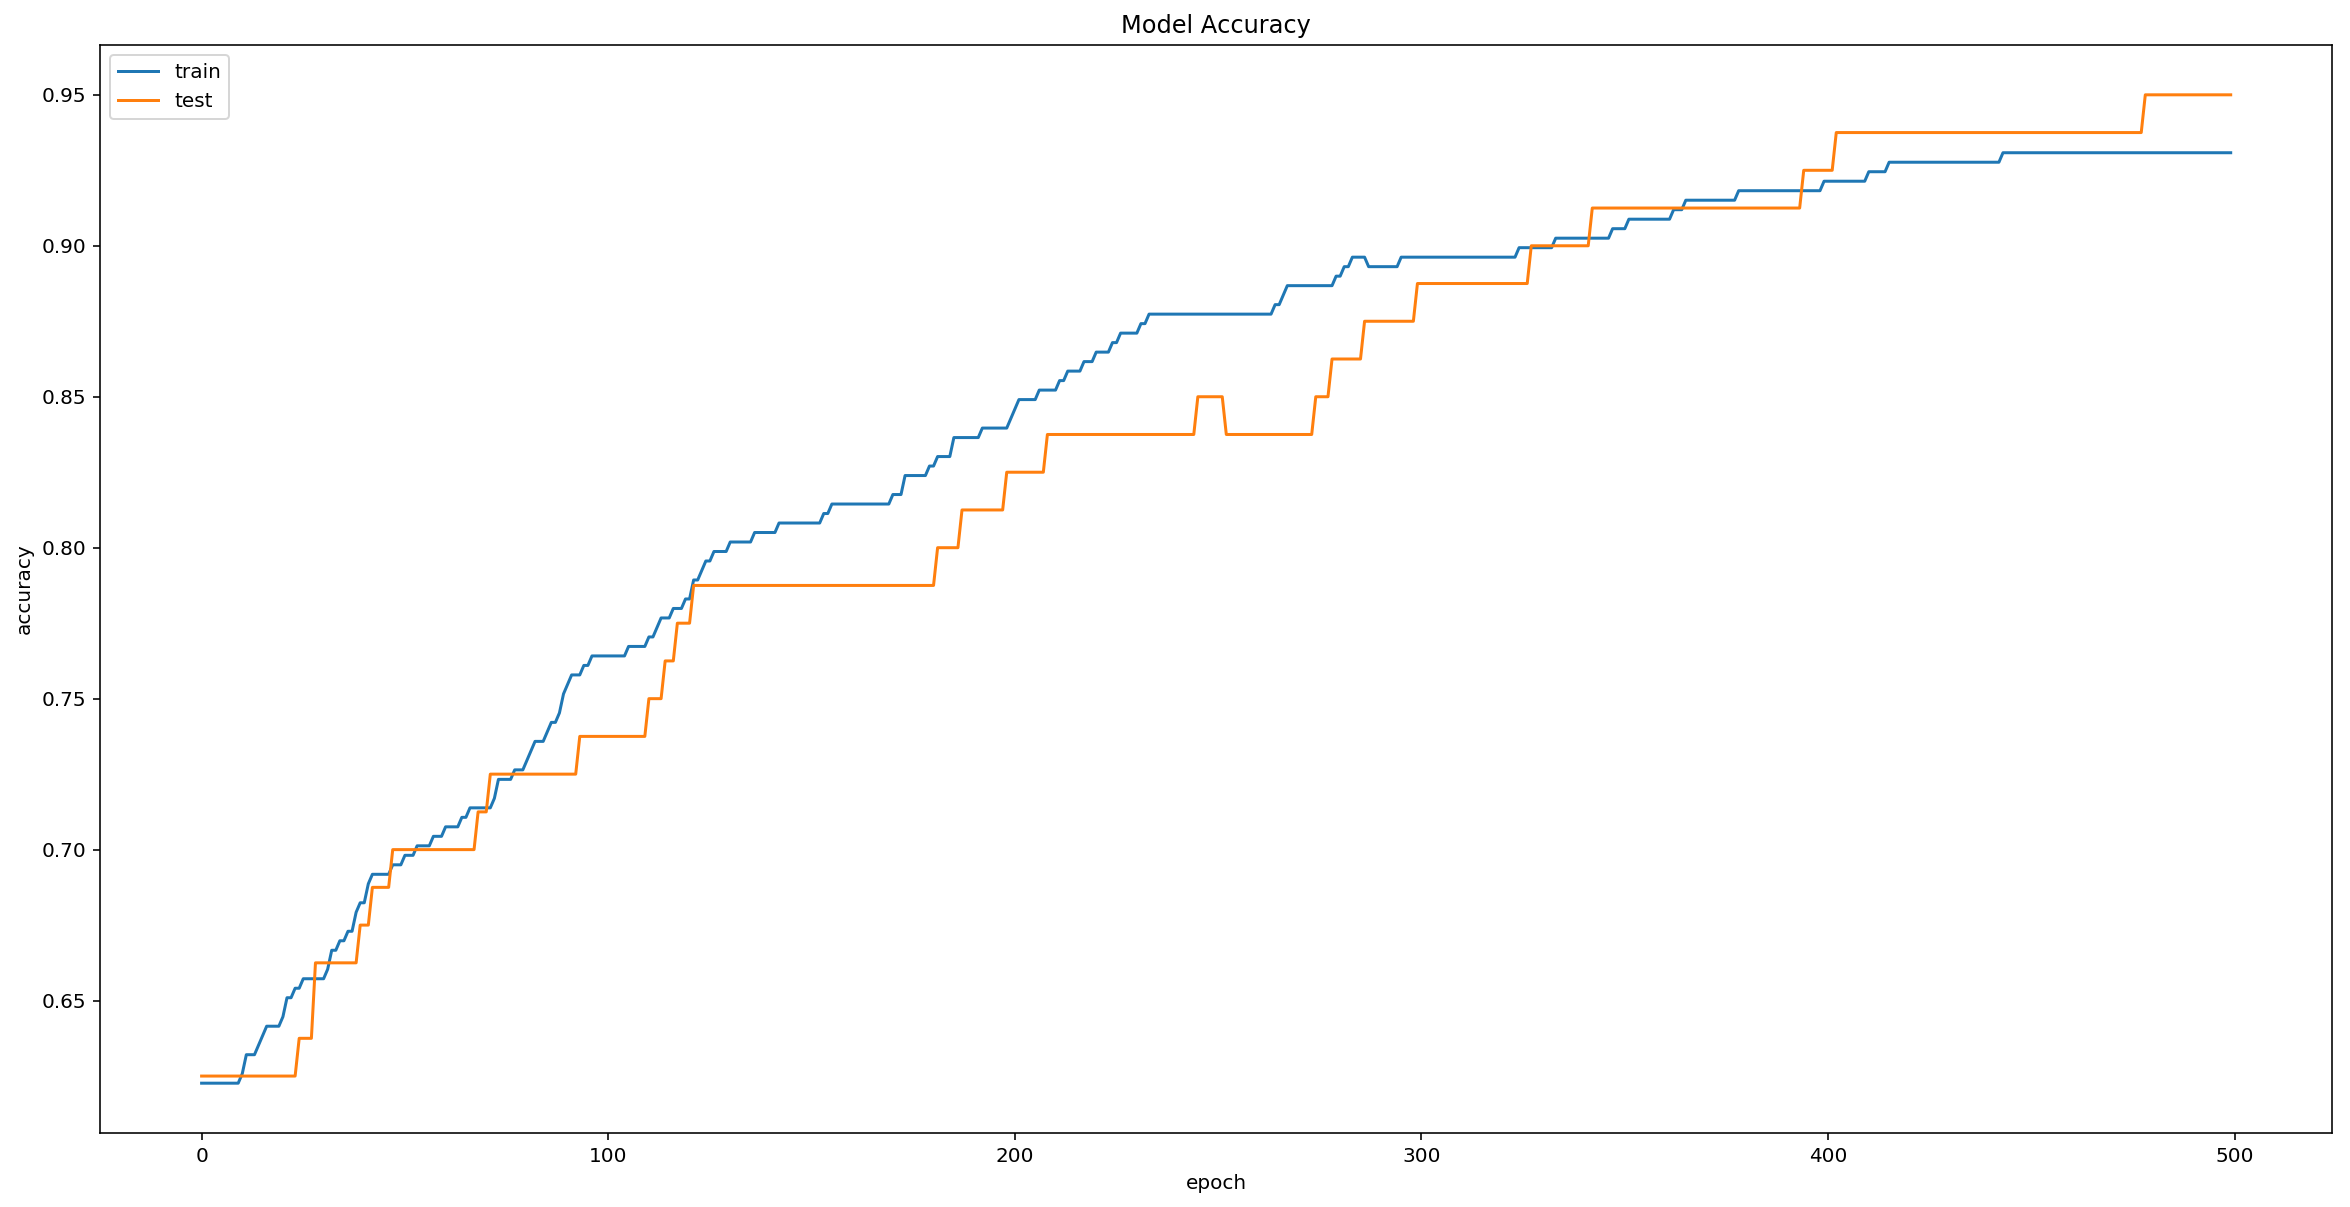

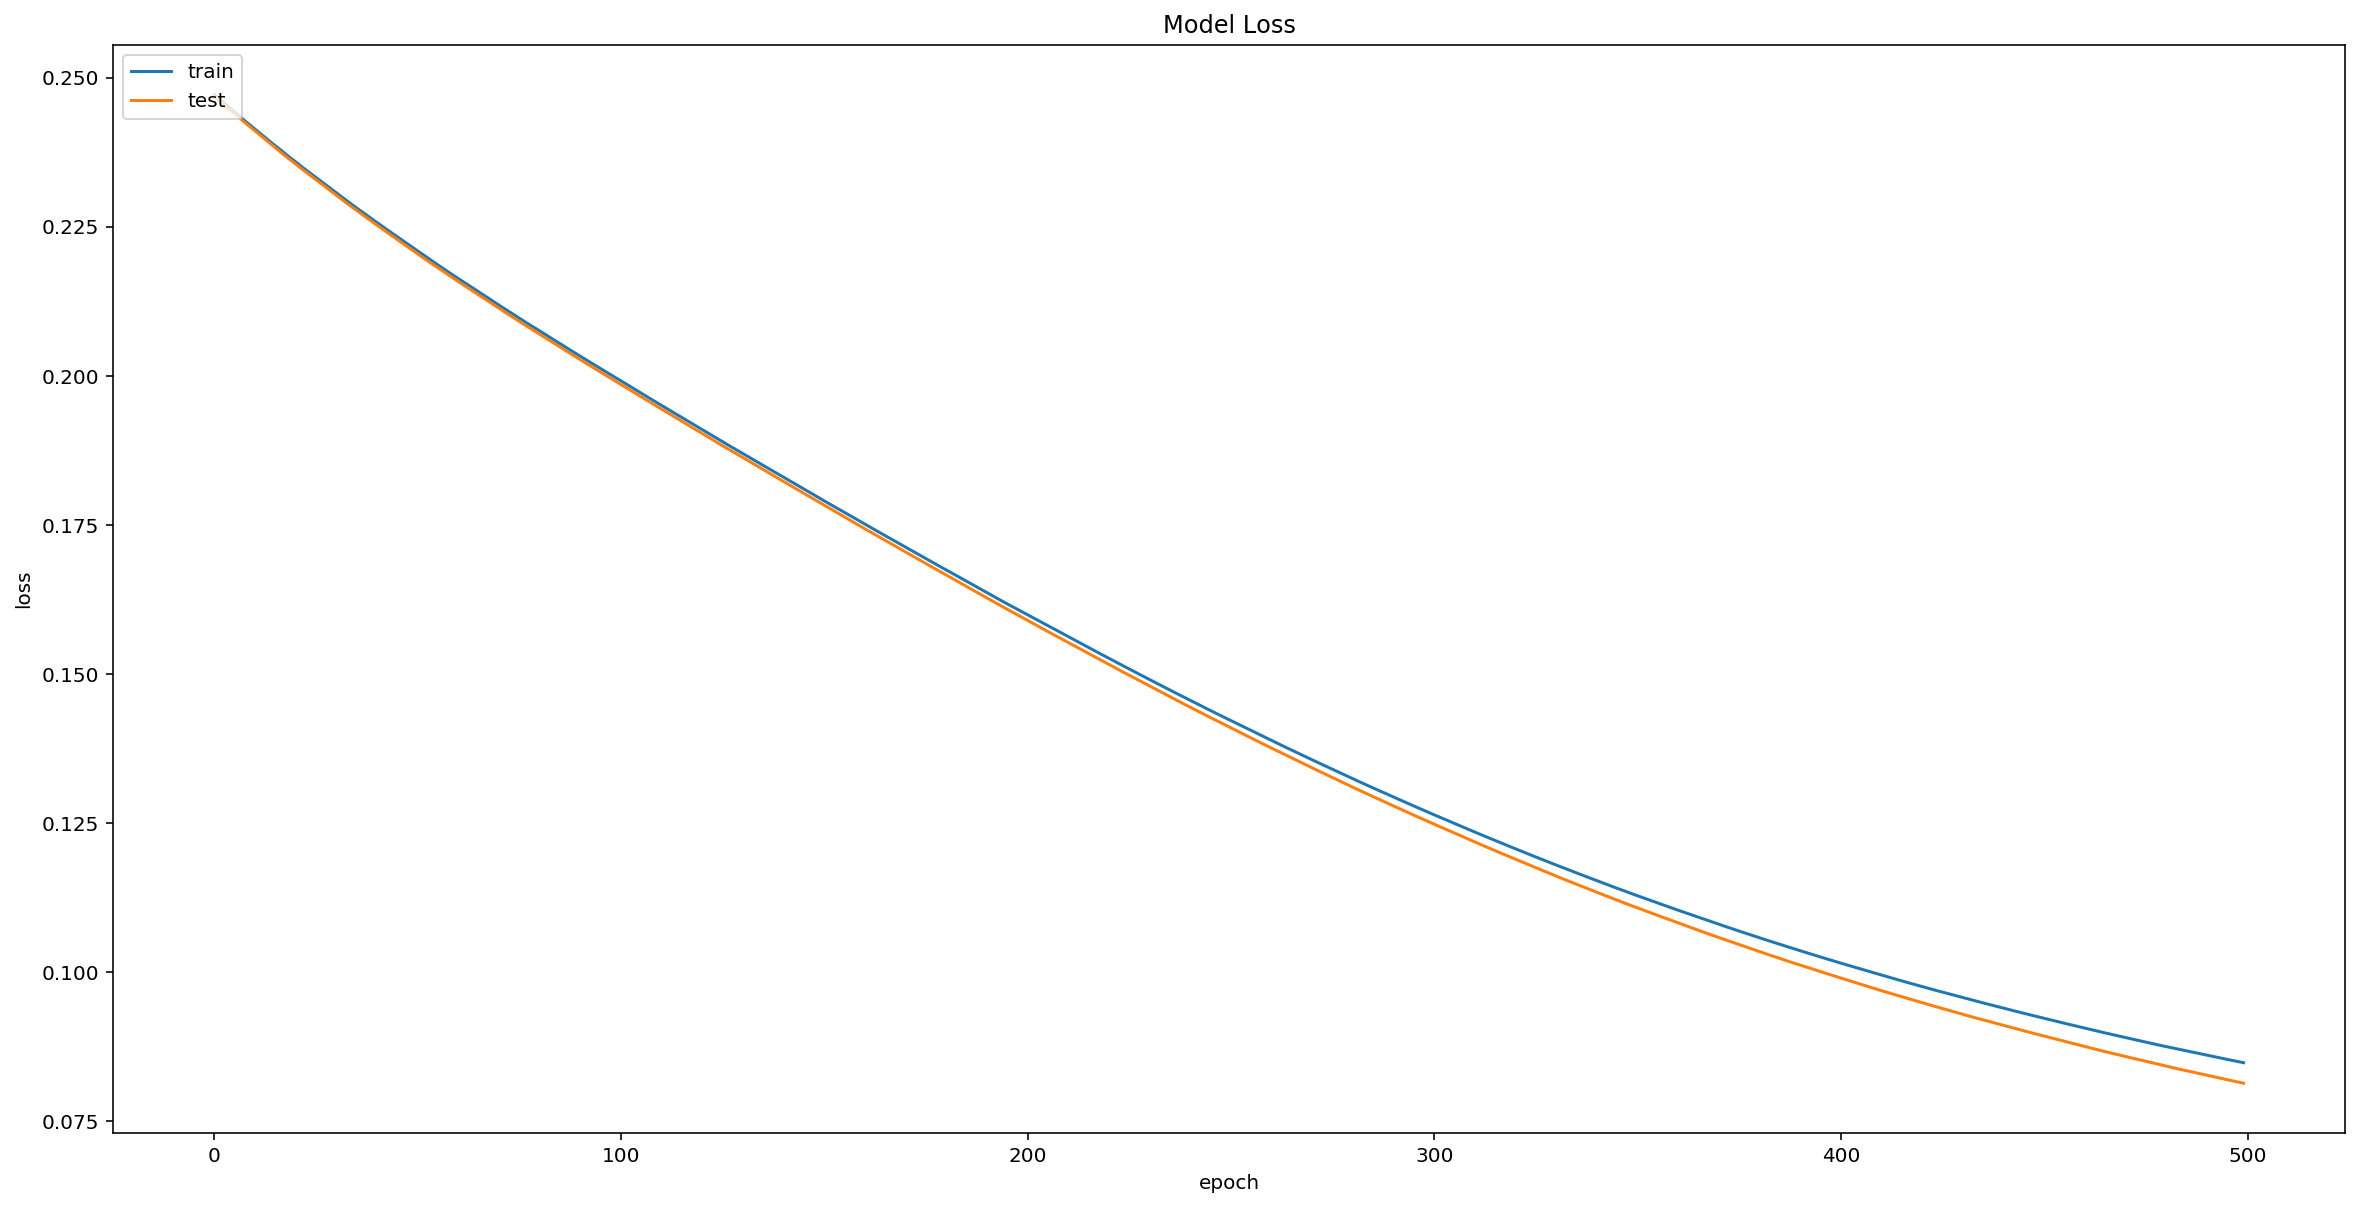

Memory Usage 0.15 MB
Time of Processing 18.15s
Accuracy 94.15%


In [48]:
show_info(model11, X_test_norm, y_test, keras_history11)

In [51]:
# Building the model 12
model12 = Sequential()
model12.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model12.add(Dense(64, activation='tanh'))
model12.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd12 = optimizers.SGD(lr=0.009)
model12.compile(loss = 'mean_squared_error', optimizer=sgd12, metrics=['accuracy'])
model12.summary()

# Training the model 12
keras_history12 = KerasHistory()
memory_usage = monitor(target=train(model12, X_train_norm, y_train, keras_history12, epochs=500, batch_size=15))
keras_history12.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.2476 - acc: 0.4937 - val_loss: 0.2440 - val_acc: 0.7000
Epoch 2/500
 - 0s - loss: 0.2402 - acc: 0.8585 - val_loss: 0.2370 - val_acc: 0.9125
Epoch 3/500
 - 0s - loss: 0.2334 - acc: 0.9151 - val_loss: 0.2304 - val_acc: 0.8875
Epoch 4/500
 - 0s - loss: 0.2272 - acc: 0.8648 - val_loss: 0.2241 - val_acc: 0.8500
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0563 - acc: 0.9434 - val_loss: 0.0512 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0560 - acc: 0.9434 - val_loss: 0.0508 - val_acc: 0.9500
Epoch 91/500
 - 0s - loss: 0.0556 - acc: 0.9434 - val_loss: 0.0504 - val_acc: 0.9500
Epoch 92/500
 - 0s - loss: 0.0552 - acc: 0.9434 - val_loss: 0.0501 - val_acc: 0.9500
Epoch 93/500
 - 0s - loss: 0.0548 - acc: 0.9434 - val_loss: 0.0497 - val_acc: 0.9500
Epoch 94/500
 - 0s - loss: 0.0545 - acc: 0.9434 - val_loss: 0.0493 - val_acc: 0.9500
Epoch 95/500
 - 0s - loss: 0.0541 - acc: 0.9434 - val_loss: 0.0490 - val_acc: 0.9500
Epoch 96/500
 - 0s - loss: 0.0538 - acc: 0.9434 - val_loss: 0.0486 - val_acc: 0.9500
Epoch 97/500
 - 0s - loss: 0.0534 - acc: 0.9434 - val_loss: 0.0483 - val_acc: 0.9500
Epoch 98/500
 - 0s - loss: 0.0531 - acc: 0.9434 - val_loss: 0.0480 - val_acc: 0.9500
Epoch 99/500
 - 0s - loss: 0.0527 - acc: 0.9434 - val_loss: 0.0477 - val_acc: 0.9500
Epoch 100/500
 - 0s - loss: 0.0524 - acc: 0.9434 - val_loss: 0.04

Epoch 185/500
 - 0s - loss: 0.0367 - acc: 0.9654 - val_loss: 0.0324 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0366 - acc: 0.9654 - val_loss: 0.0323 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0364 - acc: 0.9654 - val_loss: 0.0322 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0363 - acc: 0.9654 - val_loss: 0.0321 - val_acc: 0.9750
Epoch 189/500
 - 0s - loss: 0.0362 - acc: 0.9654 - val_loss: 0.0320 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0361 - acc: 0.9654 - val_loss: 0.0319 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0360 - acc: 0.9654 - val_loss: 0.0318 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0359 - acc: 0.9654 - val_loss: 0.0317 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0358 - acc: 0.9654 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0357 - acc: 0.9654 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0356 - acc: 0.9654 - val_loss: 0.0314 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0355 - acc: 0.9654 - val

Epoch 281/500
 - 0s - loss: 0.0297 - acc: 0.9748 - val_loss: 0.0256 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0296 - acc: 0.9748 - val_loss: 0.0255 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0296 - acc: 0.9717 - val_loss: 0.0255 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0295 - acc: 0.9748 - val_loss: 0.0254 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0295 - acc: 0.9717 - val_loss: 0.0254 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0295 - acc: 0.9717 - val_loss: 0.0254 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0294 - acc: 0.9748 - val_loss: 0.0253 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0294 - acc: 0.9748 - val_loss: 0.0252 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0252 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0293 - acc: 0.9717 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0292 - acc: 0.9717 - val

Epoch 377/500
 - 0s - loss: 0.0264 - acc: 0.9717 - val_loss: 0.0220 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0263 - acc: 0.9717 - val_loss: 0.0220 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0263 - acc: 0.9717 - val_loss: 0.0220 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0263 - acc: 0.9717 - val_loss: 0.0220 - val_acc: 0.9750
Epoch 381/500
 - 0s - loss: 0.0262 - acc: 0.9717 - val_loss: 0.0219 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0262 - acc: 0.9717 - val_loss: 0.0219 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0262 - acc: 0.9717 - val_loss: 0.0219 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0262 - acc: 0.9717 - val_loss: 0.0218 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0262 - acc: 0.9717 - val_loss: 0.0218 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0261 - acc: 0.9717 - val_loss: 0.0217 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0261 - acc: 0.9717 - val_loss: 0.0217 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0261 - acc: 0.9717 - val

Epoch 473/500
 - 0s - loss: 0.0243 - acc: 0.9717 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 474/500
 - 0s - loss: 0.0243 - acc: 0.9748 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 475/500
 - 0s - loss: 0.0243 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 476/500
 - 0s - loss: 0.0243 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 477/500
 - 0s - loss: 0.0243 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 478/500
 - 0s - loss: 0.0243 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 479/500
 - 0s - loss: 0.0242 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 480/500
 - 0s - loss: 0.0242 - acc: 0.9717 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 481/500
 - 0s - loss: 0.0242 - acc: 0.9780 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 482/500
 - 0s - loss: 0.0242 - acc: 0.9748 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 483/500
 - 0s - loss: 0.0242 - acc: 0.9717 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 484/500
 - 0s - loss: 0.0242 - acc: 0.9717 - val

## Treinamento 12
Para o treinamento 12 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.009

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

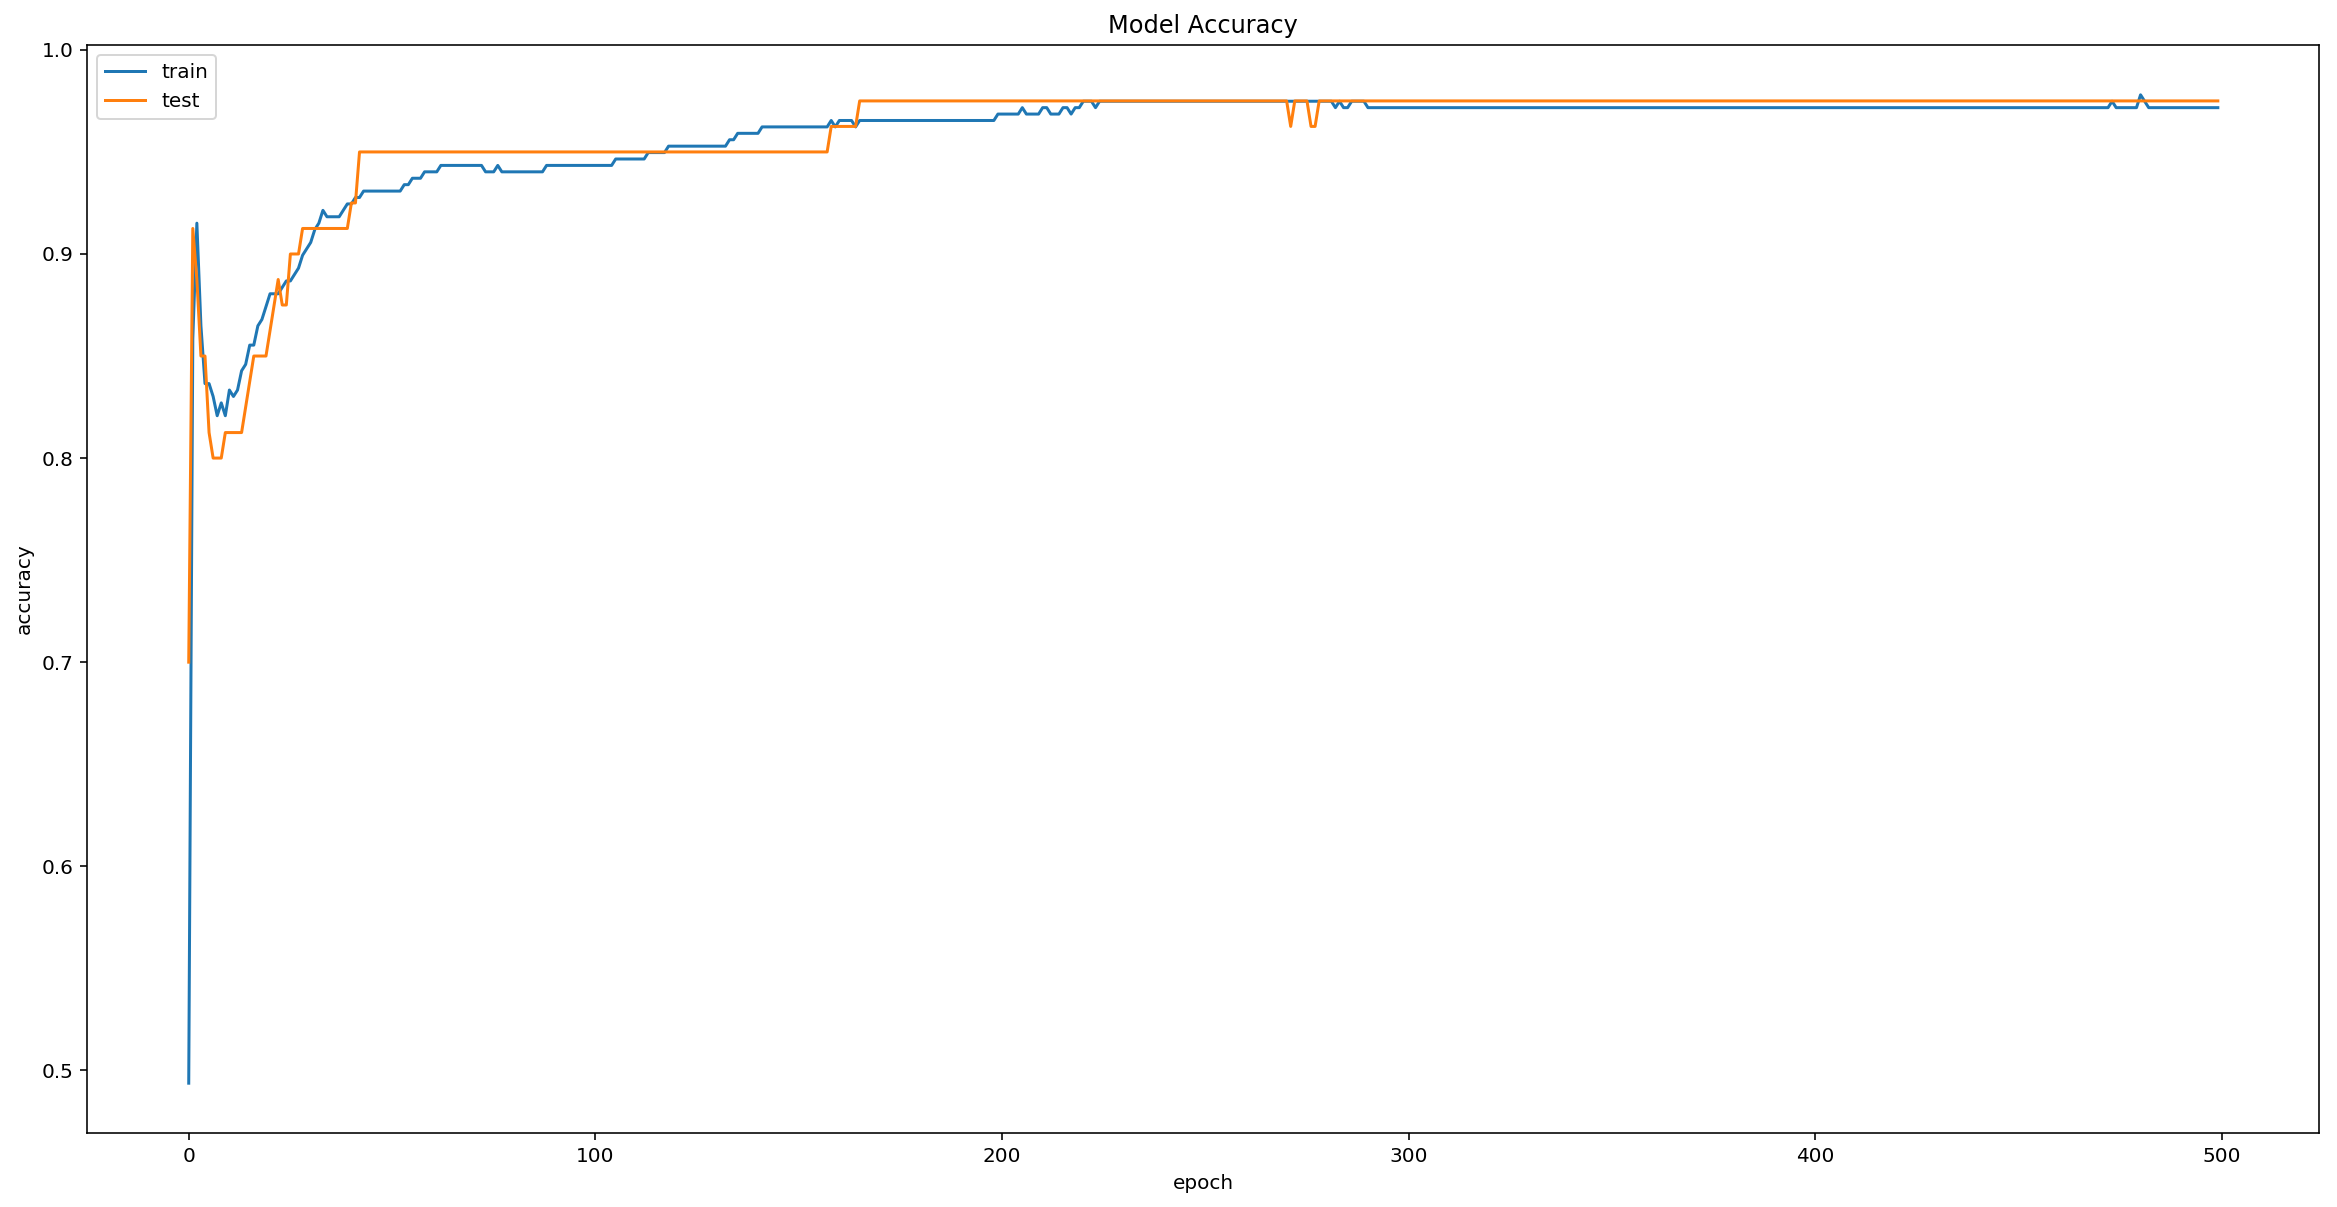

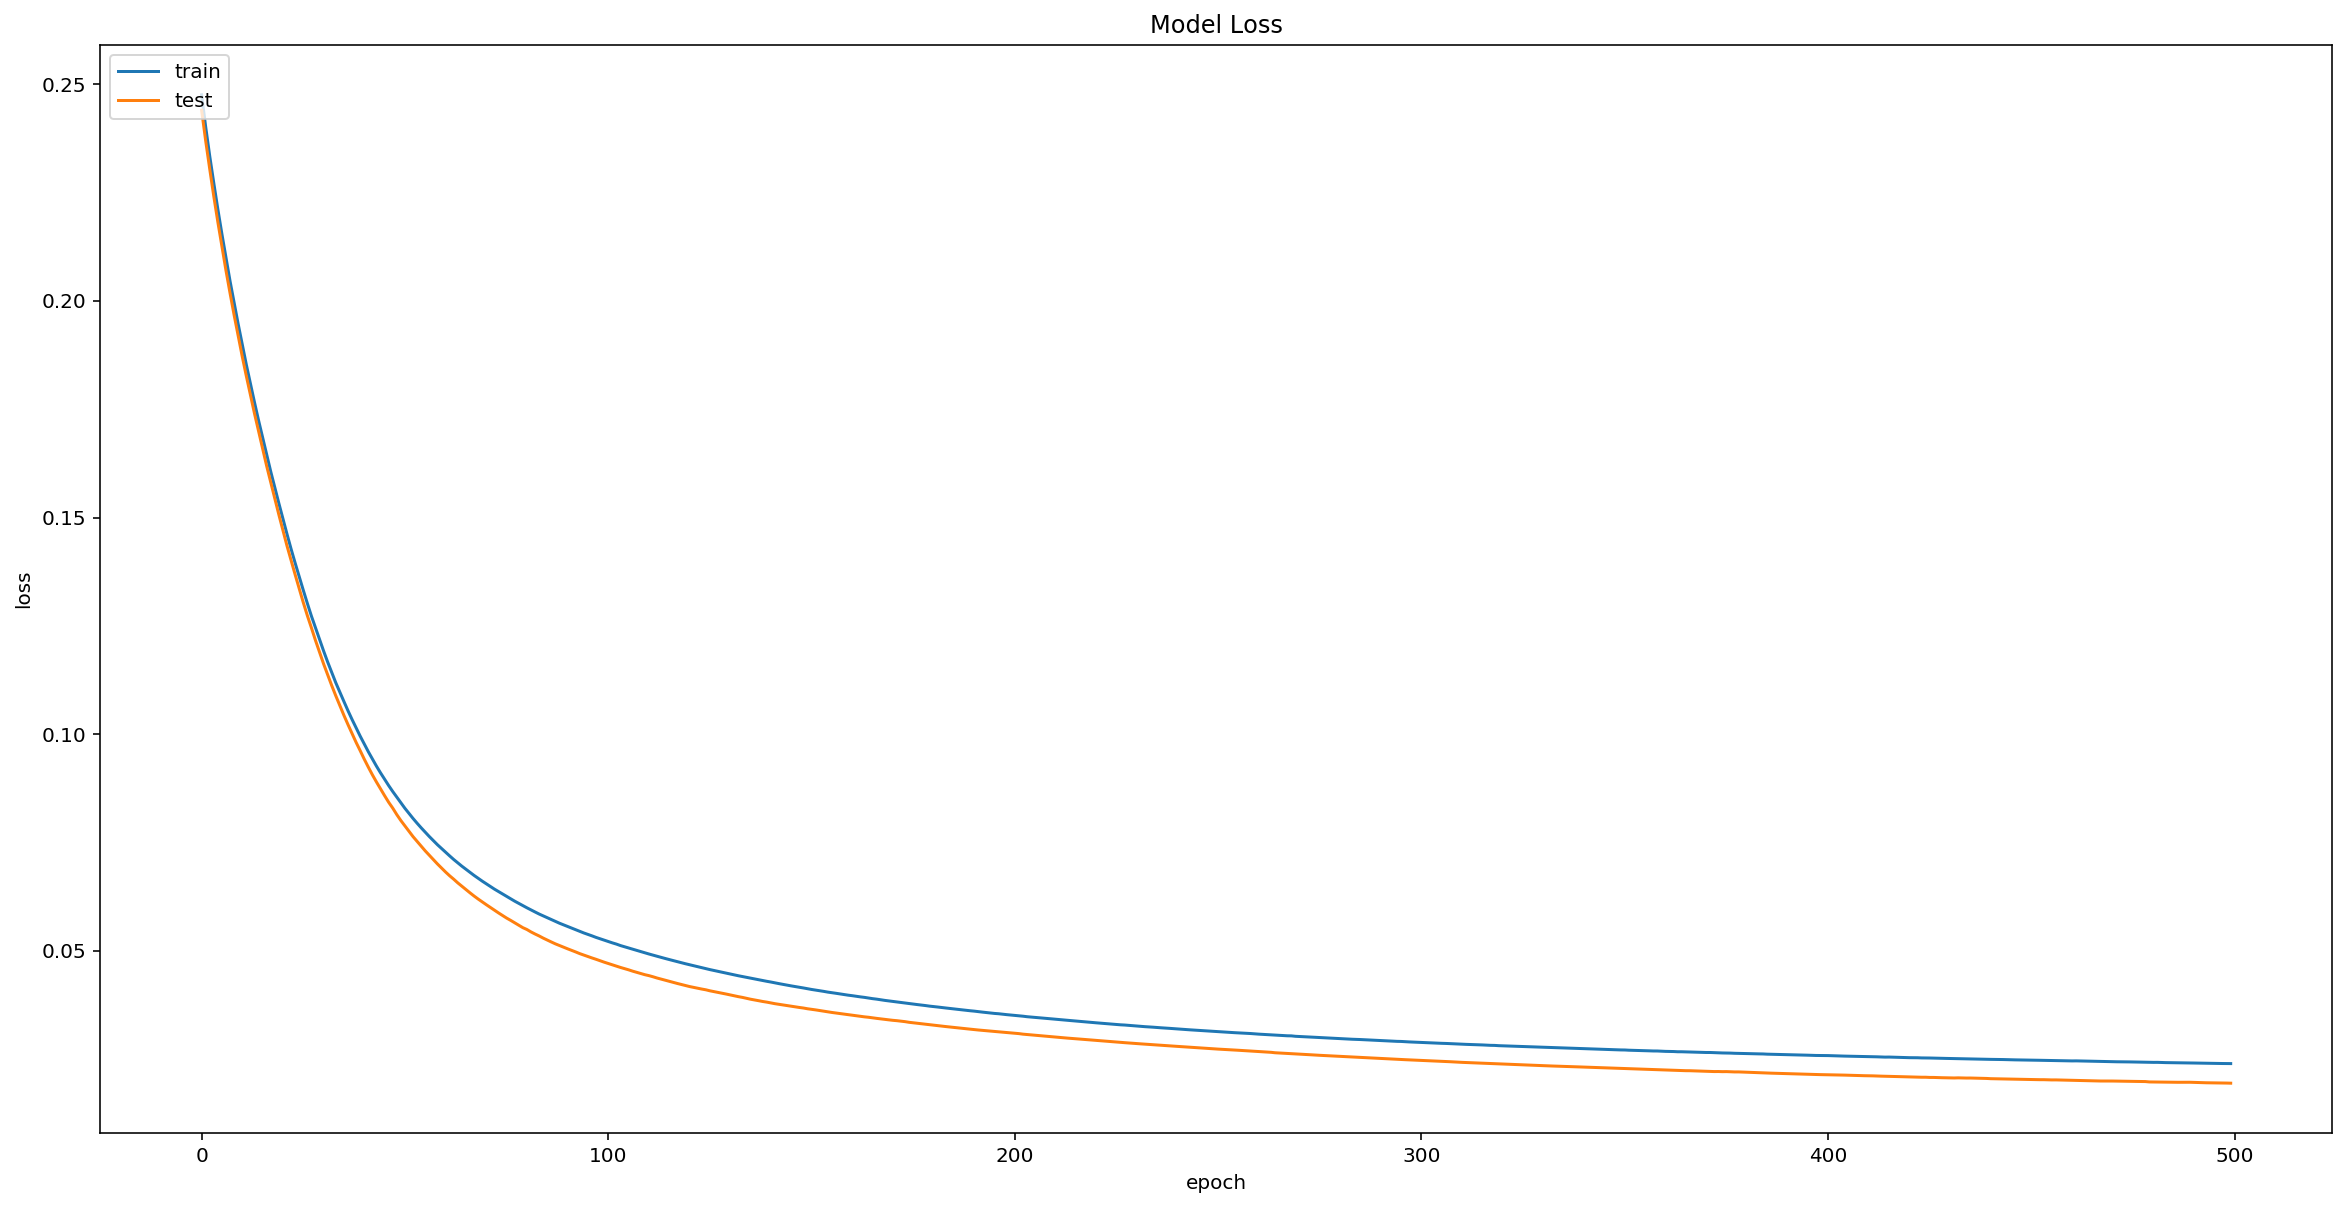

Memory Usage 0.15 MB
Time of Processing 17.43s
Accuracy 95.32%


In [52]:
show_info(model12, X_test_norm, y_test, keras_history12)

In [53]:
# Building the model 13
model13 = Sequential()
model13.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model13.add(Dense(64, activation='tanh'))
model13.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd13 = optimizers.SGD(lr=0.01)
model13.compile(loss = 'mean_squared_error', optimizer=sgd13, metrics=['accuracy'])
model13.summary()

# Training the model 13
keras_history13 = KerasHistory()
memory_usage = monitor(target=train(model13, X_train_norm, y_train, keras_history13, epochs=500, batch_size=15))
keras_history13.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 1s - loss: 0.2502 - acc: 0.3899 - val_loss: 0.2459 - val_acc: 0.4000
Epoch 2/500
 - 0s - loss: 0.2432 - acc: 0.6258 - val_loss: 0.2391 - val_acc: 0.9375
Epoch 3/500
 - 0s - loss: 0.2368 - acc: 0.9057 - val_loss: 0.2326 - val_acc: 0.9375
Epoch 4/500
 - 0s - loss: 0.2306 - acc: 0.8774 - val_loss: 0.2269 - val_acc: 0.8125
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0557 - acc: 0.9403 - val_loss: 0.0505 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0553 - acc: 0.9403 - val_loss: 0.0501 - val_acc: 0.9500
Epoch 91/500
 - 0s - loss: 0.0550 - acc: 0.9403 - val_loss: 0.0497 - val_acc: 0.9500
Epoch 92/500
 - 0s - loss: 0.0546 - acc: 0.9403 - val_loss: 0.0492 - val_acc: 0.9500
Epoch 93/500
 - 0s - loss: 0.0542 - acc: 0.9403 - val_loss: 0.0489 - val_acc: 0.9500
Epoch 94/500
 - 0s - loss: 0.0538 - acc: 0.9403 - val_loss: 0.0486 - val_acc: 0.9500
Epoch 95/500
 - 0s - loss: 0.0534 - acc: 0.9403 - val_loss: 0.0482 - val_acc: 0.9500
Epoch 96/500
 - 0s - loss: 0.0531 - acc: 0.9403 - val_loss: 0.0479 - val_acc: 0.9500
Epoch 97/500
 - 0s - loss: 0.0527 - acc: 0.9434 - val_loss: 0.0476 - val_acc: 0.9500
Epoch 98/500
 - 0s - loss: 0.0524 - acc: 0.9434 - val_loss: 0.0473 - val_acc: 0.9500
Epoch 99/500
 - 0s - loss: 0.0520 - acc: 0.9434 - val_loss: 0.0470 - val_acc: 0.9500
Epoch 100/500
 - 0s - loss: 0.0517 - acc: 0.9434 - val_loss: 0.04

Epoch 185/500
 - 0s - loss: 0.0356 - acc: 0.9654 - val_loss: 0.0317 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0355 - acc: 0.9654 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0354 - acc: 0.9654 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0353 - acc: 0.9654 - val_loss: 0.0314 - val_acc: 0.9750
Epoch 189/500
 - 0s - loss: 0.0352 - acc: 0.9654 - val_loss: 0.0313 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0351 - acc: 0.9654 - val_loss: 0.0312 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0350 - acc: 0.9654 - val_loss: 0.0311 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0349 - acc: 0.9654 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0348 - acc: 0.9654 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0347 - acc: 0.9654 - val_loss: 0.0308 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0346 - acc: 0.9686 - val_loss: 0.0307 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0345 - acc: 0.9654 - val

Epoch 281/500
 - 0s - loss: 0.0288 - acc: 0.9717 - val_loss: 0.0250 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0288 - acc: 0.9717 - val_loss: 0.0250 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0287 - acc: 0.9717 - val_loss: 0.0249 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0287 - acc: 0.9717 - val_loss: 0.0249 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0286 - acc: 0.9717 - val_loss: 0.0248 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0286 - acc: 0.9717 - val_loss: 0.0248 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0285 - acc: 0.9717 - val_loss: 0.0248 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0285 - acc: 0.9717 - val_loss: 0.0247 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0285 - acc: 0.9717 - val_loss: 0.0247 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0284 - acc: 0.9717 - val_loss: 0.0246 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0284 - acc: 0.9717 - val_loss: 0.0246 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0283 - acc: 0.9717 - val

Epoch 377/500
 - 0s - loss: 0.0256 - acc: 0.9717 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0256 - acc: 0.9717 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0255 - acc: 0.9717 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0255 - acc: 0.9717 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 381/500
 - 0s - loss: 0.0255 - acc: 0.9717 - val_loss: 0.0215 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0215 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0215 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0215 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0214 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0214 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0254 - acc: 0.9717 - val_loss: 0.0214 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0253 - acc: 0.9717 - val

Epoch 473/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 474/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 475/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 476/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 477/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 478/500
 - 0s - loss: 0.0237 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 479/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 480/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 481/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val_loss: 0.0195 - val_acc: 0.9750
Epoch 482/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val_loss: 0.0195 - val_acc: 0.9750
Epoch 483/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val_loss: 0.0195 - val_acc: 0.9750
Epoch 484/500
 - 0s - loss: 0.0236 - acc: 0.9780 - val

## Treinamento 13
Para o treinamento 13 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.01

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

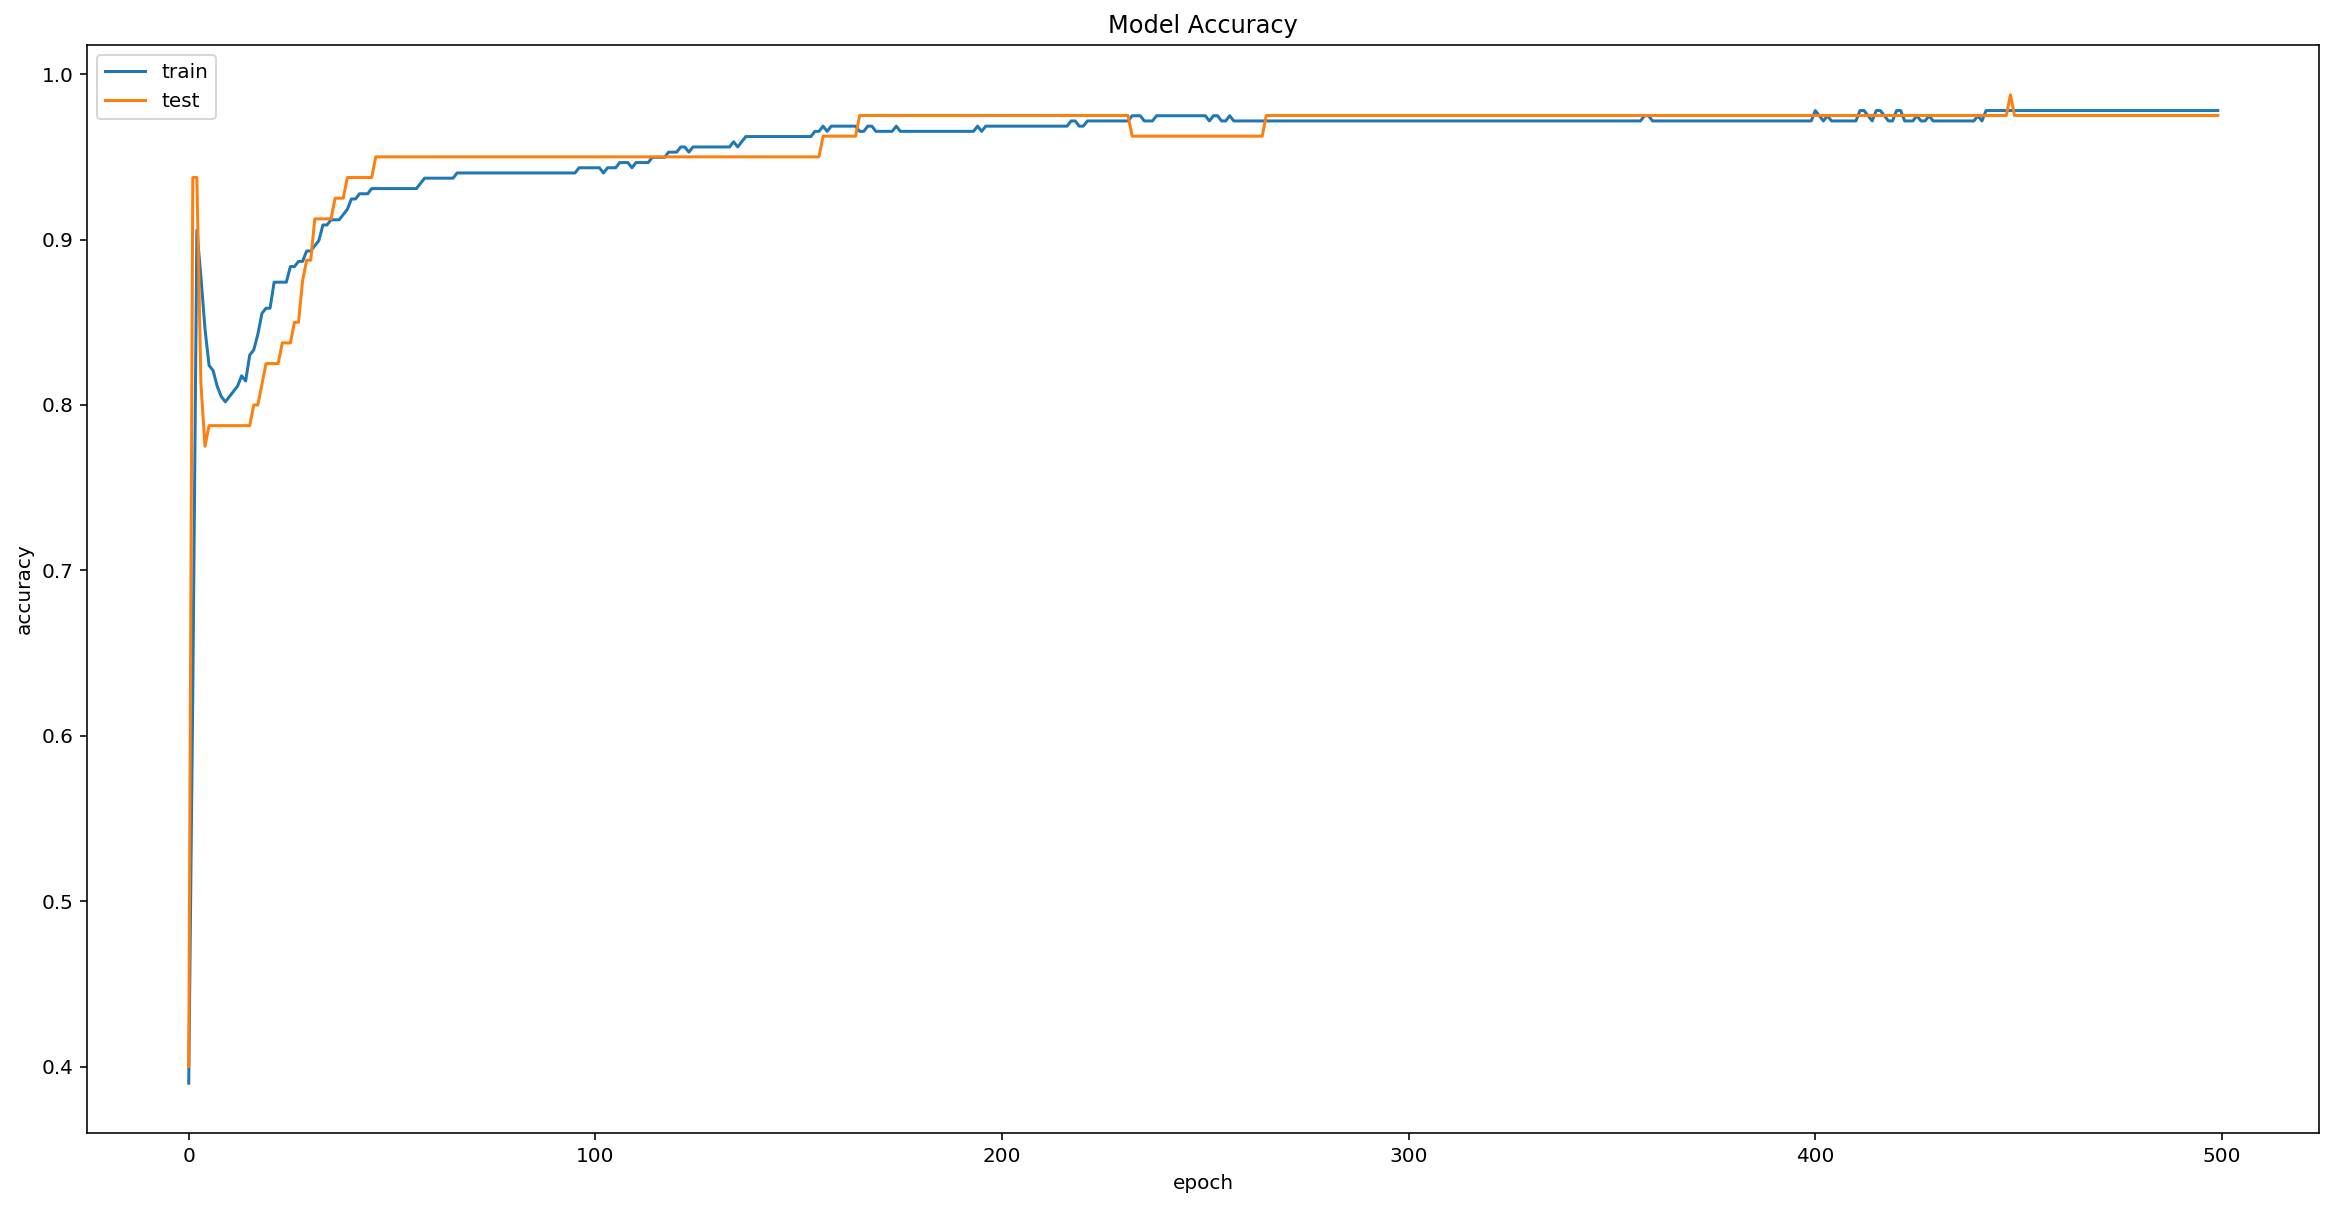

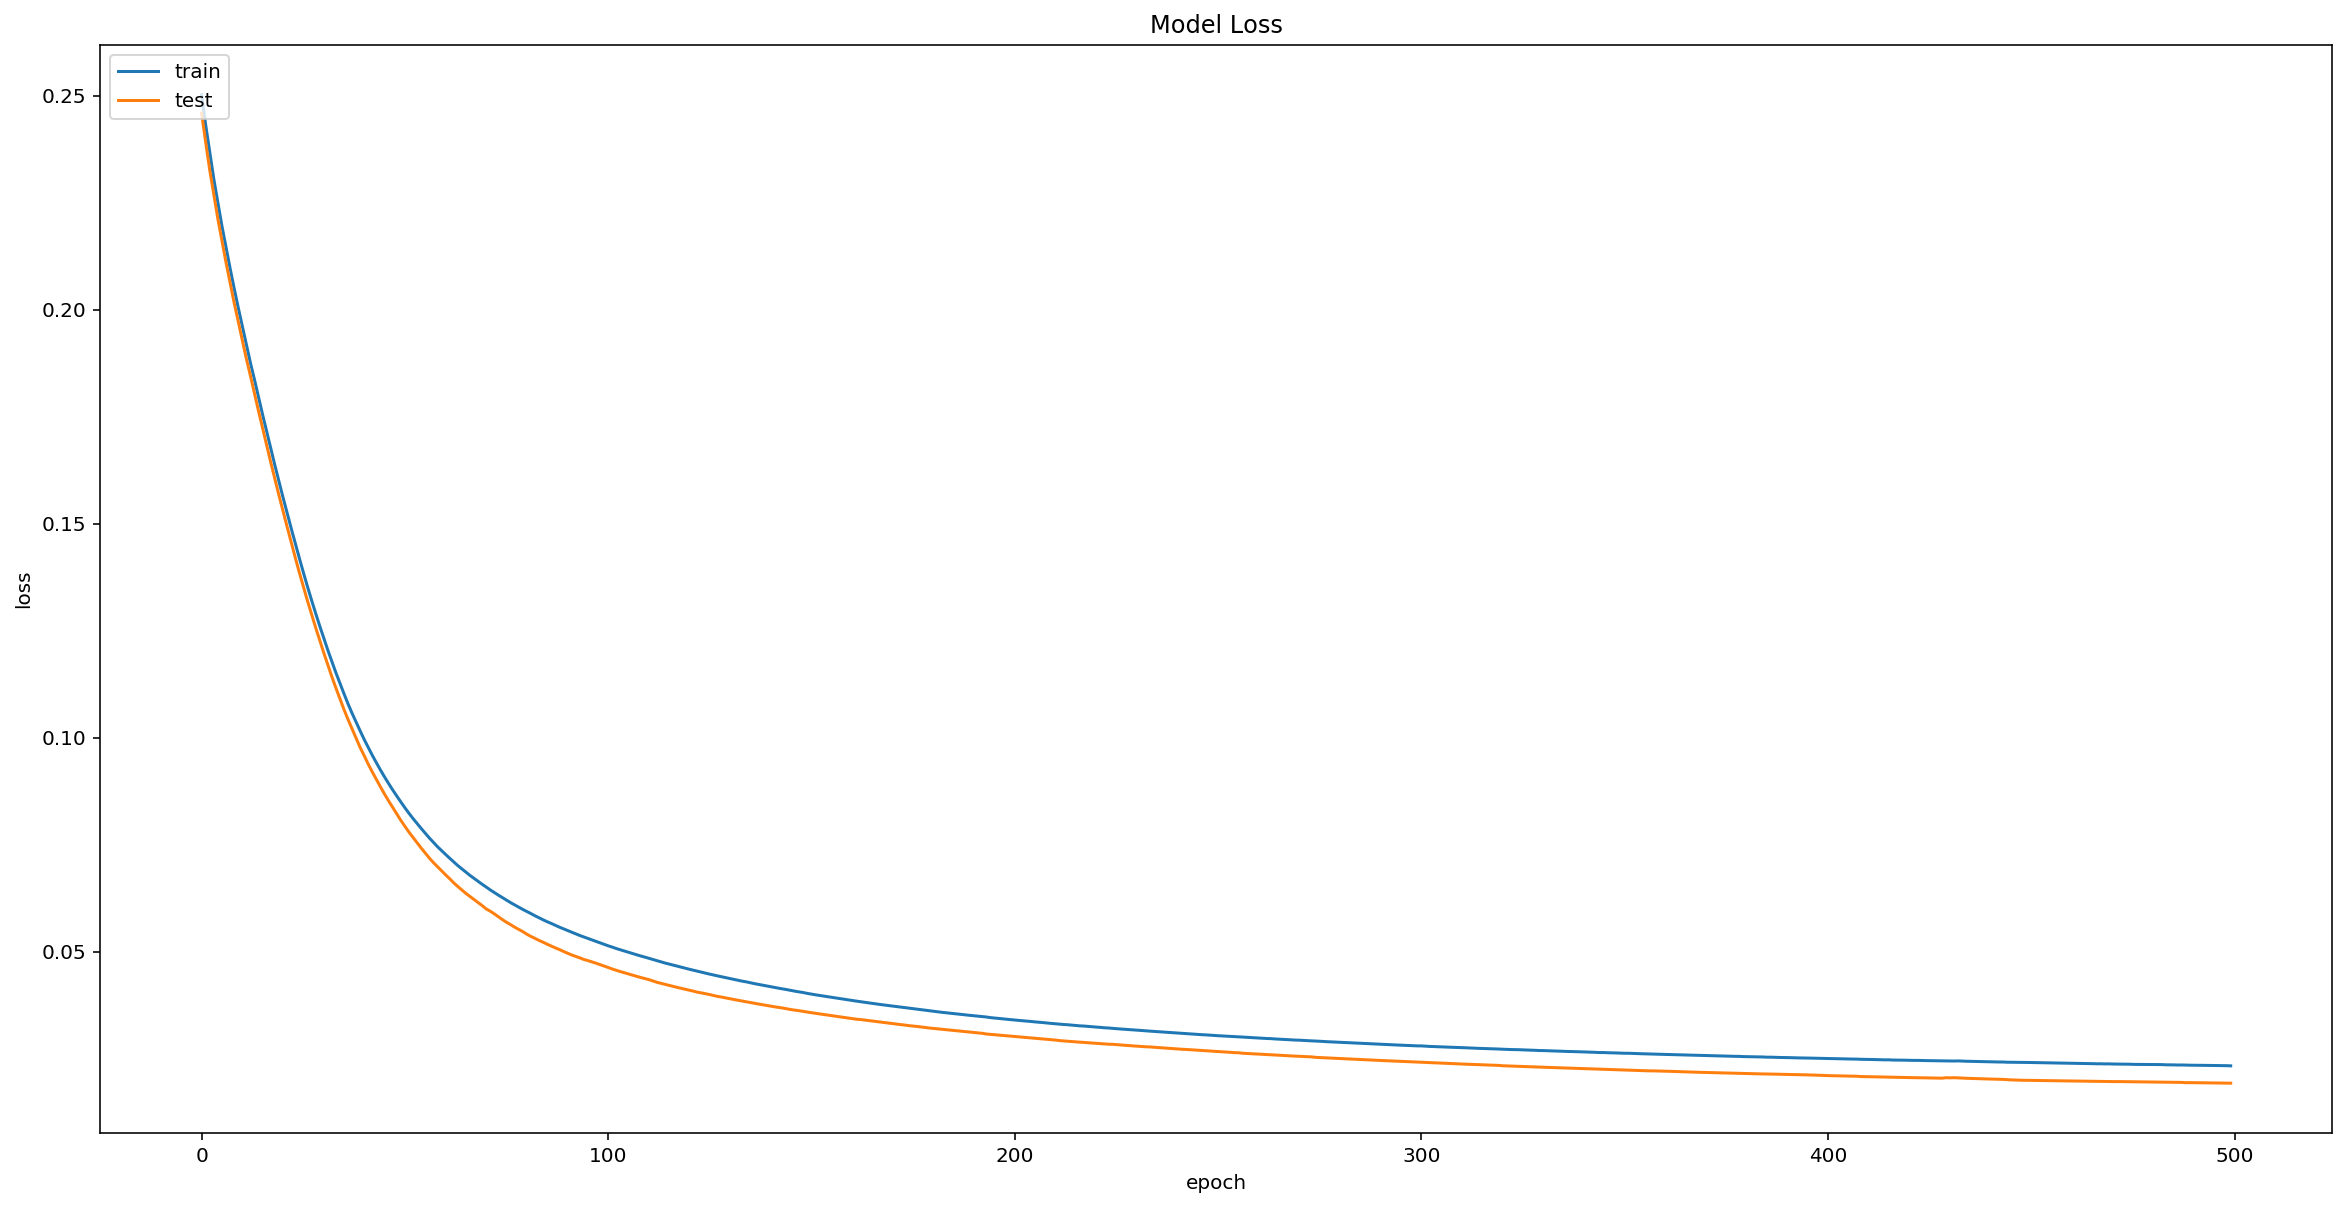

Memory Usage 0.15 MB
Time of Processing 18.47s
Accuracy 95.32%


In [55]:
show_info(model13, X_test_norm, y_test, keras_history13)

In [56]:
# Building the model 14
model14 = Sequential()
model14.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model14.add(Dense(64, activation='tanh'))
model14.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd14 = optimizers.SGD(lr=0.5)
model14.compile(loss = 'mean_squared_error', optimizer=sgd14, metrics=['accuracy'])
model14.summary()

# Training the model 14
keras_history14 = KerasHistory()
memory_usage = monitor(target=train(model14, X_train_norm, y_train, keras_history14, epochs=500, batch_size=15))
keras_history14.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.1637 - acc: 0.8145 - val_loss: 0.0872 - val_acc: 0.9375
Epoch 2/500
 - 0s - loss: 0.0707 - acc: 0.9277 - val_loss: 0.0486 - val_acc: 0.9500
Epoch 3/500
 - 0s - loss: 0.0485 - acc: 0.9434 - val_loss: 0.0368 - val_acc: 0.9500
Epoch 4/500
 - 0s - loss: 0.0405 - acc: 0.9528 - val_loss: 0.0550 - val_acc: 0.9125
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0141 - acc: 0.9843 - val_loss: 0.0302 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0152 - acc: 0.9843 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 91/500
 - 0s - loss: 0.0162 - acc: 0.9843 - val_loss: 0.0146 - val_acc: 0.9750
Epoch 92/500
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9625
Epoch 93/500
 - 0s - loss: 0.0141 - acc: 0.9874 - val_loss: 0.0101 - val_acc: 0.9875
Epoch 94/500
 - 0s - loss: 0.0175 - acc: 0.9843 - val_loss: 0.0171 - val_acc: 0.9750
Epoch 95/500
 - 0s - loss: 0.0151 - acc: 0.9874 - val_loss: 0.0213 - val_acc: 0.9625
Epoch 96/500
 - 0s - loss: 0.0145 - acc: 0.9874 - val_loss: 0.0165 - val_acc: 0.9750
Epoch 97/500
 - 0s - loss: 0.0148 - acc: 0.9874 - val_loss: 0.0185 - val_acc: 0.9750
Epoch 98/500
 - 0s - loss: 0.0142 - acc: 0.9906 - val_loss: 0.0162 - val_acc: 0.9750
Epoch 99/500
 - 0s - loss: 0.0147 - acc: 0.9874 - val_loss: 0.0186 - val_acc: 0.9750
Epoch 100/500
 - 0s - loss: 0.0147 - acc: 0.9874 - val_loss: 0.01

Epoch 185/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0219 - val_acc: 0.9625
Epoch 186/500
 - 0s - loss: 0.0129 - acc: 0.9874 - val_loss: 0.0162 - val_acc: 0.9875
Epoch 187/500
 - 0s - loss: 0.0136 - acc: 0.9874 - val_loss: 0.0159 - val_acc: 0.9875
Epoch 188/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0156 - val_acc: 0.9875
Epoch 189/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0175 - val_acc: 0.9875
Epoch 190/500
 - 0s - loss: 0.0129 - acc: 0.9874 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 191/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0184 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0224 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0167 - val_acc: 0.9875
Epoch 194/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0230 - val_acc: 0.9625
Epoch 195/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0137 - acc: 0.9843 - val

Epoch 281/500
 - 0s - loss: 0.0120 - acc: 0.9874 - val_loss: 0.0226 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0123 - acc: 0.9874 - val_loss: 0.0230 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0179 - val_acc: 0.9875
Epoch 284/500
 - 0s - loss: 0.0134 - acc: 0.9843 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0119 - acc: 0.9874 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0130 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0132 - acc: 0.9843 - val_loss: 0.0196 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0120 - acc: 0.9874 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0124 - acc: 0.9874 - val_loss: 0.0206 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0181 - val_acc: 0.9875
Epoch 291/500
 - 0s - loss: 0.0119 - acc: 0.9874 - val_loss: 0.0194 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0107 - acc: 0.9906 - val

Epoch 377/500
 - 0s - loss: 0.0113 - acc: 0.9874 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0119 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0116 - acc: 0.9874 - val_loss: 0.0926 - val_acc: 0.8875
Epoch 380/500
 - 0s - loss: 0.0334 - acc: 0.9623 - val_loss: 0.0158 - val_acc: 0.9875
Epoch 381/500
 - 0s - loss: 0.0122 - acc: 0.9843 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0211 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0215 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0110 - acc: 0.9906 - val_loss: 0.0183 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0105 - acc: 0.9906 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0103 - acc: 0.9906 - val_loss: 0.0217 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0126 - acc: 0.9874 - val

Epoch 473/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 474/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0237 - val_acc: 0.9625
Epoch 475/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 476/500
 - 0s - loss: 0.0100 - acc: 0.9906 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 477/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0235 - val_acc: 0.9750
Epoch 478/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 479/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0235 - val_acc: 0.9750
Epoch 480/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0236 - val_acc: 0.9750
Epoch 481/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0239 - val_acc: 0.9750
Epoch 482/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0229 - val_acc: 0.9750
Epoch 483/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 484/500
 - 0s - loss: 0.0100 - acc: 0.9906 - val

## Treinamento 14
Para o treinamento 14 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.5

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Nesse modelo como a taxa de aprendizado é muito alta o modelo "aprende" muito rápido, o que pode não ser o ideal, pois pode achar um mínimo local.

Nesse ciclo podemos observar os resultados abaixo:

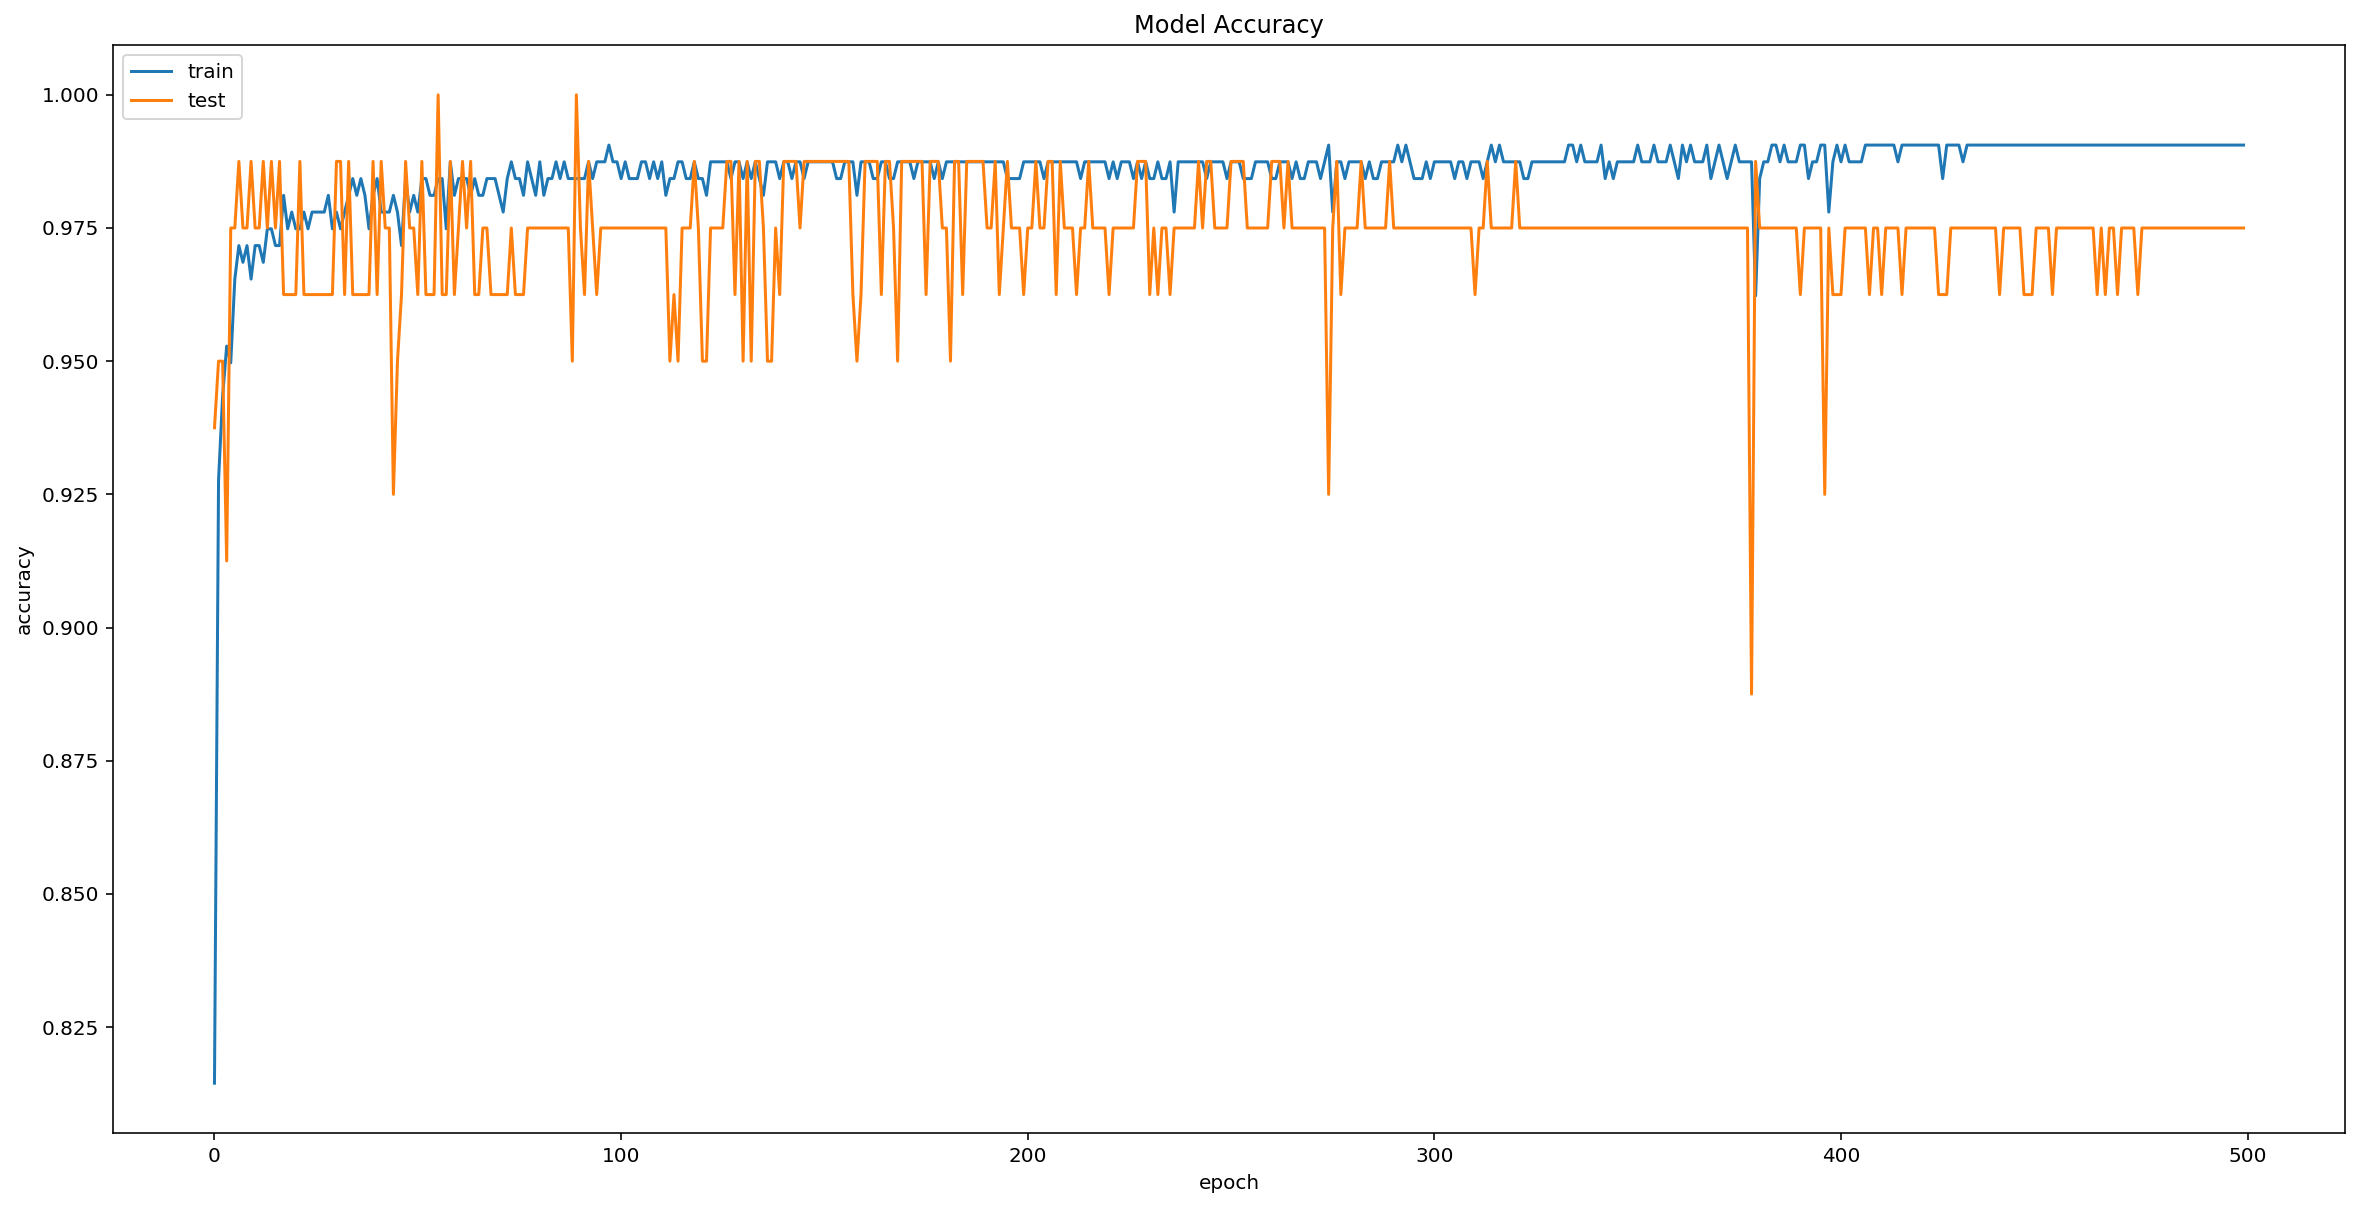

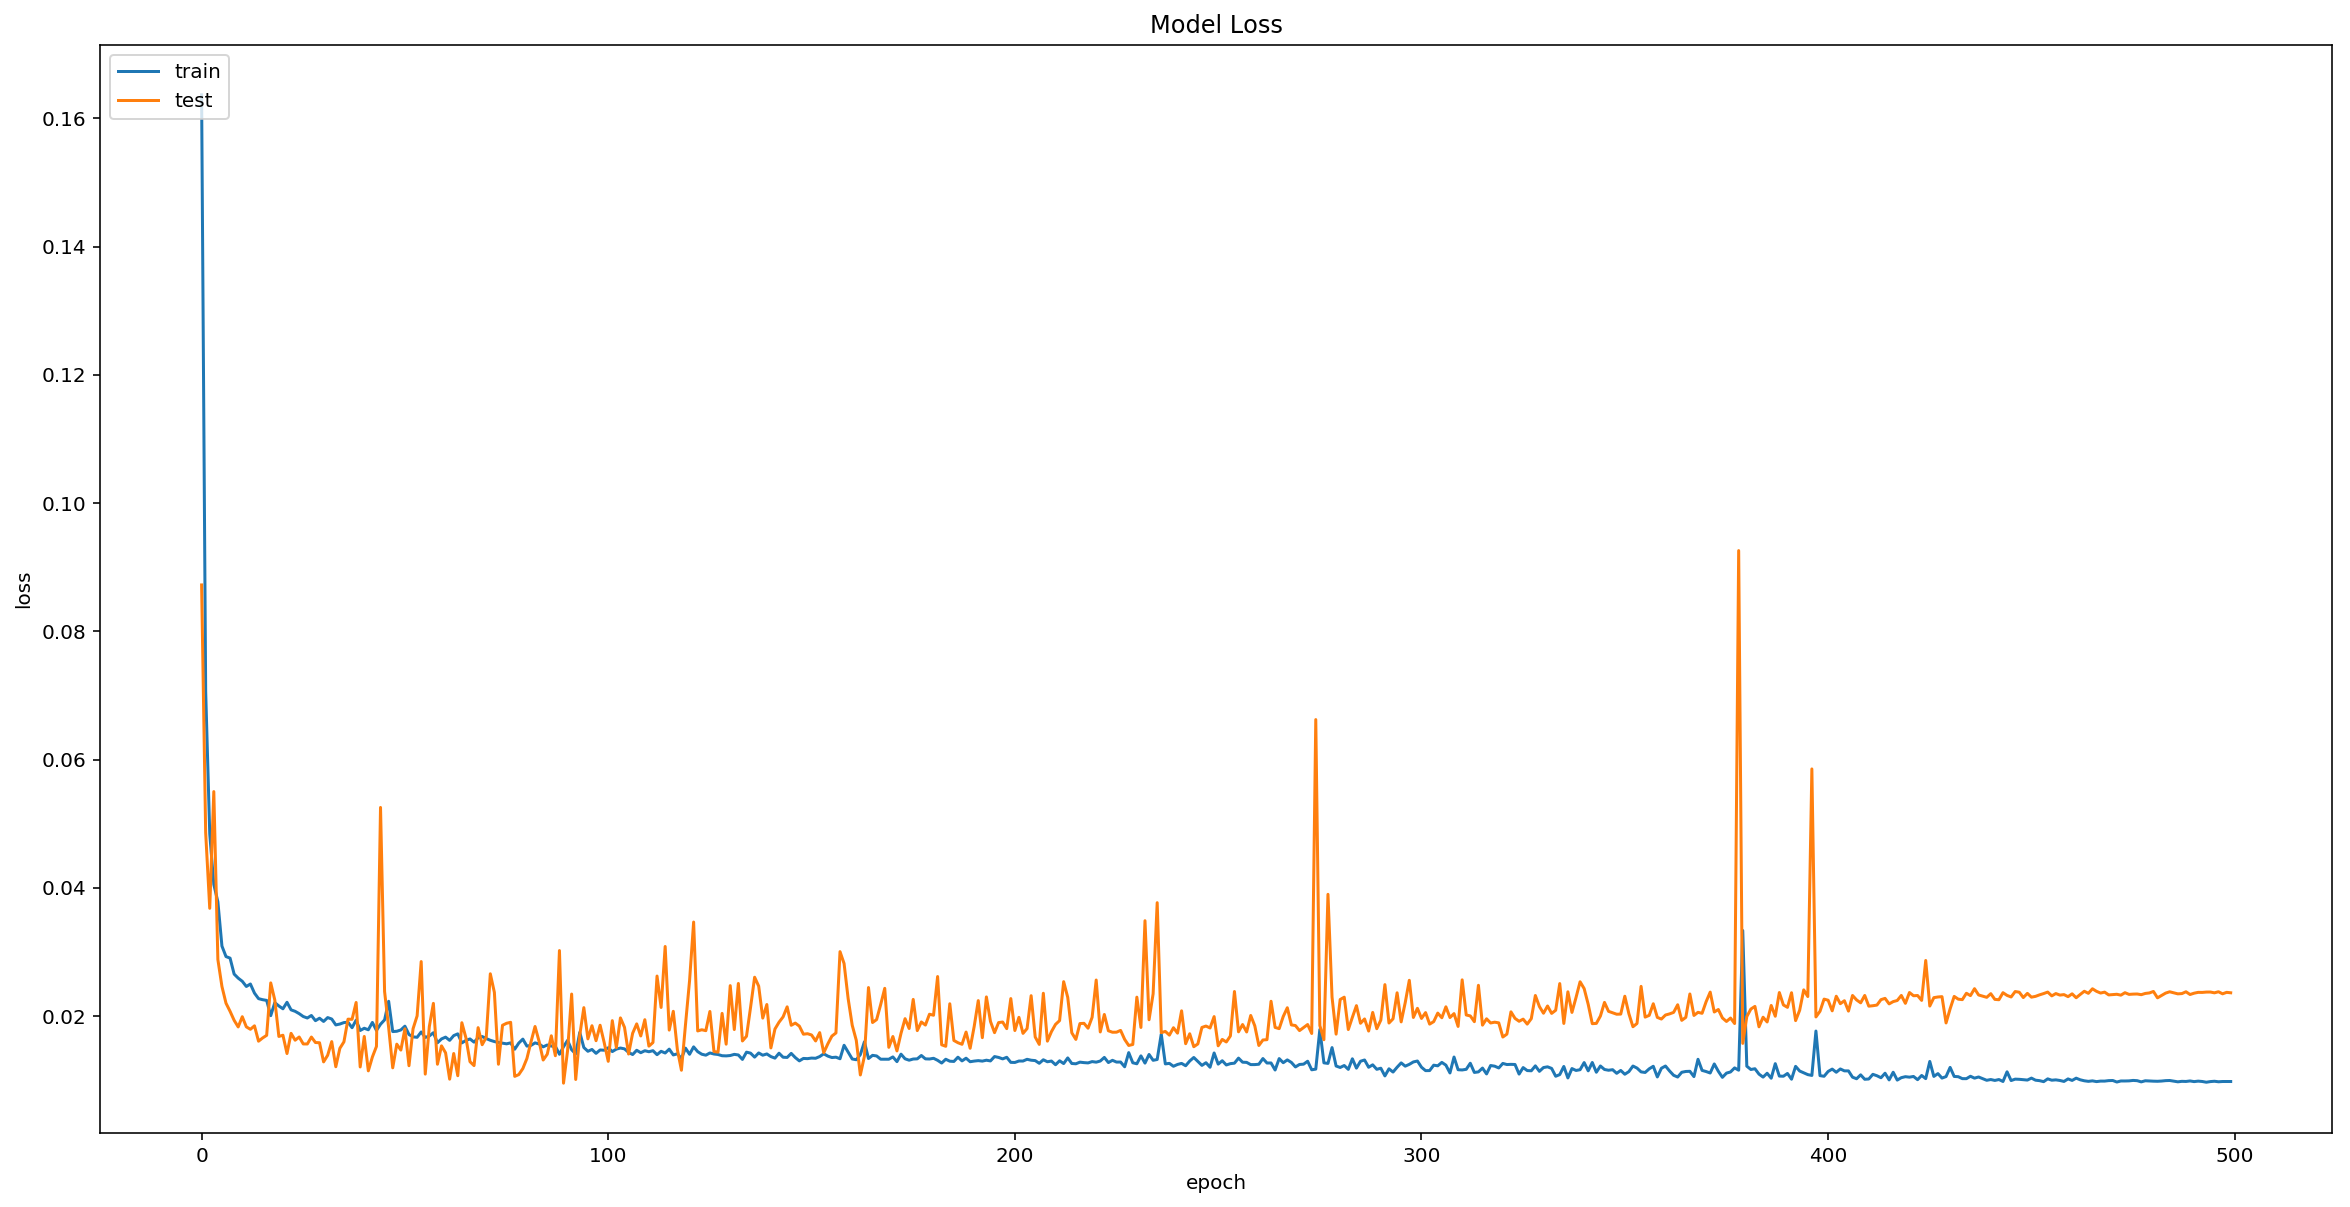

Memory Usage 0.15 MB
Time of Processing 18.34s
Accuracy 95.32%


In [58]:
show_info(model14, X_test_norm, y_test, keras_history14)

In [62]:
# Building the model 15
model15 = Sequential()
model15.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model15.add(Dense(64, activation='tanh'))
model15.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd15 = optimizers.SGD(lr=0.009)
model15.compile(loss = 'mean_squared_error', optimizer=sgd15, metrics=['accuracy'])
model15.summary()

# Training the model 15
keras_history15 = KerasHistory()
memory_usage = monitor(target=train(model15, X_train_norm, y_train, keras_history15, epochs=500, batch_size=15))
keras_history15.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.2503 - acc: 0.4340 - val_loss: 0.2482 - val_acc: 0.5375
Epoch 2/500
 - 0s - loss: 0.2456 - acc: 0.7673 - val_loss: 0.2435 - val_acc: 0.9250
Epoch 3/500
 - 0s - loss: 0.2411 - acc: 0.9057 - val_loss: 0.2387 - val_acc: 0.8500
Epoch 4/500
 - 0s - loss: 0.2365 - acc: 0.8396 - val_loss: 0.2344 - val_acc: 0.7875
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0625 - acc: 0.9403 - val_loss: 0.0578 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0620 - acc: 0.9403 - val_loss: 0.0574 - val_acc: 0.9500
Epoch 91/500
 - 0s - loss: 0.0615 - acc: 0.9403 - val_loss: 0.0569 - val_acc: 0.9500
Epoch 92/500
 - 0s - loss: 0.0610 - acc: 0.9403 - val_loss: 0.0564 - val_acc: 0.9500
Epoch 93/500
 - 0s - loss: 0.0606 - acc: 0.9403 - val_loss: 0.0559 - val_acc: 0.9500
Epoch 94/500
 - 0s - loss: 0.0601 - acc: 0.9403 - val_loss: 0.0554 - val_acc: 0.9500
Epoch 95/500
 - 0s - loss: 0.0596 - acc: 0.9403 - val_loss: 0.0550 - val_acc: 0.9500
Epoch 96/500
 - 0s - loss: 0.0592 - acc: 0.9403 - val_loss: 0.0545 - val_acc: 0.9500
Epoch 97/500
 - 0s - loss: 0.0588 - acc: 0.9403 - val_loss: 0.0541 - val_acc: 0.9500
Epoch 98/500
 - 0s - loss: 0.0584 - acc: 0.9403 - val_loss: 0.0536 - val_acc: 0.9500
Epoch 99/500
 - 0s - loss: 0.0579 - acc: 0.9434 - val_loss: 0.0532 - val_acc: 0.9500
Epoch 100/500
 - 0s - loss: 0.0575 - acc: 0.9403 - val_loss: 0.05

Epoch 185/500
 - 0s - loss: 0.0388 - acc: 0.9654 - val_loss: 0.0348 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0387 - acc: 0.9654 - val_loss: 0.0347 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0386 - acc: 0.9654 - val_loss: 0.0346 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0385 - acc: 0.9654 - val_loss: 0.0346 - val_acc: 0.9625
Epoch 189/500
 - 0s - loss: 0.0383 - acc: 0.9654 - val_loss: 0.0344 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0382 - acc: 0.9654 - val_loss: 0.0343 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0381 - acc: 0.9654 - val_loss: 0.0342 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0380 - acc: 0.9654 - val_loss: 0.0340 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0379 - acc: 0.9654 - val_loss: 0.0339 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0378 - acc: 0.9654 - val_loss: 0.0338 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0376 - acc: 0.9654 - val_loss: 0.0337 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0375 - acc: 0.9654 - val

Epoch 281/500
 - 0s - loss: 0.0309 - acc: 0.9717 - val_loss: 0.0274 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0308 - acc: 0.9717 - val_loss: 0.0273 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0308 - acc: 0.9717 - val_loss: 0.0273 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0307 - acc: 0.9717 - val_loss: 0.0272 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0307 - acc: 0.9717 - val_loss: 0.0272 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0306 - acc: 0.9717 - val_loss: 0.0271 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0305 - acc: 0.9717 - val_loss: 0.0271 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0305 - acc: 0.9717 - val_loss: 0.0270 - val_acc: 0.9625
Epoch 289/500
 - 0s - loss: 0.0304 - acc: 0.9717 - val_loss: 0.0270 - val_acc: 0.9625
Epoch 290/500
 - 0s - loss: 0.0304 - acc: 0.9717 - val_loss: 0.0269 - val_acc: 0.9625
Epoch 291/500
 - 0s - loss: 0.0303 - acc: 0.9717 - val_loss: 0.0269 - val_acc: 0.9625
Epoch 292/500
 - 0s - loss: 0.0303 - acc: 0.9717 - val

Epoch 377/500
 - 0s - loss: 0.0271 - acc: 0.9717 - val_loss: 0.0235 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0270 - acc: 0.9717 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0270 - acc: 0.9717 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0270 - acc: 0.9717 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 381/500
 - 0s - loss: 0.0269 - acc: 0.9717 - val_loss: 0.0234 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0269 - acc: 0.9717 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0269 - acc: 0.9717 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0269 - acc: 0.9717 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0268 - acc: 0.9717 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0268 - acc: 0.9717 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0268 - acc: 0.9717 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0267 - acc: 0.9717 - val

Epoch 473/500
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0210 - val_acc: 0.9750
Epoch 474/500
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0210 - val_acc: 0.9750
Epoch 475/500
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0210 - val_acc: 0.9750
Epoch 476/500
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0210 - val_acc: 0.9750
Epoch 477/500
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0210 - val_acc: 0.9750
Epoch 478/500
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 479/500
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 480/500
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 481/500
 - 0s - loss: 0.0247 - acc: 0.9717 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 482/500
 - 0s - loss: 0.0247 - acc: 0.9717 - val_loss: 0.0208 - val_acc: 0.9750
Epoch 483/500
 - 0s - loss: 0.0247 - acc: 0.9717 - val_loss: 0.0208 - val_acc: 0.9750
Epoch 484/500
 - 0s - loss: 0.0247 - acc: 0.9717 - val

## Treinamento 15
Para o treinamento 15 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.009

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Com uma taxa de aprendizado menor, o modelo converge mais lentamento, mas com um curva mais suave a tendência é maior de encontrar o mínimo global.

Nesse ciclo podemos observar os resultados abaixo:

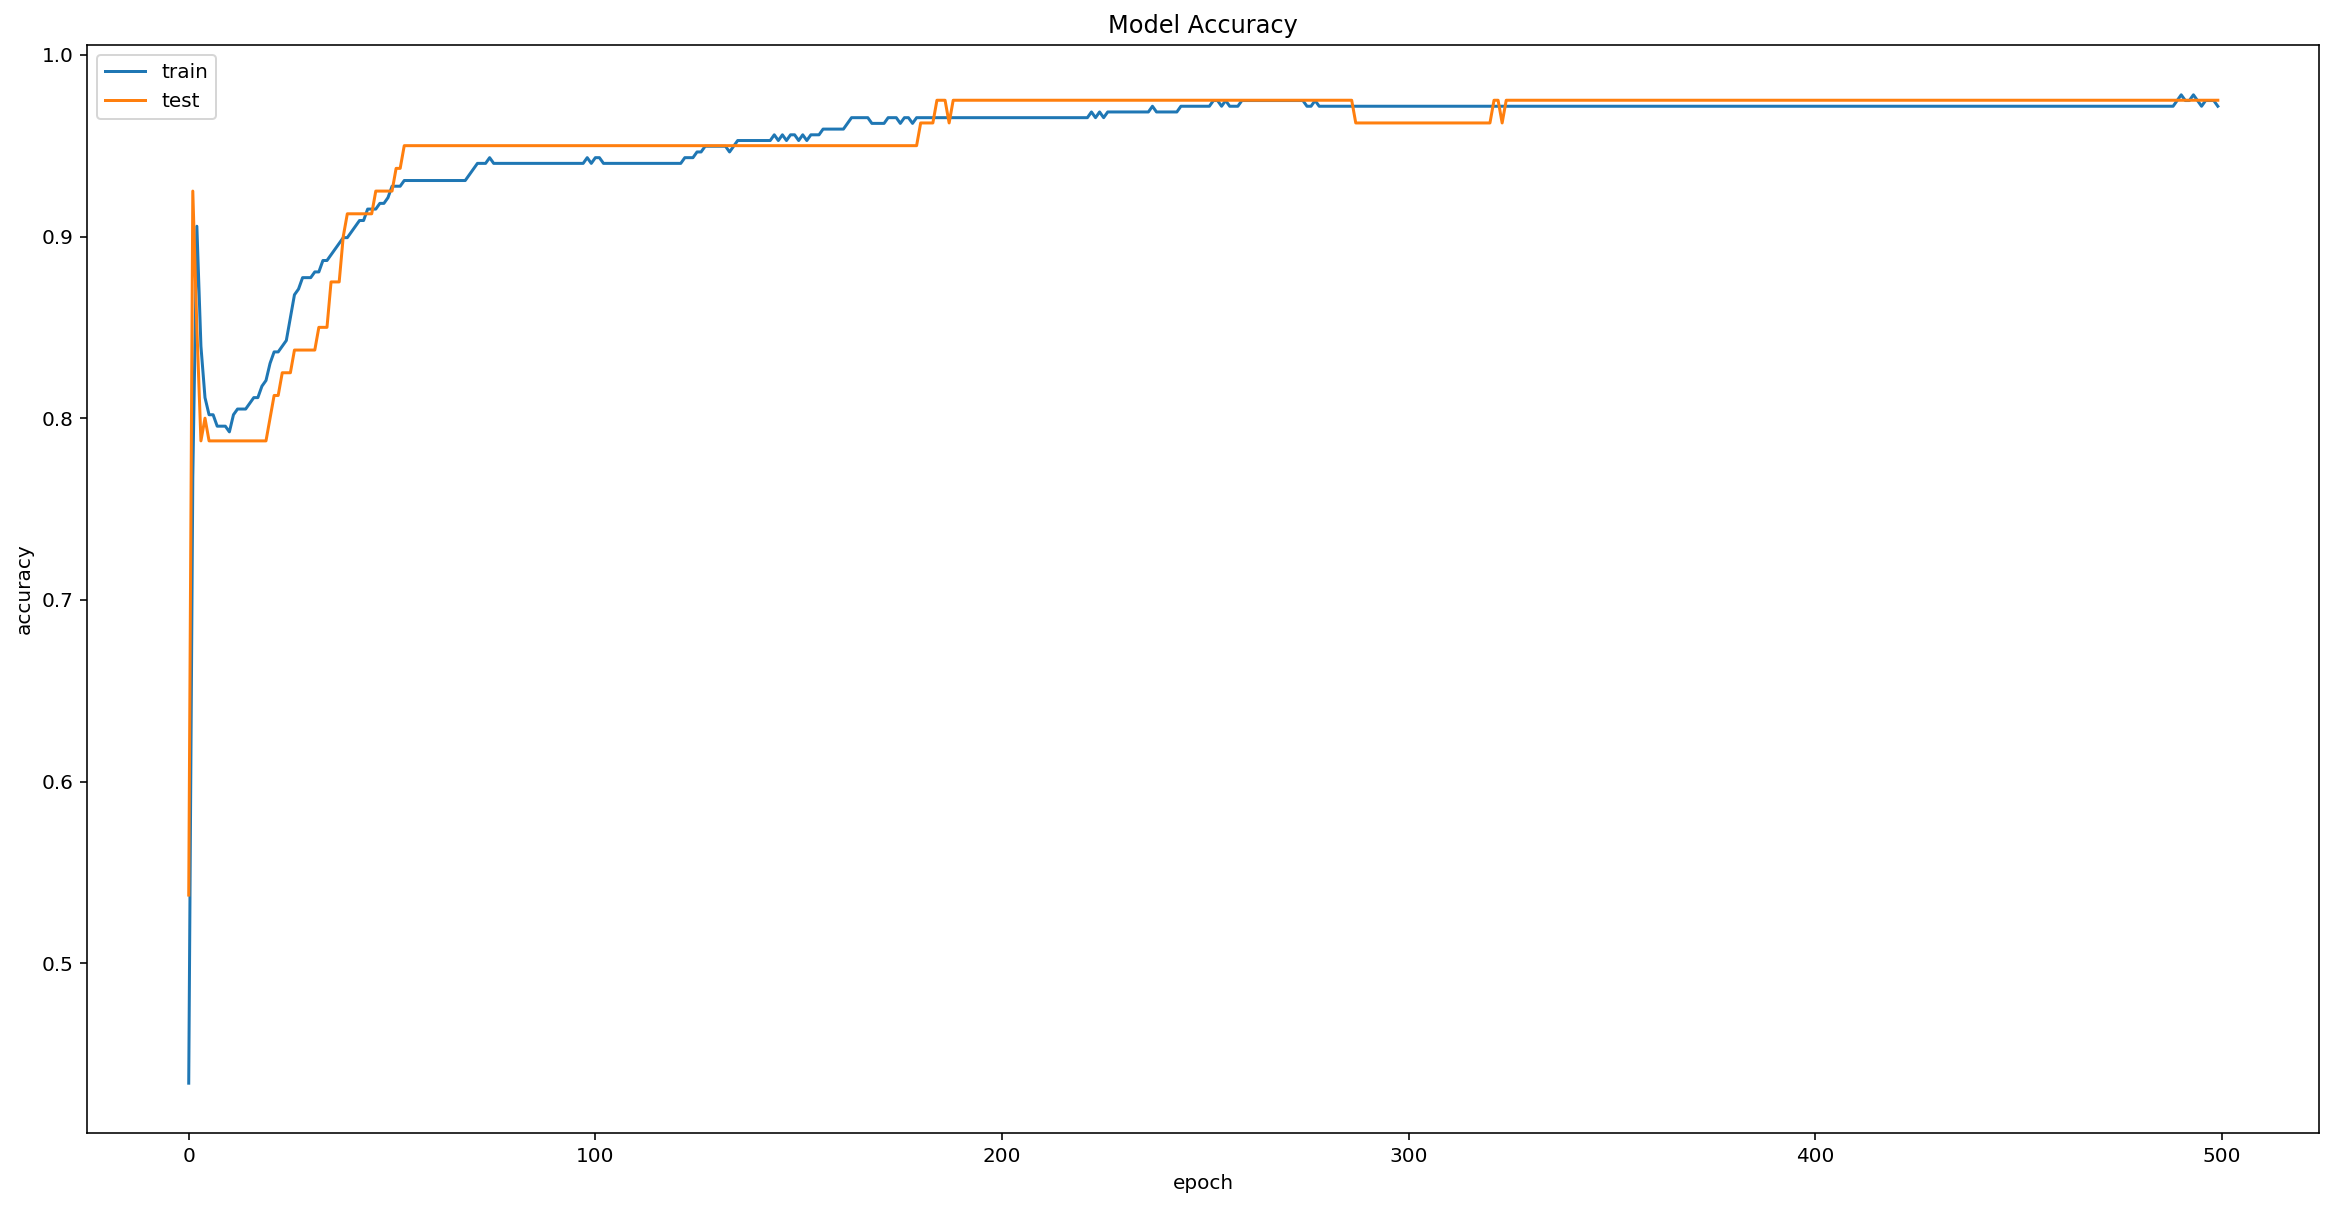

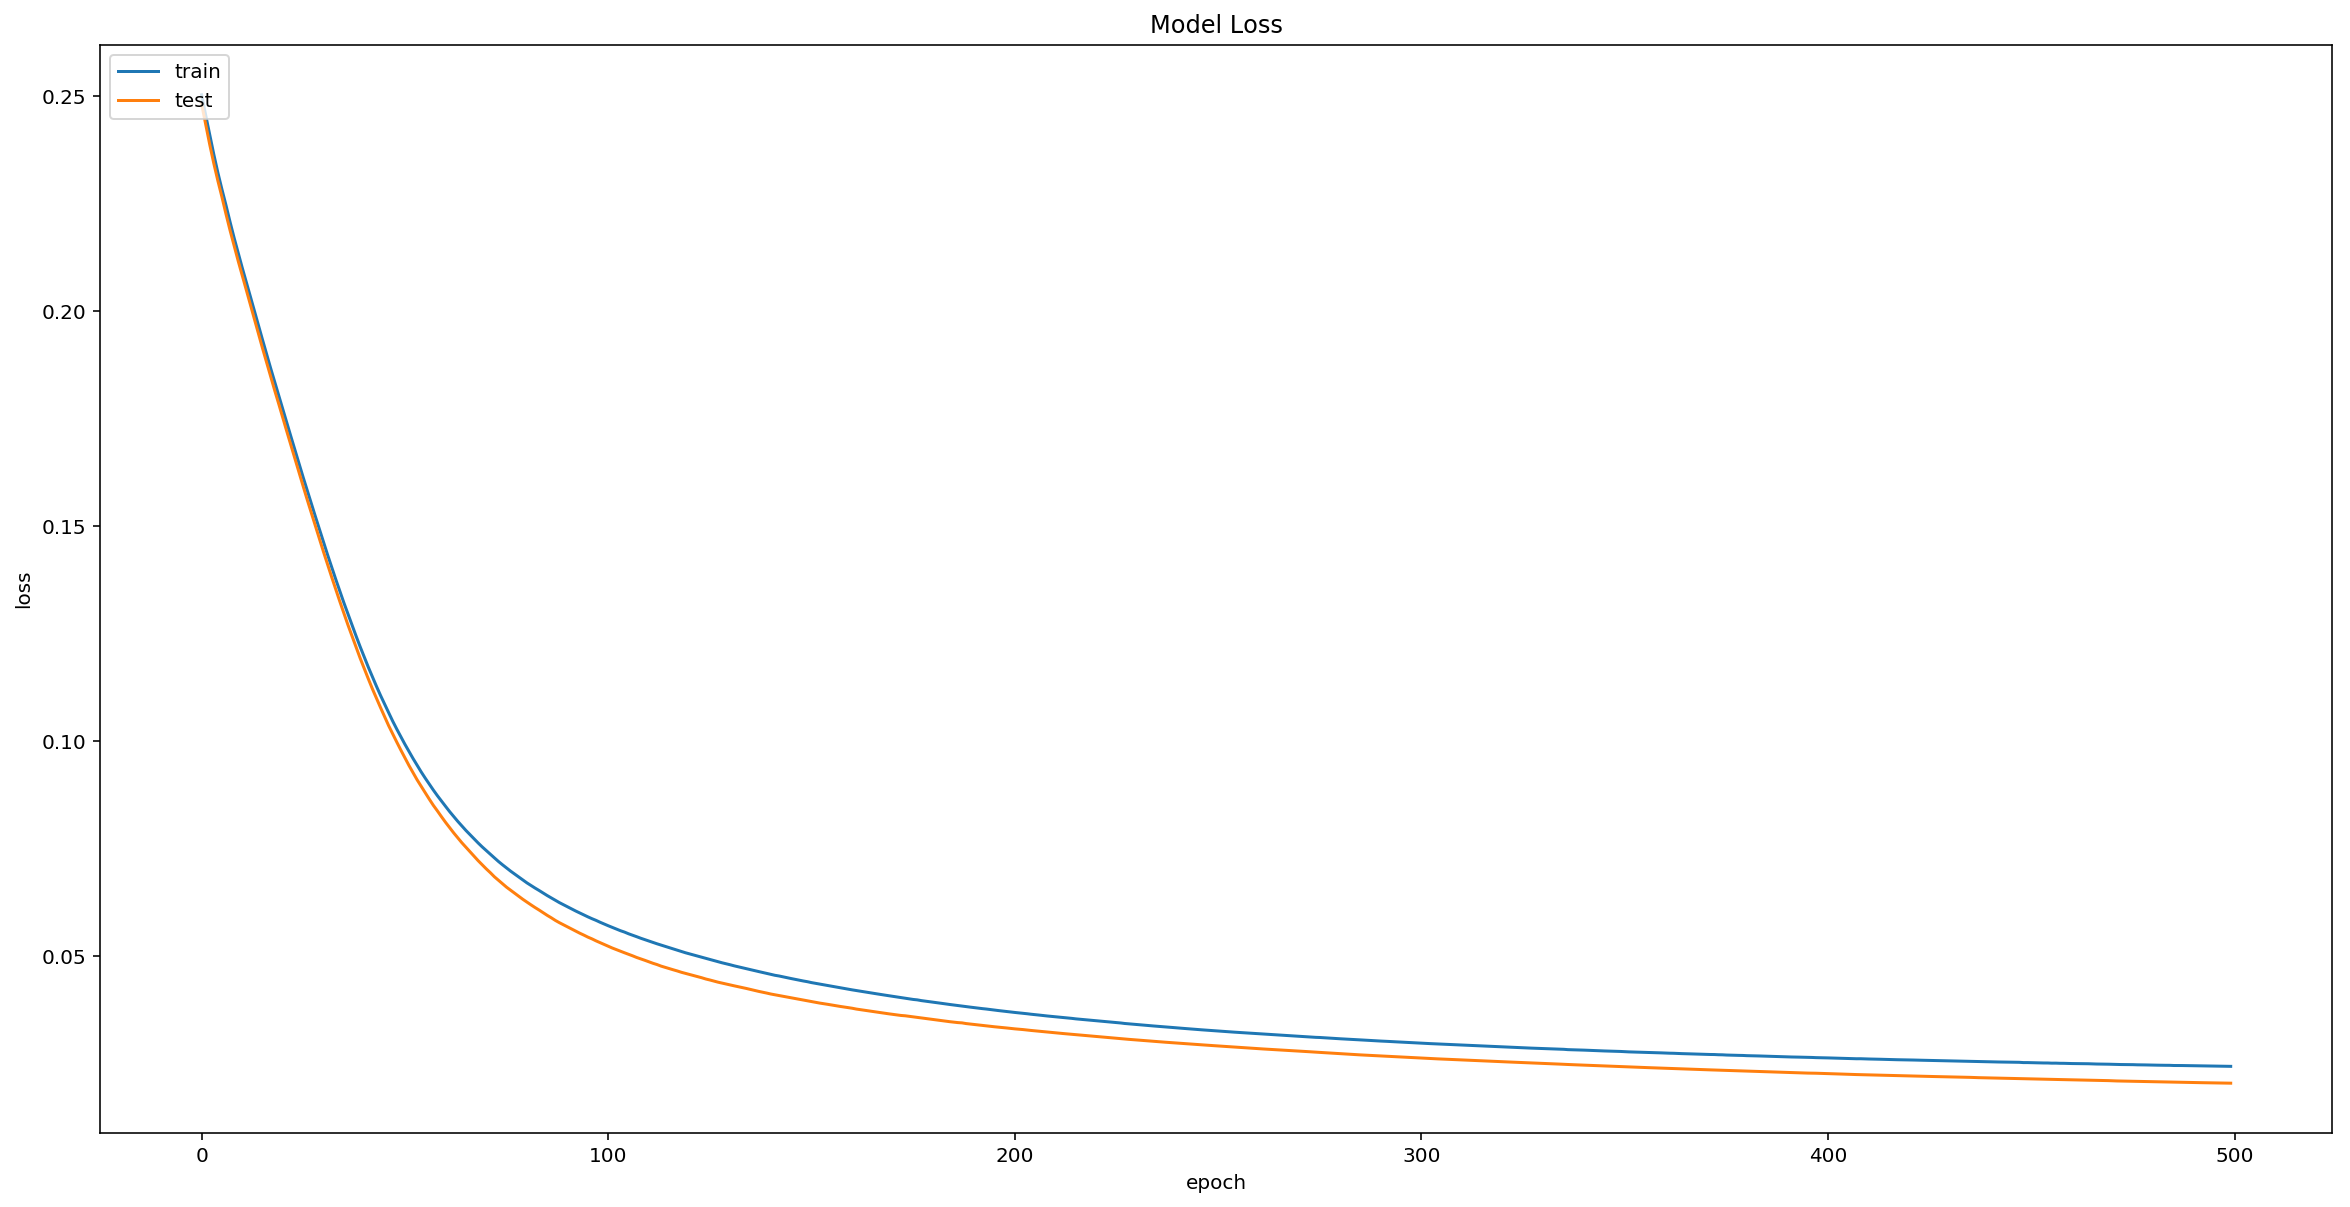

Memory Usage 0.15 MB
Time of Processing 18.99s
Accuracy 95.32%


In [63]:
show_info(model15, X_test_norm, y_test, keras_history15)